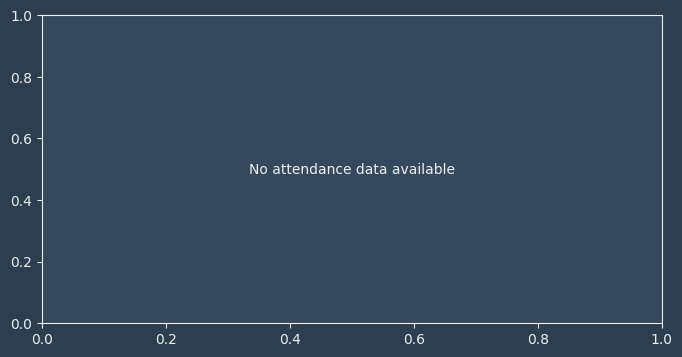

In [1]:
import cv2
import pickle
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, time
from deepface import DeepFace
from face_recognition import face_encodings, face_distance
import os
import tkinter as tk
from tkinter import ttk, messagebox, filedialog
from PIL import Image, ImageTk
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import threading
import queue

# Configuration
ENCODINGS_FILE = 'data/encodings.pkl'
ATTENDANCE_FILE = 'data/attendance.csv'
TIMETABLE_FILE = 'data/timetable1.csv'
SPOOF_THRESHOLD = 0.7
RECOGNITION_THRESHOLD = 0.5
DETECTOR_BACKEND = "opencv"
ATTENDANCE_INTERVAL = timedelta(hours=1)
CAMERA_FPS = 15  # Target frames per second
PROCESS_EVERY_N_FRAMES = 2  # Process every nth frame to reduce CPU load

# Color Theme
BG_COLOR = "#2c3e50"
FG_COLOR = "#ecf0f1"
ACCENT_COLOR = "#3498db"
WARNING_COLOR = "#e74c3c"
SUCCESS_COLOR = "#2ecc71"
FRAME_COLOR = "#34495e"

class EnhancedFaceRecognitionApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Interactive Face Recognition System")
        self.root.geometry("1200x800")
        self.root.configure(bg=BG_COLOR)
        
        # Initialize variables
        self.frame_queue = queue.Queue(maxsize=2)  # Limit queue size to prevent memory buildup
        self.result_queue = queue.Queue()
        self.processing_thread = None
        self.camera_thread = None
        self.stop_event = threading.Event()
        
        # Style configuration
        self.style = ttk.Style()
        self.style.theme_use('clam')
        self.configure_styles()
        
        # Load data
        self.known_encodings, self.known_names = self.load_encodings()
        self.attendance_df = self.load_attendance()
        self.timetable_df = self.load_timetable()
        self.recently_recognized = {}
        self.cap = None
        self.current_class = None
        self.running = False
        self.frame_count = 0
        
        # Setup GUI
        self.setup_gui()
        self.update_current_class()
        
        # Start the result processing loop
        self.process_results()
        
    def configure_styles(self):
        self.style.configure('TFrame', background=BG_COLOR)
        self.style.configure('TLabel', background=BG_COLOR, foreground=FG_COLOR)
        self.style.configure('TButton', background=ACCENT_COLOR, foreground=FG_COLOR, 
                           font=('Helvetica', 10, 'bold'))
        self.style.configure('TNotebook', background=BG_COLOR)
        self.style.configure('TNotebook.Tab', background=FRAME_COLOR, foreground=FG_COLOR,
                           padding=[10, 5], font=('Helvetica', 10, 'bold'))
        self.style.map('TNotebook.Tab', background=[('selected', ACCENT_COLOR)])
        self.style.configure('Treeview', background=FRAME_COLOR, foreground=FG_COLOR,
                           fieldbackground=FRAME_COLOR)
        self.style.configure('Treeview.Heading', background=ACCENT_COLOR, foreground=FG_COLOR)
        self.style.map('Treeview', background=[('selected', '#2980b9')])
        
    def setup_gui(self):
        # Create notebook (tabs)
        self.notebook = ttk.Notebook(self.root)
        self.notebook.pack(fill=tk.BOTH, expand=True, padx=10, pady=10)
        
        # Tab 1: Live Recognition
        self.live_tab = ttk.Frame(self.notebook)
        self.notebook.add(self.live_tab, text="Live Recognition")
        self.setup_live_tab()
        
        # Tab 2: Attendance Log
        self.log_tab = ttk.Frame(self.notebook)
        self.notebook.add(self.log_tab, text="Attendance Log")
        self.setup_log_tab()
        
        # Tab 3: Statistics
        self.stats_tab = ttk.Frame(self.notebook)
        self.notebook.add(self.stats_tab, text="Statistics")
        self.setup_stats_tab()
        
        # Status bar
        self.status_var = tk.StringVar()
        self.status_var.set("System Ready")
        self.status_bar = tk.Label(self.root, textvariable=self.status_var, bd=1, relief=tk.SUNKEN, 
                                 anchor=tk.W, bg=FRAME_COLOR, fg=FG_COLOR, font=('Helvetica', 10))
        self.status_bar.pack(side=tk.BOTTOM, fill=tk.X)
        
    def setup_live_tab(self):
        # Main container
        main_frame = ttk.Frame(self.live_tab)
        main_frame.pack(fill=tk.BOTH, expand=True, padx=10, pady=10)
        
        # Left panel - Video feed
        left_frame = ttk.Frame(main_frame)
        left_frame.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)
        
        video_frame = ttk.LabelFrame(left_frame, text="Camera Feed", padding=10)
        video_frame.pack(fill=tk.BOTH, expand=True)
        
        self.video_label = tk.Label(video_frame, bg='black')
        self.video_label.pack(fill=tk.BOTH, expand=True)
        
        # Control buttons
        control_frame = ttk.Frame(left_frame)
        control_frame.pack(fill=tk.X, pady=10)
        
        self.start_btn = ttk.Button(control_frame, text="▶ Start", command=self.start_camera,
                                  style='Accent.TButton')
        self.start_btn.pack(side=tk.LEFT, padx=5, ipadx=10, ipady=5)
        
        self.stop_btn = ttk.Button(control_frame, text="■ Stop", command=self.stop_camera,
                                 state=tk.DISABLED, style='Accent.TButton')
        self.stop_btn.pack(side=tk.LEFT, padx=5, ipadx=10, ipady=5)
        
        # Right panel - Class info
        right_frame = ttk.Frame(main_frame)
        right_frame.pack(side=tk.RIGHT, fill=tk.BOTH, padx=10)
        
        # Current class info card
        class_card = ttk.LabelFrame(right_frame, text="Current Class", padding=10)
        class_card.pack(fill=tk.X, pady=5)
        
        self.class_var = tk.StringVar()
        self.class_var.set("No class currently scheduled")
        class_label = ttk.Label(class_card, textvariable=self.class_var, 
                              font=('Helvetica', 12, 'bold'), foreground=ACCENT_COLOR)
        class_label.pack(pady=5)
        
        # Info grid
        info_frame = ttk.Frame(class_card)
        info_frame.pack(fill=tk.X)
        
        ttk.Label(info_frame, text="Time:").grid(row=0, column=0, sticky=tk.W, padx=5, pady=2)
        self.time_var = tk.StringVar()
        self.time_var.set("--:-- -- --:-- --")
        ttk.Label(info_frame, textvariable=self.time_var).grid(row=0, column=1, sticky=tk.W, padx=5, pady=2)
        
        ttk.Label(info_frame, text="Expected:").grid(row=1, column=0, sticky=tk.W, padx=5, pady=2)
        self.expected_var = tk.StringVar()
        self.expected_var.set("--")
        ttk.Label(info_frame, textvariable=self.expected_var).grid(row=1, column=1, sticky=tk.W, padx=5, pady=2)
        
        ttk.Label(info_frame, text="Present:").grid(row=2, column=0, sticky=tk.W, padx=5, pady=2)
        self.present_var = tk.StringVar()
        self.present_var.set("--")
        present_label = ttk.Label(info_frame, textvariable=self.present_var, foreground=SUCCESS_COLOR)
        present_label.grid(row=2, column=1, sticky=tk.W, padx=5, pady=2)
        
        ttk.Label(info_frame, text="Absent:").grid(row=3, column=0, sticky=tk.W, padx=5, pady=2)
        self.absent_var = tk.StringVar()
        self.absent_var.set("--")
        absent_label = ttk.Label(info_frame, textvariable=self.absent_var, foreground=WARNING_COLOR)
        absent_label.grid(row=3, column=1, sticky=tk.W, padx=5, pady=2)
        
        # Student list with scrollbar
        list_frame = ttk.LabelFrame(right_frame, text="Student Status", padding=10)
        list_frame.pack(fill=tk.BOTH, expand=True, pady=10)
        
        # Create a canvas and scrollbar
        canvas = tk.Canvas(list_frame, bg=FRAME_COLOR, highlightthickness=0)
        scrollbar = ttk.Scrollbar(list_frame, orient="vertical", command=canvas.yview)
        scrollable_frame = ttk.Frame(canvas)
        
        scrollable_frame.bind(
            "<Configure>",
            lambda e: canvas.configure(
                scrollregion=canvas.bbox("all")
            )
        )
        
        canvas.create_window((0, 0), window=scrollable_frame, anchor="nw")
        canvas.configure(yscrollcommand=scrollbar.set)
        
        canvas.pack(side="left", fill="both", expand=True)
        scrollbar.pack(side="right", fill="y")
        
        # Student list will be populated here
        self.student_frame = scrollable_frame
        
    def setup_log_tab(self):
        # Main frame
        main_frame = ttk.Frame(self.log_tab)
        main_frame.pack(fill=tk.BOTH, expand=True, padx=10, pady=10)
        
        # Filter controls
        filter_frame = ttk.Frame(main_frame)
        filter_frame.pack(fill=tk.X, pady=5)
        
        ttk.Label(filter_frame, text="Filter by:").pack(side=tk.LEFT, padx=5)
        
        self.filter_name_var = tk.StringVar()
        name_entry = ttk.Entry(filter_frame, textvariable=self.filter_name_var, width=20)
        name_entry.pack(side=tk.LEFT, padx=5)
        name_entry.bind("<Return>", lambda e: self.apply_filters())
        
        ttk.Label(filter_frame, text="Date:").pack(side=tk.LEFT, padx=5)
        
        self.filter_date_var = tk.StringVar()
        date_entry = ttk.Entry(filter_frame, textvariable=self.filter_date_var, width=10)
        date_entry.pack(side=tk.LEFT, padx=5)
        date_entry.bind("<Return>", lambda e: self.apply_filters())
        
        filter_btn = ttk.Button(filter_frame, text="Apply Filter", command=self.apply_filters)
        filter_btn.pack(side=tk.LEFT, padx=5)
        
        reset_btn = ttk.Button(filter_frame, text="Reset", command=self.reset_filters)
        reset_btn.pack(side=tk.LEFT, padx=5)
        
        # Attendance log
        log_frame = ttk.LabelFrame(main_frame, text="Attendance Records", padding=10)
        log_frame.pack(fill=tk.BOTH, expand=True)
        
        # Create Treeview with scrollbars
        tree_frame = ttk.Frame(log_frame)
        tree_frame.pack(fill=tk.BOTH, expand=True)
        
        self.tree = ttk.Treeview(tree_frame, columns=('Name', 'Timestamp', 'Status', 'Class'), 
                               show='headings', selectmode='browse')
        
        # Configure columns
        self.tree.heading('Name', text='Name')
        self.tree.heading('Timestamp', text='Timestamp')
        self.tree.heading('Status', text='Status')
        self.tree.heading('Class', text='Class')
        
        self.tree.column('Name', width=150)
        self.tree.column('Timestamp', width=180)
        self.tree.column('Status', width=100)
        self.tree.column('Class', width=200)
        
        # Add scrollbars
        y_scroll = ttk.Scrollbar(tree_frame, orient='vertical', command=self.tree.yview)
        x_scroll = ttk.Scrollbar(tree_frame, orient='horizontal', command=self.tree.xview)
        self.tree.configure(yscrollcommand=y_scroll.set, xscrollcommand=x_scroll.set)
        
        # Grid layout
        self.tree.grid(row=0, column=0, sticky='nsew')
        y_scroll.grid(row=0, column=1, sticky='ns')
        x_scroll.grid(row=1, column=0, sticky='ew')
        
        tree_frame.grid_rowconfigure(0, weight=1)
        tree_frame.grid_columnconfigure(0, weight=1)
        
        # Export buttons
        export_frame = ttk.Frame(main_frame)
        export_frame.pack(fill=tk.X, pady=5)
        
        export_csv_btn = ttk.Button(export_frame, text="Export to CSV", command=self.export_to_csv)
        export_csv_btn.pack(side=tk.LEFT, padx=5)
        
        export_pdf_btn = ttk.Button(export_frame, text="Export to PDF", command=self.export_to_pdf)
        export_pdf_btn.pack(side=tk.LEFT, padx=5)
        
        self.update_attendance_log()
        
    def setup_stats_tab(self):
        # Main frame
        main_frame = ttk.Frame(self.stats_tab)
        main_frame.pack(fill=tk.BOTH, expand=True, padx=10, pady=10)
        
        # Stats frame
        stats_frame = ttk.LabelFrame(main_frame, text="Attendance Statistics", padding=10)
        stats_frame.pack(fill=tk.BOTH, expand=True)
        
        # Create matplotlib figure with dark theme
        plt.style.use('dark_background')
        self.fig, self.ax = plt.subplots(figsize=(8, 4), facecolor=FRAME_COLOR)
        self.ax.set_facecolor(FRAME_COLOR)
        
        # Customize colors
        self.fig.patch.set_facecolor(BG_COLOR)
        for spine in self.ax.spines.values():
            spine.set_color(FG_COLOR)
        self.ax.tick_params(colors=FG_COLOR)
        self.ax.xaxis.label.set_color(FG_COLOR)
        self.ax.yaxis.label.set_color(FG_COLOR)
        self.ax.title.set_color(FG_COLOR)
        
        self.canvas = FigureCanvasTkAgg(self.fig, master=stats_frame)
        self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
        
        # Update stats
        self.update_statistics()
        
    def load_encodings(self):
        try:
            with open(ENCODINGS_FILE, 'rb') as f:
                data = pickle.load(f)
            return data['encodings'], data['names']
        except Exception as e:
            messagebox.showerror("Error", f"Error loading encodings: {e}")
            return [], []
    
    def load_attendance(self):
        if os.path.exists(ATTENDANCE_FILE):
            df = pd.read_csv(ATTENDANCE_FILE, parse_dates=['timestamp'])
            if 'class' not in df.columns:
                df['class'] = None
            return df
        return pd.DataFrame(columns=['name', 'timestamp', 'status', 'class'])
    
    def load_timetable(self):
        if os.path.exists(TIMETABLE_FILE):
            df = pd.read_csv(TIMETABLE_FILE)
            df['start_time'] = pd.to_datetime(df['start_time'], format='%H:%M').dt.time
            df['end_time'] = pd.to_datetime(df['end_time'], format='%H:%M').dt.time
            return df
        return pd.DataFrame(columns=['day', 'start_time', 'end_time', 'subject', 'expected_students'])
    
    def save_attendance(self):
        self.attendance_df.to_csv(ATTENDANCE_FILE, index=False)
    
    def update_current_class(self):
        now = datetime.now()
        current_day = now.strftime("%A")
        current_time = now.time()
        
        # Find current class
        current_class = None
        for _, row in self.timetable_df.iterrows():
            if row['day'] == current_day and row['start_time'] <= current_time <= row['end_time']:
                current_class = row
                break
        
        self.current_class = current_class
        
        if current_class is not None:
            # Update class info
            self.class_var.set(f"{current_class['subject']}")
            time_str = f"{current_class['start_time'].strftime('%I:%M %p')} - {current_class['end_time'].strftime('%I:%M %p')}"
            self.time_var.set(time_str)
            
            # Process expected students
            expected_students = current_class['expected_students'].split(';')
            self.expected_var.set(f"{len(expected_students)} students")
            
            # Count present students
            today = now.date()
            present_students = self.attendance_df[
                (self.attendance_df['timestamp'].dt.date == today) &
                (self.attendance_df['name'].isin(expected_students)) &
                (self.attendance_df['status'] == 'Present')
            ]['name'].unique()
            
            absent_students = [s for s in expected_students if s not in present_students]
            self.present_var.set(f"{len(present_students)} students")
            self.absent_var.set(f"{len(absent_students)} students")
            
            # Update student status list
            self.update_student_status_list(expected_students, present_students)
        else:
            self.class_var.set("No class currently scheduled")
            self.time_var.set("--:-- -- --:-- --")
            self.expected_var.set("--")
            self.present_var.set("--")
            self.absent_var.set("--")
            
            # Clear student status list
            for widget in self.student_frame.winfo_children():
                widget.destroy()
    
    def update_student_status_list(self, expected_students, present_students):
        # Clear existing widgets
        for widget in self.student_frame.winfo_children():
            widget.destroy()
        
        # Create new student status widgets
        for student in sorted(expected_students):
            frame = ttk.Frame(self.student_frame)
            frame.pack(fill=tk.X, pady=2, padx=5)
            
            status = "Present" if student in present_students else "Absent"
            color = SUCCESS_COLOR if status == "Present" else WARNING_COLOR
            
            ttk.Label(frame, text=student, width=25).pack(side=tk.LEFT)
            ttk.Label(frame, text=status, foreground=color, font=('Helvetica', 9, 'bold')).pack(side=tk.RIGHT)
    
    def update_attendance_log(self):
        # Clear existing items
        for item in self.tree.get_children():
            self.tree.delete(item)
        
        # Add filtered items
        filtered_df = self.filter_attendance()
        
        for _, row in filtered_df.iterrows():
            self.tree.insert('', tk.END, values=(
                row['name'],
                row['timestamp'].strftime('%Y-%m-%d %H:%M:%S'),
                row['status'],
                row['class'] if pd.notna(row['class']) else ''
            ))
    
    def filter_attendance(self):
        df = self.attendance_df.copy()
        
        # Apply name filter
        name_filter = self.filter_name_var.get().strip()
        if name_filter:
            df = df[df['name'].str.contains(name_filter, case=False)]
        
        # Apply date filter
        date_filter = self.filter_date_var.get().strip()
        if date_filter:
            try:
                filter_date = datetime.strptime(date_filter, '%Y-%m-%d').date()
                df = df[df['timestamp'].dt.date == filter_date]
            except ValueError:
                pass
        
        return df.sort_values('timestamp', ascending=False)
    
    def apply_filters(self):
        self.update_attendance_log()
    
    def reset_filters(self):
        self.filter_name_var.set('')
        self.filter_date_var.set('')
        self.update_attendance_log()
    
    def update_statistics(self):
        if self.attendance_df.empty:
            self.ax.clear()
            self.ax.text(0.5, 0.5, 'No attendance data available', 
                        ha='center', va='center', color=FG_COLOR)
            self.canvas.draw()
            return
        
        # Get last 7 days of data
        end_date = datetime.now().date()
        start_date = end_date - timedelta(days=7)
        
        filtered = self.attendance_df[
            (self.attendance_df['timestamp'].dt.date >= start_date) &
            (self.attendance_df['timestamp'].dt.date <= end_date) &
            (self.attendance_df['status'] == 'Present')
        ]
        
        if filtered.empty:
            self.ax.clear()
            self.ax.text(0.5, 0.5, 'No recent attendance data', 
                        ha='center', va='center', color=FG_COLOR)
            self.canvas.draw()
            return
        
        # Group by date and count unique students
        daily_counts = filtered.groupby(
            filtered['timestamp'].dt.date)['name'].nunique()
        
        # Fill missing dates with 0
        date_range = pd.date_range(start=start_date, end=end_date)
        daily_counts = daily_counts.reindex(date_range.date, fill_value=0)
        
        # Plot
        self.ax.clear()
        bars = self.ax.bar(
            daily_counts.index.astype(str),
            daily_counts.values,
            color=ACCENT_COLOR
        )
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            self.ax.text(
                bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom',
                color=FG_COLOR
            )
        
        self.ax.set_title('Daily Attendance (Last 7 Days)', color=FG_COLOR)
        self.ax.set_xlabel('Date', color=FG_COLOR)
        self.ax.set_ylabel('Number of Students', color=FG_COLOR)
        self.ax.tick_params(axis='x', rotation=45, colors=FG_COLOR)
        self.ax.tick_params(axis='y', colors=FG_COLOR)
        
        self.fig.tight_layout()
        self.canvas.draw()
    
    def export_to_csv(self):
        file_path = filedialog.asksaveasfilename(
            defaultextension=".csv",
            filetypes=[("CSV files", "*.csv")],
            title="Save attendance data as CSV"
        )
        
        if file_path:
            try:
                self.filter_attendance().to_csv(file_path, index=False)
                messagebox.showinfo("Success", "Attendance data exported successfully!")
            except Exception as e:
                messagebox.showerror("Error", f"Failed to export: {e}")
    
    def export_to_pdf(self):
        messagebox.showinfo("Info", "PDF export functionality would be implemented here")
    
    def start_camera(self):
        if self.running:
            return
        
        self.running = True
        self.stop_event.clear()
        self.start_btn.config(state=tk.DISABLED)
        self.stop_btn.config(state=tk.NORMAL)
        
        # Initialize camera
        self.cap = cv2.VideoCapture(0)
        if not self.cap.isOpened():
            messagebox.showerror("Error", "Could not open camera")
            self.stop_camera()
            return
        
        # Start camera thread
        self.camera_thread = threading.Thread(target=self._capture_frames, daemon=True)
        self.camera_thread.start()
        
        # Start processing thread
        self.processing_thread = threading.Thread(target=self._process_frames, daemon=True)
        self.processing_thread.start()
        
        self.status_var.set("System running - processing camera feed")
    
    def stop_camera(self):
        if not self.running:
            return
        
        self.running = False
        self.stop_event.set()
        
        if self.cap:
            self.cap.release()
            self.cap = None
        
        if self.camera_thread:
            self.camera_thread.join(timeout=1)
        
        if self.processing_thread:
            self.processing_thread.join(timeout=1)
        
        self.start_btn.config(state=tk.NORMAL)
        self.stop_btn.config(state=tk.DISABLED)
        self.status_var.set("System ready")
    
    def _capture_frames(self):
        while self.running and not self.stop_event.is_set():
            ret, frame = self.cap.read()
            if not ret:
                self.result_queue.put(("error", "Failed to capture frame"))
                break
            
            self.frame_count += 1
            if self.frame_count % PROCESS_EVERY_N_FRAMES == 0:
                try:
                    if self.frame_queue.full():
                        self.frame_queue.get_nowait()
                    self.frame_queue.put(frame.copy(), timeout=0.1)
                except queue.Full:
                    pass
            
            # Display the frame
            display_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            img = Image.fromarray(display_frame)
            imgtk = ImageTk.PhotoImage(image=img)
            
            # Use after to safely update the GUI from the main thread
            self.root.after(0, self._update_video_label, imgtk)
            
            # Control frame rate
            time.sleep(1/CAMERA_FPS)
    
    def _process_frames(self):
        while self.running and not self.stop_event.is_set():
            try:
                frame = self.frame_queue.get(timeout=0.5)
                self._process_frame(frame)
            except queue.Empty:
                continue
    
    def _process_frame(self, frame):
        try:
            # Check for spoofing
            spoof_check = DeepFace.analyze(
                frame,
                actions=['spoof'],
                detector_backend=DETECTOR_BACKEND,
                enforce_detection=False,
                silent=True
            )
            
            if isinstance(spoof_check, list):
                spoof_check = spoof_check[0]
            
            spoof_score = spoof_check['spoof']
            is_spoof = spoof_score > SPOOF_THRESHOLD
            
            if is_spoof:
                self.result_queue.put(("warning", "Possible spoof attempt detected!"))
                return
            
            # Detect faces and get encodings
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            face_encodings_list = face_encodings(rgb_frame)
            
            if not face_encodings_list:
                return
            
            # Compare with known faces
            for face_encoding in face_encodings_list:
                matches = face_distance(self.known_encodings, face_encoding)
                min_distance = min(matches)
                
                if min_distance < RECOGNITION_THRESHOLD:
                    best_match_index = np.argmin(matches)
                    name = self.known_names[best_match_index]
                    
                    # Check if we've recently recognized this person
                    now = datetime.now()
                    if name in self.recently_recognized:
                        last_seen = self.recently_recognized[name]
                        if now - last_seen < ATTENDANCE_INTERVAL:
                            continue
                    
                    # Record attendance
                    self.recently_recognized[name] = now
                    self.record_attendance(name)
                    self.result_queue.put(("success", f"Recognized: {name}"))
                    
        except Exception as e:
            self.result_queue.put(("error", f"Processing error: {str(e)}"))
    
    def _update_video_label(self, imgtk):
        self.video_label.imgtk = imgtk
        self.video_label.configure(image=imgtk)
    
    def process_results(self):
        while True:
            try:
                result_type, message = self.result_queue.get_nowait()
                
                if result_type == "error":
                    self.status_var.set(f"Error: {message}")
                elif result_type == "warning":
                    self.status_var.set(f"Warning: {message}")
                elif result_type == "success":
                    self.status_var.set(message)
                    self.update_current_class()
                    self.update_attendance_log()
                    self.update_statistics()
                
            except queue.Empty:
                pass
            
            self.root.after(100, self.process_results)
            break
    
    def record_attendance(self, name):
        now = datetime.now()
        class_info = self.current_class['subject'] if self.current_class is not None else None
        
        new_record = pd.DataFrame({
            'name': [name],
            'timestamp': [now],
            'status': ['Present'],
            'class': [class_info]
        })
        
        self.attendance_df = pd.concat([self.attendance_df, new_record], ignore_index=True)
        self.save_attendance()
    
    def on_closing(self):
        self.stop_camera()
        self.root.destroy()

if __name__ == "__main__":
    root = tk.Tk()
    app = EnhancedFaceRecognitionApp(root)
    root.protocol("WM_DELETE_WINDOW", app.on_closing)
    root.mainloop()

In [ ]:
import cv2
import pickle
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from deepface import DeepFace
from face_recognition import face_encodings, face_distance
import os
import tkinter as tk
from tkinter import ttk, messagebox
from PIL import Image, ImageTk

# Configuration
ENCODINGS_FILE = 'data/encodings.pkl'
ATTENDANCE_FILE = 'data/attendance.csv'
SPOOF_THRESHOLD = 0.7
RECOGNITION_THRESHOLD = 0.5
DETECTOR_BACKEND = "opencv"
ATTENDANCE_INTERVAL = timedelta(hours=1)

class FaceRecognitionApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Secure Face Recognition System")
        
        # Load data
        self.known_encodings, self.known_names = self.load_encodings()
        self.attendance_df = self.load_attendance()
        self.recently_recognized = {}
        self.cap = None
        
        # Setup GUI
        self.setup_gui()
        
    def setup_gui(self):
        # Video frame
        self.video_frame = tk.LabelFrame(self.root, text="Camera Feed")
        self.video_frame.pack(padx=10, pady=5, fill=tk.BOTH, expand=True)
        
        self.video_label = tk.Label(self.video_frame)
        self.video_label.pack()
        
        # Control buttons
        self.control_frame = tk.Frame(self.root)
        self.control_frame.pack(padx=10, pady=5, fill=tk.X)
        
        self.start_btn = tk.Button(self.control_frame, text="Start", command=self.start_camera)
        self.start_btn.pack(side=tk.LEFT, padx=5)
        
        self.stop_btn = tk.Button(self.control_frame, text="Stop", command=self.stop_camera, state=tk.DISABLED)
        self.stop_btn.pack(side=tk.LEFT, padx=5)
        
        # Attendance log
        self.log_frame = tk.LabelFrame(self.root, text="Attendance Log")
        self.log_frame.pack(padx=10, pady=5, fill=tk.BOTH, expand=True)
        
        self.tree = ttk.Treeview(self.log_frame, columns=('Name', 'Timestamp', 'Status'), show='headings')
        self.tree.heading('Name', text='Name')
        self.tree.heading('Timestamp', text='Timestamp')
        self.tree.heading('Status', text='Status')
        self.tree.pack(fill=tk.BOTH, expand=True)
        
        self.update_attendance_log()
        
        # Status bar
        self.status_var = tk.StringVar()
        self.status_var.set("Ready")
        self.status_bar = tk.Label(self.root, textvariable=self.status_var, bd=1, relief=tk.SUNKEN, anchor=tk.W)
        self.status_bar.pack(side=tk.BOTTOM, fill=tk.X)
        
    def load_encodings(self):
        try:
            with open(ENCODINGS_FILE, 'rb') as f:
                data = pickle.load(f)
            return data['encodings'], data['names']
        except Exception as e:
            messagebox.showerror("Error", f"Error loading encodings: {e}")
            return [], []
    
    def load_attendance(self):
        if os.path.exists(ATTENDANCE_FILE):
            return pd.read_csv(ATTENDANCE_FILE, parse_dates=['timestamp'])
        return pd.DataFrame(columns=['name', 'timestamp', 'status'])
    
    def save_attendance(self):
        self.attendance_df.to_csv(ATTENDANCE_FILE, index=False)
    
    def can_mark_attendance(self, name):
        if name is None:
            return False
        
        now = datetime.now()
        last_attendance = self.attendance_df[self.attendance_df['name'] == name]
        
        if not last_attendance.empty:
            last_time = pd.to_datetime(last_attendance['timestamp'].iloc[-1])
            return now - last_time >= ATTENDANCE_INTERVAL
        return True
    
    def mark_attendance(self, name, status):
        if name is None:
            return
        
        now = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        new_entry = pd.DataFrame([[name, now, status]], 
                                columns=['name', 'timestamp', 'status'])
        self.attendance_df = pd.concat([self.attendance_df, new_entry], ignore_index=True)
        self.save_attendance()
        self.update_attendance_log()
    
    def extract_face_encodings(self, face_img):
        rgb_face = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
        encodings = face_encodings(rgb_face)
        return encodings[0] if encodings else None
    
    def recognize_face(self, face_encoding):
        distances = face_distance(self.known_encodings, face_encoding)
        best_match_idx = np.argmin(distances)
        min_distance = distances[best_match_idx]
        
        if min_distance <= RECOGNITION_THRESHOLD:
            return self.known_names[best_match_idx], 1 - min_distance
        return None, None
    
    def update_attendance_log(self):
        # Clear existing items
        for i in self.tree.get_children():
            self.tree.delete(i)
            
        # Add latest entries (last 10)
        latest_entries = self.attendance_df.tail(10)
        for _, row in latest_entries.iterrows():
            self.tree.insert('', 'end', values=(row['name'], row['timestamp'], row['status']))
    
    def start_camera(self):
        if not self.known_encodings:
            messagebox.showerror("Error", "No face encodings found!")
            return
            
        self.cap = cv2.VideoCapture(0)
        if not self.cap.isOpened():
            messagebox.showerror("Error", "Could not open video capture")
            return
            
        self.start_btn.config(state=tk.DISABLED)
        self.stop_btn.config(state=tk.NORMAL)
        self.status_var.set("Camera started - detecting faces...")
        self.update_camera()
    
    def stop_camera(self):
        if self.cap is not None:
            self.cap.release()
            self.cap = None
            self.video_label.config(image=None)
            
        self.start_btn.config(state=tk.NORMAL)
        self.stop_btn.config(state=tk.DISABLED)
        self.status_var.set("Camera stopped")
    
    def update_camera(self):
        if self.cap is None:
            return
            
        ret, frame = self.cap.read()
        if ret:
            # Detect faces
            try:
                face_objs = DeepFace.extract_faces(
                    img_path=frame,
                    detector_backend=DETECTOR_BACKEND,
                    anti_spoofing=True,
                    enforce_detection=False
                )
            except Exception as e:
                print(f"Face detection error: {e}")
                face_objs = []
            
            for face_obj in face_objs:
                x, y, w, h = face_obj["facial_area"]["x"], face_obj["facial_area"]["y"], \
                             face_obj["facial_area"]["w"], face_obj["facial_area"]["h"]
                
                # Check if face is real
                is_real = face_obj["is_real"] and (face_obj["antispoof_score"] >= SPOOF_THRESHOLD)
                
                if is_real:
                    # Extract face ROI and get encoding
                    face_roi = frame[y:y+h, x:x+w]
                    face_encoding = self.extract_face_encodings(face_roi)
                    
                    if face_encoding is not None:
                        # Recognize face
                        name, confidence = self.recognize_face(face_encoding)
                        label = f"{name} ({confidence:.2f})" if name else "Unknown"
                        color = (0, 255, 0)  # Green for recognized
                        
                        # Check if we should mark attendance
                        if name and name not in self.recently_recognized:
                            if self.can_mark_attendance(name):
                                self.mark_attendance(name, "Present")
                                self.status_var.set(f"Attendance marked for {name}")
                                self.recently_recognized[name] = datetime.now()
                    else:
                        label = "No encoding"
                        color = (0, 255, 255)  # Yellow for detection issues
                else:
                    label = f"Spoof ({face_obj['antispoof_score']:.2f})"
                    color = (0, 0, 255)  # Red for spoofed
                    
                    # Mark spoofing attempt in log
                    if "spoof_attempt" not in self.recently_recognized or \
                       (datetime.now() - self.recently_recognized.get("spoof_attempt", datetime.min)).seconds > 60:
                        self.mark_attendance("Spoof Attempt", "Spoofed")
                        self.recently_recognized["spoof_attempt"] = datetime.now()
                
                # Draw bounding box and label
                cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
                cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
            
            # Clean up recently recognized dictionary
            current_time = datetime.now()
            self.recently_recognized = {k: v for k, v in self.recently_recognized.items() 
                                       if current_time - v < timedelta(minutes=5)}
            
            # Convert frame to ImageTk format
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            img = Image.fromarray(frame)
            imgtk = ImageTk.PhotoImage(image=img)
            
            # Update the video label
            self.video_label.imgtk = imgtk
            self.video_label.configure(image=imgtk)
            
        # Schedule the next update
        self.video_label.after(10, self.update_camera)
    
    def on_closing(self):
        self.stop_camera()
        self.root.destroy()

if __name__ == "__main__":
    root = tk.Tk()
    app = FaceRecognitionApp(root)
    root.protocol("WM_DELETE_WINDOW", app.on_closing)
    root.mainloop()

Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\suryansh\anaconda3\envs\face_recognition_env\lib\tkinter\__init__.py", line 1892, in __call__
    return self.func(*args)
  File "C:\Users\suryansh\AppData\Local\Temp\ipykernel_40676\1560643850.py", line 1122, in start_camera
    self.update_camera()
  File "C:\Users\suryansh\AppData\Local\Temp\ipykernel_40676\1560643850.py", line 1163, in update_camera
    face_encoding = self.extract_face_encodings(face_roi)
AttributeError: 'EnhancedFaceRecognitionApp' object has no attribute 'extract_face_encodings'


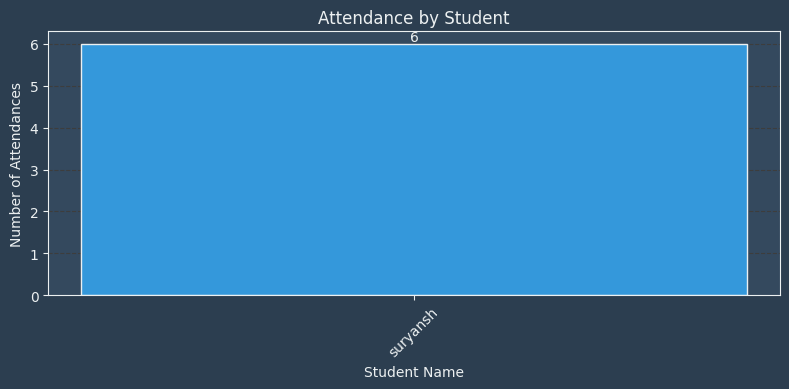

In [1]:
# import cv2
# import pickle
# import numpy as np
# import pandas as pd
# from datetime import datetime, timedelta, time
# from deepface import DeepFace
# from face_recognition import face_encodings, face_distance
# import os
# import tkinter as tk
# from tkinter import ttk, messagebox, filedialog
# from PIL import Image, ImageTk
# import matplotlib.pyplot as plt
# from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# # Configuration
# ENCODINGS_FILE = 'data/encodings.pkl'
# ATTENDANCE_FILE = 'data/attendance.csv'
# TIMETABLE_FILE = 'data/timetable.csv'
# SPOOF_THRESHOLD = 0.7
# RECOGNITION_THRESHOLD = 0.5
# DETECTOR_BACKEND = "opencv"
# ATTENDANCE_INTERVAL = timedelta(hours=1)

# # Sample timetable structure (should be in timetable.csv)
# """
# day,start_time,end_time,subject,expected_students
# Monday,09:00,11:00,Mathematics,Alice;Bob;Charlie
# Monday,11:00,13:00,Physics,Alice;David;Eve
# Tuesday,09:00,11:00,Chemistry,Bob;Charlie;Eve
# """

# class EnhancedFaceRecognitionApp:
#     def __init__(self, root):
#         self.root = root
#         self.root.title("Enhanced Face Recognition Attendance System")
#         self.root.geometry("1200x800")
        
#         # Load data
#         self.known_encodings, self.known_names = self.load_encodings()
#         self.attendance_df = self.load_attendance()
#         self.timetable_df = self.load_timetable()
#         self.recently_recognized = {}
#         self.cap = None
#         self.current_class = None
        
#         # Setup GUI
#         self.setup_gui()
#         self.update_current_class()
        
#     def setup_gui(self):
#         # Create notebook (tabs)
#         self.notebook = ttk.Notebook(self.root)
#         self.notebook.pack(fill=tk.BOTH, expand=True)
        
#         # Tab 1: Live Recognition
#         self.live_tab = ttk.Frame(self.notebook)
#         self.notebook.add(self.live_tab, text="Live Recognition")
#         self.setup_live_tab()
        
#         # Tab 2: Attendance Log
#         self.log_tab = ttk.Frame(self.notebook)
#         self.notebook.add(self.log_tab, text="Attendance Log")
#         self.setup_log_tab()
        
#         # Tab 3: Statistics
#         self.stats_tab = ttk.Frame(self.notebook)
#         self.notebook.add(self.stats_tab, text="Statistics")
#         self.setup_stats_tab()
        
#         # Tab 4: Settings
#         self.settings_tab = ttk.Frame(self.notebook)
#         self.notebook.add(self.settings_tab, text="Settings")
#         self.setup_settings_tab()
        
#         # Status bar
#         self.status_var = tk.StringVar()
#         self.status_var.set("System Ready")
#         self.status_bar = tk.Label(self.root, textvariable=self.status_var, bd=1, relief=tk.SUNKEN, anchor=tk.W)
#         self.status_bar.pack(side=tk.BOTTOM, fill=tk.X)
        
#     def setup_live_tab(self):
#         # Left frame for video and controls
#         left_frame = ttk.Frame(self.live_tab)
#         left_frame.pack(side=tk.LEFT, fill=tk.BOTH, expand=True, padx=10, pady=10)
        
#         # Video frame
#         video_frame = ttk.LabelFrame(left_frame, text="Camera Feed")
#         video_frame.pack(fill=tk.BOTH, expand=True)
        
#         self.video_label = tk.Label(video_frame)
#         self.video_label.pack()
        
#         # Control buttons
#         control_frame = ttk.Frame(left_frame)
#         control_frame.pack(fill=tk.X, pady=5)
        
#         self.start_btn = ttk.Button(control_frame, text="Start", command=self.start_camera)
#         self.start_btn.pack(side=tk.LEFT, padx=5)
        
#         self.stop_btn = ttk.Button(control_frame, text="Stop", command=self.stop_camera, state=tk.DISABLED)
#         self.stop_btn.pack(side=tk.LEFT, padx=5)
        
#         # Right frame for current class info
#         right_frame = ttk.Frame(self.live_tab)
#         right_frame.pack(side=tk.RIGHT, fill=tk.BOTH, padx=10, pady=10)
        
#         # Current class info
#         class_frame = ttk.LabelFrame(right_frame, text="Current Class Information")
#         class_frame.pack(fill=tk.X, pady=5)
        
#         self.class_var = tk.StringVar()
#         self.class_var.set("No class currently scheduled")
#         ttk.Label(class_frame, textvariable=self.class_var, font=('Arial', 12)).pack(pady=5)
        
#         self.expected_var = tk.StringVar()
#         self.expected_var.set("Expected students: ")
#         ttk.Label(class_frame, textvariable=self.expected_var).pack(pady=5)
        
#         self.present_var = tk.StringVar()
#         self.present_var.set("Present: 0")
#         ttk.Label(class_frame, textvariable=self.present_var).pack(pady=5)
        
#         self.absent_var = tk.StringVar()
#         self.absent_var.set("Absent: 0")
#         ttk.Label(class_frame, textvariable=self.absent_var).pack(pady=5)
        
#         # Student list
#         student_frame = ttk.LabelFrame(right_frame, text="Student Status")
#         student_frame.pack(fill=tk.BOTH, expand=True)
        
#         self.student_tree = ttk.Treeview(student_frame, columns=('Name', 'Status'), show='headings')
#         self.student_tree.heading('Name', text='Name')
#         self.student_tree.heading('Status', text='Status')
#         self.student_tree.pack(fill=tk.BOTH, expand=True)
        
#         # Update student list
#         self.update_student_list()
        
#     def setup_log_tab(self):
#         # Main frame
#         main_frame = ttk.Frame(self.log_tab)
#         main_frame.pack(fill=tk.BOTH, expand=True, padx=10, pady=10)
        
#         # Attendance log
#         log_frame = ttk.LabelFrame(main_frame, text="Attendance Records")
#         log_frame.pack(fill=tk.BOTH, expand=True)
        
#         self.tree = ttk.Treeview(log_frame, columns=('Name', 'Timestamp', 'Status', 'Class'), show='headings')
#         self.tree.heading('Name', text='Name')
#         self.tree.heading('Timestamp', text='Timestamp')
#         self.tree.heading('Status', text='Status')
#         self.tree.heading('Class', text='Class')
        
#         # Add scrollbar
#         scrollbar = ttk.Scrollbar(log_frame, orient=tk.VERTICAL, command=self.tree.yview)
#         self.tree.configure(yscroll=scrollbar.set)
#         scrollbar.pack(side=tk.RIGHT, fill=tk.Y)
#         self.tree.pack(fill=tk.BOTH, expand=True)
        
#         # Filter controls
#         filter_frame = ttk.Frame(main_frame)
#         filter_frame.pack(fill=tk.X, pady=5)
        
#         ttk.Label(filter_frame, text="Filter by:").pack(side=tk.LEFT, padx=5)
        
#         self.filter_name_var = tk.StringVar()
#         ttk.Entry(filter_frame, textvariable=self.filter_name_var, width=20).pack(side=tk.LEFT, padx=5)
        
#         self.filter_date_var = tk.StringVar()
#         ttk.Entry(filter_frame, textvariable=self.filter_date_var, width=10).pack(side=tk.LEFT, padx=5)
        
#         filter_btn = ttk.Button(filter_frame, text="Apply Filter", command=self.apply_filters)
#         filter_btn.pack(side=tk.LEFT, padx=5)
        
#         reset_btn = ttk.Button(filter_frame, text="Reset", command=self.reset_filters)
#         reset_btn.pack(side=tk.LEFT, padx=5)
        
#         # Export buttons
#         export_frame = ttk.Frame(main_frame)
#         export_frame.pack(fill=tk.X, pady=5)
        
#         export_csv_btn = ttk.Button(export_frame, text="Export to CSV", command=self.export_to_csv)
#         export_csv_btn.pack(side=tk.LEFT, padx=5)
        
#         export_pdf_btn = ttk.Button(export_frame, text="Export to PDF", command=self.export_to_pdf)
#         export_pdf_btn.pack(side=tk.LEFT, padx=5)
        
#         self.update_attendance_log()
        
#     def setup_stats_tab(self):
#         # Main frame
#         main_frame = ttk.Frame(self.stats_tab)
#         main_frame.pack(fill=tk.BOTH, expand=True, padx=10, pady=10)
        
#         # Statistics frame
#         stats_frame = ttk.LabelFrame(main_frame, text="Attendance Statistics")
#         stats_frame.pack(fill=tk.BOTH, expand=True)
        
#         # Create matplotlib figure
#         self.fig, self.ax = plt.subplots(figsize=(8, 4), dpi=100)
#         self.canvas = FigureCanvasTkAgg(self.fig, master=stats_frame)
#         self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
        
#         # Update stats
#         self.update_statistics()
        
#     def setup_settings_tab(self):
#         # Main frame
#         main_frame = ttk.Frame(self.settings_tab)
#         main_frame.pack(fill=tk.BOTH, expand=True, padx=10, pady=10)
        
#         # Settings controls
#         settings_frame = ttk.LabelFrame(main_frame, text="System Settings")
#         settings_frame.pack(fill=tk.X, pady=5)
        
#         ttk.Label(settings_frame, text="Recognition Threshold:").grid(row=0, column=0, padx=5, pady=5, sticky=tk.W)
#         self.threshold_var = tk.DoubleVar(value=RECOGNITION_THRESHOLD)
#         ttk.Scale(settings_frame, from_=0.1, to=1.0, variable=self.threshold_var, 
#                  command=lambda v: self.update_threshold(float(v))).grid(row=0, column=1, padx=5, pady=5)
        
#         ttk.Label(settings_frame, text="Spoof Threshold:").grid(row=1, column=0, padx=5, pady=5, sticky=tk.W)
#         self.spoof_var = tk.DoubleVar(value=SPOOF_THRESHOLD)
#         ttk.Scale(settings_frame, from_=0.1, to=1.0, variable=self.spoof_var, 
#                  command=lambda v: self.update_spoof_threshold(float(v))).grid(row=1, column=1, padx=5, pady=5)
        
#         # Data management
#         data_frame = ttk.LabelFrame(main_frame, text="Data Management")
#         data_frame.pack(fill=tk.X, pady=5)
        
#         ttk.Button(data_frame, text="Reload Timetable", command=self.reload_timetable).pack(pady=5)
#         ttk.Button(data_frame, text="Backup Attendance", command=self.backup_attendance).pack(pady=5)
        
#     def load_encodings(self):
#         try:
#             with open(ENCODINGS_FILE, 'rb') as f:
#                 data = pickle.load(f)
#             return data['encodings'], data['names']
#         except Exception as e:
#             messagebox.showerror("Error", f"Error loading encodings: {e}")
#             return [], []
    
#     def load_attendance(self):
#         if os.path.exists(ATTENDANCE_FILE):
#             df = pd.read_csv(ATTENDANCE_FILE, parse_dates=['timestamp'])
#             # Add class information if not present
#             if 'class' not in df.columns:
#                 df['class'] = None
#             return df
#         return pd.DataFrame(columns=['name', 'timestamp', 'status', 'class'])
    
#     def load_timetable(self):
#         if os.path.exists(TIMETABLE_FILE):
#             df = pd.read_csv(TIMETABLE_FILE)
#             # Convert time strings to time objects
#             df['start_time'] = pd.to_datetime(df['start_time'], format='%H:%M').dt.time
#             df['end_time'] = pd.to_datetime(df['end_time'], format='%H:%M').dt.time
#             return df
#         return pd.DataFrame(columns=['day', 'start_time', 'end_time', 'subject', 'expected_students'])
    
#     def save_attendance(self):
#         self.attendance_df.to_csv(ATTENDANCE_FILE, index=False)
    
#     def update_current_class(self):
#         now = datetime.now()
#         current_day = now.strftime("%A")
#         current_time = now.time()
        
#         # Find current class
#         current_class = None
#         for _, row in self.timetable_df.iterrows():
#             if row['day'] == current_day and row['start_time'] <= current_time <= row['end_time']:
#                 current_class = row
#                 break
        
#         self.current_class = current_class
        
#         if current_class is not None:
#             self.class_var.set(f"{current_class['subject']} ({current_class['start_time']}-{current_class['end_time']})")
#             expected_students = current_class['expected_students'].split(';')
#             self.expected_var.set(f"Expected students: {', '.join(expected_students)}")
            
#             # Count present students
#             today = now.date()
#             present_students = self.attendance_df[
#                 (self.attendance_df['timestamp'].dt.date == today) &
#                 (self.attendance_df['name'].isin(expected_students)) &
#                 (self.attendance_df['status'] == 'Present')
#             ]['name'].unique()
            
#             absent_students = [s for s in expected_students if s not in present_students]
            
#             self.present_var.set(f"Present: {len(present_students)}/{len(expected_students)}")
#             self.absent_var.set(f"Absent: {len(absent_students)}")
            
#             # Update student list
#             self.update_student_list()
#         else:
#             self.class_var.set("No class currently scheduled")
#             self.expected_var.set("Expected students: -")
#             self.present_var.set("Present: -")
#             self.absent_var.set("Absent: -")
#             self.clear_student_list()
        
#         # Schedule next update
#         self.root.after(60000, self.update_current_class)  # Update every minute
    
#     def update_student_list(self):
#         # Clear existing items
#         for item in self.student_tree.get_children():
#             self.student_tree.delete(item)
        
#         if self.current_class is not None:
#             expected_students = self.current_class['expected_students'].split(';')
#             now = datetime.now()
#             today = now.date()
            
#             for student in expected_students:
#                 # Check if student is present today
#                 present = not self.attendance_df[
#                     (self.attendance_df['name'] == student) &
#                     (self.attendance_df['timestamp'].dt.date == today) &
#                     (self.attendance_df['status'] == 'Present')
#                 ].empty
                
#                 status = "Present" if present else "Absent"
#                 self.student_tree.insert('', 'end', values=(student, status))
    
#     def clear_student_list(self):
#         for item in self.student_tree.get_children():
#             self.student_tree.delete(item)
    
#     def can_mark_attendance(self, name):
#         if name is None or self.current_class is None:
#             return False
        
#         # Check if student is expected in this class
#         expected_students = self.current_class['expected_students'].split(';')
#         if name not in expected_students:
#             return False
        
#         now = datetime.now()
#         last_attendance = self.attendance_df[
#             (self.attendance_df['name'] == name) &
#             (self.attendance_df['timestamp'].dt.date == now.date())
#         ]
        
#         if not last_attendance.empty:
#             last_time = pd.to_datetime(last_attendance['timestamp'].iloc[-1])
#             return now - last_time >= ATTENDANCE_INTERVAL
#         return True
    
#     def mark_attendance(self, name, status):
#         if name is None:
#             return
        
#         now = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
#         class_info = self.current_class['subject'] if self.current_class is not None else None
        
#         new_entry = pd.DataFrame([[name, now, status, class_info]], 
#                                 columns=['name', 'timestamp', 'status', 'class'])
#         self.attendance_df = pd.concat([self.attendance_df, new_entry], ignore_index=True)
#         self.save_attendance()
#         self.update_attendance_log()
#         self.update_statistics()
#         self.update_current_class()  # Refresh current class info
    
#     def extract_face_encodings(self, face_img):
#         rgb_face = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
#         encodings = face_encodings(rgb_face)
#         return encodings[0] if encodings else None
    
#     def recognize_face(self, face_encoding):
#         distances = face_distance(self.known_encodings, face_encoding)
#         best_match_idx = np.argmin(distances)
#         min_distance = distances[best_match_idx]
        
#         if min_distance <= RECOGNITION_THRESHOLD:
#             return self.known_names[best_match_idx], 1 - min_distance
#         return None, None
    
#     def update_attendance_log(self, filter_name=None, filter_date=None):
#         # Clear existing items
#         for i in self.tree.get_children():
#             self.tree.delete(i)
            
#         # Apply filters
#         filtered_df = self.attendance_df.copy()
#         if filter_name:
#             filtered_df = filtered_df[filtered_df['name'].str.contains(filter_name, case=False)]
#         if filter_date:
#             try:
#                 filter_date = pd.to_datetime(filter_date).date()
#                 filtered_df = filtered_df[filtered_df['timestamp'].dt.date == filter_date]
#             except:
#                 pass
        
#         # Add entries
#         for _, row in filtered_df.iterrows():
#             self.tree.insert('', 'end', values=(
#                 row['name'],
#                 row['timestamp'],
#                 row['status'],
#                 row['class'] if pd.notna(row['class']) else '-'
#             ))
    
#     def apply_filters(self):
#         name_filter = self.filter_name_var.get().strip()
#         date_filter = self.filter_date_var.get().strip()
#         self.update_attendance_log(name_filter, date_filter)
    
#     def reset_filters(self):
#         self.filter_name_var.set("")
#         self.filter_date_var.set("")
#         self.update_attendance_log()
    
#     def update_statistics(self):
#         # Clear previous plot
#         self.ax.clear()
        
#         if not self.attendance_df.empty:
#             # Group by name and count presents
#             attendance_stats = self.attendance_df[self.attendance_df['status'] == 'Present']
#             attendance_stats = attendance_stats.groupby('name').size().sort_values(ascending=False)
            
#             # Create bar chart
#             self.ax.bar(attendance_stats.index, attendance_stats.values)
#             self.ax.set_title('Attendance by Student')
#             self.ax.set_xlabel('Student Name')
#             self.ax.set_ylabel('Number of Attendances')
#             self.ax.tick_params(axis='x', rotation=45)
#             self.fig.tight_layout()
        
#         self.canvas.draw()
    
#     def export_to_csv(self):
#         file_path = filedialog.asksaveasfilename(
#             defaultextension=".csv",
#             filetypes=[("CSV files", "*.csv"), ("All files", "*.*")]
#         )
#         if file_path:
#             self.attendance_df.to_csv(file_path, index=False)
#             messagebox.showinfo("Success", f"Attendance data exported to {file_path}")
    
#     def export_to_pdf(self):
#         messagebox.showinfo("Info", "PDF export would be implemented here")
#         # In a real implementation, you would use a library like ReportLab or FPDF
    
#     def update_threshold(self, value):
#         global RECOGNITION_THRESHOLD
#         RECOGNITION_THRESHOLD = value
#         self.status_var.set(f"Recognition threshold updated to {value:.2f}")
    
#     def update_spoof_threshold(self, value):
#         global SPOOF_THRESHOLD
#         SPOOF_THRESHOLD = value
#         self.status_var.set(f"Spoof threshold updated to {value:.2f}")
    
#     def reload_timetable(self):
#         self.timetable_df = self.load_timetable()
#         self.update_current_class()
#         messagebox.showinfo("Success", "Timetable reloaded successfully")
    
#     def backup_attendance(self):
#         backup_path = os.path.join('backups', f'attendance_backup_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv')
#         os.makedirs('backups', exist_ok=True)
#         self.attendance_df.to_csv(backup_path, index=False)
#         messagebox.showinfo("Success", f"Attendance backup created at {backup_path}")
    
#     def start_camera(self):
#         if not self.known_encodings:
#             messagebox.showerror("Error", "No face encodings found!")
#             return
            
#         self.cap = cv2.VideoCapture(0)
#         if not self.cap.isOpened():
#             messagebox.showerror("Error", "Could not open video capture")
#             return
            
#         self.start_btn.config(state=tk.DISABLED)
#         self.stop_btn.config(state=tk.NORMAL)
#         self.status_var.set("Camera started - detecting faces...")
#         self.update_camera()
    
#     def stop_camera(self):
#         if self.cap is not None:
#             self.cap.release()
#             self.cap = None
#             self.video_label.config(image=None)
            
#         self.start_btn.config(state=tk.NORMAL)
#         self.stop_btn.config(state=tk.DISABLED)
#         self.status_var.set("Camera stopped")
    
#     def update_camera(self):
#         if self.cap is None:
#             return
            
#         ret, frame = self.cap.read()
#         if ret:
#             # Detect faces
#             try:
#                 face_objs = DeepFace.extract_faces(
#                     img_path=frame,
#                     detector_backend=DETECTOR_BACKEND,
#                     anti_spoofing=True,
#                     enforce_detection=False
#                 )
#             except Exception as e:
#                 print(f"Face detection error: {e}")
#                 face_objs = []
            
#             for face_obj in face_objs:
#                 x, y, w, h = face_obj["facial_area"]["x"], face_obj["facial_area"]["y"], \
#                              face_obj["facial_area"]["w"], face_obj["facial_area"]["h"]
                
#                 # Check if face is real
#                 is_real = face_obj["is_real"] and (face_obj["antispoof_score"] >= SPOOF_THRESHOLD)
                
#                 if is_real:
#                     # Extract face ROI and get encoding
#                     face_roi = frame[y:y+h, x:x+w]
#                     face_encoding = self.extract_face_encodings(face_roi)
                    
#                     if face_encoding is not None:
#                         # Recognize face
#                         name, confidence = self.recognize_face(face_encoding)
#                         label = f"{name} ({confidence:.2f})" if name else "Unknown"
#                         color = (0, 255, 0)  # Green for recognized
                        
#                         # Check if we should mark attendance
#                         if name and name not in self.recently_recognized:
#                             if self.can_mark_attendance(name):
#                                 self.mark_attendance(name, "Present")
#                                 self.status_var.set(f"Attendance marked for {name}")
#                                 self.recently_recognized[name] = datetime.now()
#                     else:
#                         label = "No encoding"
#                         color = (0, 255, 255)  # Yellow for detection issues
#                 else:
#                     label = f"Spoof ({face_obj['antispoof_score']:.2f})"
#                     color = (0, 0, 255)  # Red for spoofed
                    
#                     # Mark spoofing attempt in log
#                     if "spoof_attempt" not in self.recently_recognized or \
#                        (datetime.now() - self.recently_recognized.get("spoof_attempt", datetime.min)).seconds > 60:
#                         self.mark_attendance("Spoof Attempt", "Spoofed")
#                         self.recently_recognized["spoof_attempt"] = datetime.now()
                
#                 # Draw bounding box and label
#                 cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
#                 cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
            
#             # Clean up recently recognized dictionary
#             current_time = datetime.now()
#             self.recently_recognized = {k: v for k, v in self.recently_recognized.items() 
#                                        if current_time - v < timedelta(minutes=5)}
            
#             # Convert frame to ImageTk format
#             frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#             img = Image.fromarray(frame)
#             imgtk = ImageTk.PhotoImage(image=img)
            
#             # Update the video label
#             self.video_label.imgtk = imgtk
#             self.video_label.configure(image=imgtk)
            
#         # Schedule the next update
#         self.video_label.after(10, self.update_camera)
    
#     def on_closing(self):
#         self.stop_camera()
#         self.root.destroy()

# if __name__ == "__main__":
#     root = tk.Tk()
#     app = EnhancedFaceRecognitionApp(root)
#     root.protocol("WM_DELETE_WINDOW", app.on_closing)
#     root.mainloop()
import cv2
import pickle
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, time
from deepface import DeepFace
from face_recognition import face_encodings, face_distance
import os
import tkinter as tk
from tkinter import ttk, messagebox, filedialog
from PIL import Image, ImageTk
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# Configuration
ENCODINGS_FILE = 'data/encodings.pkl'
ATTENDANCE_FILE = 'data/attendance.csv'
TIMETABLE_FILE = 'data/timetable1.csv'
SPOOF_THRESHOLD = 0.7
RECOGNITION_THRESHOLD = 0.5
DETECTOR_BACKEND = "opencv"
ATTENDANCE_INTERVAL = timedelta(hours=1)

# Color Theme
BG_COLOR = "#2c3e50"
FG_COLOR = "#ecf0f1"
ACCENT_COLOR = "#3498db"
WARNING_COLOR = "#e74c3c"
SUCCESS_COLOR = "#2ecc71"
FRAME_COLOR = "#34495e"

class EnhancedFaceRecognitionApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Interactive Face Recognition System")
        self.root.geometry("1200x800")
        self.root.configure(bg=BG_COLOR)
        
        # Style configuration
        self.style = ttk.Style()
        self.style.theme_use('clam')
        self.configure_styles()
        
        # Load data
        self.known_encodings, self.known_names = self.load_encodings()
        self.attendance_df = self.load_attendance()
        self.timetable_df = self.load_timetable()
        self.recently_recognized = {}
        self.cap = None
        self.current_class = None
        self.running = False
        
        # Setup GUI
        self.setup_gui()
        self.update_current_class()
        
    def configure_styles(self):
        self.style.configure('TFrame', background=BG_COLOR)
        self.style.configure('TLabel', background=BG_COLOR, foreground=FG_COLOR)
        self.style.configure('TButton', background=ACCENT_COLOR, foreground=FG_COLOR, 
                           font=('Helvetica', 10, 'bold'))
        self.style.configure('TNotebook', background=BG_COLOR)
        self.style.configure('TNotebook.Tab', background=FRAME_COLOR, foreground=FG_COLOR,
                           padding=[10, 5], font=('Helvetica', 10, 'bold'))
        self.style.map('TNotebook.Tab', background=[('selected', ACCENT_COLOR)])
        self.style.configure('Treeview', background=FRAME_COLOR, foreground=FG_COLOR,
                           fieldbackground=FRAME_COLOR)
        self.style.configure('Treeview.Heading', background=ACCENT_COLOR, foreground=FG_COLOR)
        self.style.map('Treeview', background=[('selected', '#2980b9')])
        
    def setup_gui(self):
        # Create notebook (tabs)
        self.notebook = ttk.Notebook(self.root)
        self.notebook.pack(fill=tk.BOTH, expand=True, padx=10, pady=10)
        
        # Tab 1: Live Recognition
        self.live_tab = ttk.Frame(self.notebook)
        self.notebook.add(self.live_tab, text="Live Recognition")
        self.setup_live_tab()
        
        # Tab 2: Attendance Log
        self.log_tab = ttk.Frame(self.notebook)
        self.notebook.add(self.log_tab, text="Attendance Log")
        self.setup_log_tab()
        
        # Tab 3: Statistics
        self.stats_tab = ttk.Frame(self.notebook)
        self.notebook.add(self.stats_tab, text="Statistics")
        self.setup_stats_tab()
        
        # Status bar
        self.status_var = tk.StringVar()
        self.status_var.set("System Ready")
        self.status_bar = tk.Label(self.root, textvariable=self.status_var, bd=1, relief=tk.SUNKEN, 
                                 anchor=tk.W, bg=FRAME_COLOR, fg=FG_COLOR, font=('Helvetica', 10))
        self.status_bar.pack(side=tk.BOTTOM, fill=tk.X)
        
    def setup_live_tab(self):
        # Main container
        main_frame = ttk.Frame(self.live_tab)
        main_frame.pack(fill=tk.BOTH, expand=True, padx=10, pady=10)
        
        # Left panel - Video feed
        left_frame = ttk.Frame(main_frame)
        left_frame.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)
        
        video_frame = ttk.LabelFrame(left_frame, text="Camera Feed", padding=10)
        video_frame.pack(fill=tk.BOTH, expand=True)
        
        self.video_label = tk.Label(video_frame, bg='black')
        self.video_label.pack(fill=tk.BOTH, expand=True)
        
        # Control buttons
        control_frame = ttk.Frame(left_frame)
        control_frame.pack(fill=tk.X, pady=10)
        
        self.start_btn = ttk.Button(control_frame, text="▶ Start", command=self.start_camera,
                                  style='Accent.TButton')
        self.start_btn.pack(side=tk.LEFT, padx=5, ipadx=10, ipady=5)
        
        self.stop_btn = ttk.Button(control_frame, text="■ Stop", command=self.stop_camera,
                                 state=tk.DISABLED, style='Accent.TButton')
        self.stop_btn.pack(side=tk.LEFT, padx=5, ipadx=10, ipady=5)
        
        # Right panel - Class info
        right_frame = ttk.Frame(main_frame)
        right_frame.pack(side=tk.RIGHT, fill=tk.BOTH, padx=10)
        
        # Current class info card
        class_card = ttk.LabelFrame(right_frame, text="Current Class", padding=10)
        class_card.pack(fill=tk.X, pady=5)
        
        self.class_var = tk.StringVar()
        self.class_var.set("No class currently scheduled")
        class_label = ttk.Label(class_card, textvariable=self.class_var, 
                              font=('Helvetica', 12, 'bold'), foreground=ACCENT_COLOR)
        class_label.pack(pady=5)
        
        # Info grid
        info_frame = ttk.Frame(class_card)
        info_frame.pack(fill=tk.X)
        
        ttk.Label(info_frame, text="Time:").grid(row=0, column=0, sticky=tk.W, padx=5, pady=2)
        self.time_var = tk.StringVar()
        self.time_var.set("--:-- -- --:-- --")
        ttk.Label(info_frame, textvariable=self.time_var).grid(row=0, column=1, sticky=tk.W, padx=5, pady=2)
        
        ttk.Label(info_frame, text="Expected:").grid(row=1, column=0, sticky=tk.W, padx=5, pady=2)
        self.expected_var = tk.StringVar()
        self.expected_var.set("--")
        ttk.Label(info_frame, textvariable=self.expected_var).grid(row=1, column=1, sticky=tk.W, padx=5, pady=2)
        
        ttk.Label(info_frame, text="Present:").grid(row=2, column=0, sticky=tk.W, padx=5, pady=2)
        self.present_var = tk.StringVar()
        self.present_var.set("--")
        present_label = ttk.Label(info_frame, textvariable=self.present_var, foreground=SUCCESS_COLOR)
        present_label.grid(row=2, column=1, sticky=tk.W, padx=5, pady=2)
        
        ttk.Label(info_frame, text="Absent:").grid(row=3, column=0, sticky=tk.W, padx=5, pady=2)
        self.absent_var = tk.StringVar()
        self.absent_var.set("--")
        absent_label = ttk.Label(info_frame, textvariable=self.absent_var, foreground=WARNING_COLOR)
        absent_label.grid(row=3, column=1, sticky=tk.W, padx=5, pady=2)
        
        # Student list with scrollbar
        list_frame = ttk.LabelFrame(right_frame, text="Student Status", padding=10)
        list_frame.pack(fill=tk.BOTH, expand=True, pady=10)
        
        # Create a canvas and scrollbar
        canvas = tk.Canvas(list_frame, bg=FRAME_COLOR, highlightthickness=0)
        scrollbar = ttk.Scrollbar(list_frame, orient="vertical", command=canvas.yview)
        scrollable_frame = ttk.Frame(canvas)
        
        scrollable_frame.bind(
            "<Configure>",
            lambda e: canvas.configure(
                scrollregion=canvas.bbox("all")
            )
        
        )

        
        canvas.create_window((0, 0), window=scrollable_frame, anchor="nw")
        canvas.configure(yscrollcommand=scrollbar.set)
        
        canvas.pack(side="left", fill="both", expand=True)
        scrollbar.pack(side="right", fill="y")
        
        # Student list will be populated here
        self.student_frame = scrollable_frame
        
    def setup_log_tab(self):
        # Main frame
        main_frame = ttk.Frame(self.log_tab)
        main_frame.pack(fill=tk.BOTH, expand=True, padx=10, pady=10)
        
        # Filter controls
        filter_frame = ttk.Frame(main_frame)
        filter_frame.pack(fill=tk.X, pady=5)
        
        ttk.Label(filter_frame, text="Filter by:").pack(side=tk.LEFT, padx=5)
        
        self.filter_name_var = tk.StringVar()
        name_entry = ttk.Entry(filter_frame, textvariable=self.filter_name_var, width=20)
        name_entry.pack(side=tk.LEFT, padx=5)
        name_entry.bind("<Return>", lambda e: self.apply_filters())
        
        ttk.Label(filter_frame, text="Date:").pack(side=tk.LEFT, padx=5)
        
        self.filter_date_var = tk.StringVar()
        date_entry = ttk.Entry(filter_frame, textvariable=self.filter_date_var, width=10)
        date_entry.pack(side=tk.LEFT, padx=5)
        date_entry.bind("<Return>", lambda e: self.apply_filters())
        
        filter_btn = ttk.Button(filter_frame, text="Apply Filter", command=self.apply_filters)
        filter_btn.pack(side=tk.LEFT, padx=5)
        
        reset_btn = ttk.Button(filter_frame, text="Reset", command=self.reset_filters)
        reset_btn.pack(side=tk.LEFT, padx=5)
        
        # Attendance log
        log_frame = ttk.LabelFrame(main_frame, text="Attendance Records", padding=10)
        log_frame.pack(fill=tk.BOTH, expand=True)
        
        # Create Treeview with scrollbars
        tree_frame = ttk.Frame(log_frame)
        tree_frame.pack(fill=tk.BOTH, expand=True)
        
        self.tree = ttk.Treeview(tree_frame, columns=('Name', 'Timestamp', 'Status', 'Class'), 
                               show='headings', selectmode='browse')
        
        # Configure columns
        self.tree.heading('Name', text='Name')
        self.tree.heading('Timestamp', text='Timestamp')
        self.tree.heading('Status', text='Status')
        self.tree.heading('Class', text='Class')
        
        self.tree.column('Name', width=150)
        self.tree.column('Timestamp', width=180)
        self.tree.column('Status', width=100)
        self.tree.column('Class', width=200)
        
        # Add scrollbars
        y_scroll = ttk.Scrollbar(tree_frame, orient='vertical', command=self.tree.yview)
        x_scroll = ttk.Scrollbar(tree_frame, orient='horizontal', command=self.tree.xview)
        self.tree.configure(yscrollcommand=y_scroll.set, xscrollcommand=x_scroll.set)
        
        # Grid layout
        self.tree.grid(row=0, column=0, sticky='nsew')
        y_scroll.grid(row=0, column=1, sticky='ns')
        x_scroll.grid(row=1, column=0, sticky='ew')
        
        tree_frame.grid_rowconfigure(0, weight=1)
        tree_frame.grid_columnconfigure(0, weight=1)
        
        # Export buttons
        export_frame = ttk.Frame(main_frame)
        export_frame.pack(fill=tk.X, pady=5)
        
        export_csv_btn = ttk.Button(export_frame, text="Export to CSV", command=self.export_to_csv)
        export_csv_btn.pack(side=tk.LEFT, padx=5)
        
        export_pdf_btn = ttk.Button(export_frame, text="Export to PDF", command=self.export_to_pdf)
        export_pdf_btn.pack(side=tk.LEFT, padx=5)
        
        self.update_attendance_log()
        
    def setup_stats_tab(self):
        # Main frame
        main_frame = ttk.Frame(self.stats_tab)
        main_frame.pack(fill=tk.BOTH, expand=True, padx=10, pady=10)
        
        # Stats frame
        stats_frame = ttk.LabelFrame(main_frame, text="Attendance Statistics", padding=10)
        stats_frame.pack(fill=tk.BOTH, expand=True)
        
        # Create matplotlib figure with dark theme
        plt.style.use('dark_background')
        self.fig, self.ax = plt.subplots(figsize=(8, 4), facecolor=FRAME_COLOR)
        self.ax.set_facecolor(FRAME_COLOR)
        
        # Customize colors
        self.fig.patch.set_facecolor(BG_COLOR)
        for spine in self.ax.spines.values():
            spine.set_color(FG_COLOR)
        self.ax.tick_params(colors=FG_COLOR)
        self.ax.xaxis.label.set_color(FG_COLOR)
        self.ax.yaxis.label.set_color(FG_COLOR)
        self.ax.title.set_color(FG_COLOR)
        
        self.canvas = FigureCanvasTkAgg(self.fig, master=stats_frame)
        self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
        
        # Update stats
        self.update_statistics()
        
    def load_encodings(self):
        try:
            with open(ENCODINGS_FILE, 'rb') as f:
                data = pickle.load(f)
            return data['encodings'], data['names']
        except Exception as e:
            messagebox.showerror("Error", f"Error loading encodings: {e}")
            return [], []
    
    def load_attendance(self):
        if os.path.exists(ATTENDANCE_FILE):
            df = pd.read_csv(ATTENDANCE_FILE, parse_dates=['timestamp'])
            if 'class' not in df.columns:
                df['class'] = None
            return df
        return pd.DataFrame(columns=['name', 'timestamp', 'status', 'class'])
    
    def load_timetable(self):
        if os.path.exists(TIMETABLE_FILE):
            df = pd.read_csv(TIMETABLE_FILE)
            df['start_time'] = pd.to_datetime(df['start_time'], format='%H:%M').dt.time
            df['end_time'] = pd.to_datetime(df['end_time'], format='%H:%M').dt.time
            return df
        return pd.DataFrame(columns=['day', 'start_time', 'end_time', 'subject', 'expected_students'])
    
    def save_attendance(self):
        self.attendance_df.to_csv(ATTENDANCE_FILE, index=False)
    
    def update_current_class(self):
        now = datetime.now()
        current_day = now.strftime("%A")
        current_time = now.time()
        
        # Find current class
        current_class = None
        for _, row in self.timetable_df.iterrows():
            if row['day'] == current_day and row['start_time'] <= current_time <= row['end_time']:
                current_class = row
                break
        
        self.current_class = current_class
        
        if current_class is not None:
            # Update class info
            self.class_var.set(f"{current_class['subject']}")
            time_str = f"{current_class['start_time'].strftime('%I:%M %p')} - {current_class['end_time'].strftime('%I:%M %p')}"
            self.time_var.set(time_str)
            
            # Process expected students
            expected_students = current_class['expected_students'].split(';')
            self.expected_var.set(f"{len(expected_students)} students")
            
            # Count present students
            today = now.date()
            present_students = self.attendance_df[
                (self.attendance_df['timestamp'].dt.date == today) &
                (self.attendance_df['name'].isin(expected_students)) &
                (self.attendance_df['status'] == 'Present')
            ]['name'].unique()
            
            absent_students = [s for s in expected_students if s not in present_students]
            
            self.present_var.set(f"{len(present_students)}")
            self.absent_var.set(f"{len(absent_students)}")
            
            # Update student list
            self.update_student_list(expected_students, present_students)
        else:
            self.class_var.set("No class scheduled")
            self.time_var.set("--:-- -- --:-- --")
            self.expected_var.set("--")
            self.present_var.set("--")
            self.absent_var.set("--")
            self.clear_student_list()
        
        # Schedule next update
        self.root.after(60000, self.update_current_class)
    
    def update_student_list(self, expected_students, present_students):
        # Clear existing widgets
        for widget in self.student_frame.winfo_children():
            widget.destroy()
        
        # Create student cards
        for student in expected_students:
            is_present = student in present_students
            
            card = ttk.Frame(self.student_frame, style='Card.TFrame')
            card.pack(fill=tk.X, pady=2, padx=5)
            
            # Status indicator
            status_canvas = tk.Canvas(card, width=20, height=20, bg=FRAME_COLOR, highlightthickness=0)
            status_canvas.pack(side=tk.LEFT, padx=5)
            
            if is_present:
                status_canvas.create_oval(2, 2, 18, 18, fill=SUCCESS_COLOR, outline=SUCCESS_COLOR)
            else:
                status_canvas.create_oval(2, 2, 18, 18, fill=WARNING_COLOR, outline=WARNING_COLOR)
            
            # Student name
            name_label = ttk.Label(card, text=student, style='Card.TLabel')
            name_label.pack(side=tk.LEFT, fill=tk.X, expand=True)
            
            # Status text
            status_text = "Present" if is_present else "Absent"
            status_label = ttk.Label(card, text=status_text, 
                                  style=('Card.Success.TLabel' if is_present else 'Card.Warning.TLabel'))
            status_label.pack(side=tk.RIGHT, padx=10)
    
    def clear_student_list(self):
        for widget in self.student_frame.winfo_children():
            widget.destroy()
    
    def can_mark_attendance(self, name):
        if name is None or self.current_class is None:
            return False
        
        expected_students = self.current_class['expected_students'].split(';')
        if name not in expected_students:
            return False
        
        now = datetime.now()
        last_attendance = self.attendance_df[
            (self.attendance_df['name'] == name) &
            (self.attendance_df['timestamp'].dt.date == now.date())
        ]
        
        if not last_attendance.empty:
            last_time = pd.to_datetime(last_attendance['timestamp'].iloc[-1])
            return now - last_time >= ATTENDANCE_INTERVAL
        return True
    
    def mark_attendance(self, name, status):
        if name is None:
            return
        
        now = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        class_info = self.current_class['subject'] if self.current_class is not None else None
        
        new_entry = pd.DataFrame([[name, now, status, class_info]], 
                                columns=['name', 'timestamp', 'status', 'class'])
        self.attendance_df = pd.concat([self.attendance_df, new_entry], ignore_index=True)
        self.save_attendance()
        self.update_attendance_log()
        self.update_statistics()
        self.update_current_class()
    
    def update_attendance_log(self, filter_name=None, filter_date=None):
        for i in self.tree.get_children():
            self.tree.delete(i)
            
        filtered_df = self.attendance_df.copy()
        if filter_name:
            filtered_df = filtered_df[filtered_df['name'].str.contains(filter_name, case=False)]
        if filter_date:
            try:
                filter_date = pd.to_datetime(filter_date).date()
                filtered_df = filtered_df[filtered_df['timestamp'].dt.date == filter_date]
            except:
                pass
        
        for _, row in filtered_df.iterrows():
            status = row['status']
            tags = ('present',) if status == 'Present' else ('absent',) if status == 'Absent' else ('spoof',)
            
            self.tree.insert('', 'end', values=(
                row['name'],
                row['timestamp'],
                status,
                row['class'] if pd.notna(row['class']) else '-'
            ), tags=tags)
        
        # Configure tag colors
        self.tree.tag_configure('present', foreground=SUCCESS_COLOR)
        self.tree.tag_configure('absent', foreground=WARNING_COLOR)
        self.tree.tag_configure('spoof', foreground='#e67e22')
    
    def apply_filters(self):
        name_filter = self.filter_name_var.get().strip()
        date_filter = self.filter_date_var.get().strip()
        self.update_attendance_log(name_filter, date_filter)
    
    def reset_filters(self):
        self.filter_name_var.set("")
        self.filter_date_var.set("")
        self.update_attendance_log()
    
    def update_statistics(self):
        self.ax.clear()
        
        if not self.attendance_df.empty:
            # Group by name and count presents
            attendance_stats = self.attendance_df[self.attendance_df['status'] == 'Present']
            if not attendance_stats.empty:
                attendance_stats = attendance_stats.groupby('name').size().sort_values(ascending=False)
                
                # Create bar chart with custom colors
                bars = self.ax.bar(attendance_stats.index, attendance_stats.values, 
                                 color=ACCENT_COLOR, edgecolor=FG_COLOR)
                
                # Add value labels
                for bar in bars:
                    height = bar.get_height()
                    self.ax.text(bar.get_x() + bar.get_width()/2., height,
                                f'{int(height)}', ha='center', va='bottom',
                                color=FG_COLOR)
                
                self.ax.set_title('Attendance by Student', color=FG_COLOR)
                self.ax.set_xlabel('Student Name', color=FG_COLOR)
                self.ax.set_ylabel('Number of Attendances', color=FG_COLOR)
                self.ax.tick_params(axis='x', rotation=45, colors=FG_COLOR)
                self.ax.tick_params(axis='y', colors=FG_COLOR)
                
                # Set grid
                self.ax.grid(True, color='#3d3d3d', linestyle='--')
                self.ax.set_axisbelow(True)
                
                self.fig.tight_layout()
        
        self.canvas.draw()
    
    def export_to_csv(self):
        file_path = filedialog.asksaveasfilename(
            defaultextension=".csv",
            filetypes=[("CSV files", "*.csv"), ("All files", "*.*")]
        )
        if file_path:
            self.attendance_df.to_csv(file_path, index=False)
            messagebox.showinfo("Success", f"Attendance data exported to {file_path}")
    
    def export_to_pdf(self):
        messagebox.showinfo("Info", "PDF export would be implemented here")
    
    def start_camera(self):
        if not self.known_encodings:
            messagebox.showerror("Error", "No face encodings found!")
            return
            
        self.cap = cv2.VideoCapture(0)
        if not self.cap.isOpened():
            messagebox.showerror("Error", "Could not open video capture")
            return
            
        self.start_btn.config(state=tk.DISABLED)
        self.stop_btn.config(state=tk.NORMAL)
        self.status_var.set("Camera started - detecting faces...")
        self.running = True
        self.update_camera()
    
    def stop_camera(self):
        self.running = False
        if self.cap is not None:
            self.cap.release()
            self.cap = None
            self.video_label.config(image=None)
            
        self.start_btn.config(state=tk.NORMAL)
        self.stop_btn.config(state=tk.DISABLED)
        self.status_var.set("Camera stopped")
    
    def update_camera(self):
        if not self.running:
            return
            
        ret, frame = self.cap.read()
        if ret:
            # Detect faces
            try:
                face_objs = DeepFace.extract_faces(
                    img_path=frame,
                    detector_backend=DETECTOR_BACKEND,
                    anti_spoofing=True,
                    enforce_detection=False
                )
            except Exception as e:
                print(f"Face detection error: {e}")
                face_objs = []
            
            for face_obj in face_objs:
                x, y, w, h = face_obj["facial_area"]["x"], face_obj["facial_area"]["y"], \
                             face_obj["facial_area"]["w"], face_obj["facial_area"]["h"]
                
                # Check if face is real
                is_real = face_obj["is_real"] and (face_obj["antispoof_score"] >= SPOOF_THRESHOLD)
                
                if is_real:
                    # Extract face ROI and get encoding
                    face_roi = frame[y:y+h, x:x+w]
                    face_encoding = self.extract_face_encodings(face_roi)
                    
                    if face_encoding is not None:
                        # Recognize face
                        name, confidence = self.recognize_face(face_encoding)
                        label = f"{name} ({confidence:.2f})" if name else "Unknown"
                        color = (0, 255, 0)  # Green for recognized
                        
                        # Check if we should mark attendance
                        if name and name not in self.recently_recognized:
                            if self.can_mark_attendance(name):
                                self.mark_attendance(name, "Present")
                                self.status_var.set(f"Attendance marked for {name}")
                                self.recently_recognized[name] = datetime.now()
                    else:
                        label = "No encoding"
                        color = (0, 255, 255)  # Yellow for detection issues
                else:
                    label = f"Spoof ({face_obj['antispoof_score']:.2f})"
                    color = (0, 0, 255)  # Red for spoofed
                    
                    # Mark spoofing attempt in log
                    if "spoof_attempt" not in self.recently_recognized or \
                       (datetime.now() - self.recently_recognized.get("spoof_attempt", datetime.min)).seconds > 60:
                        self.mark_attendance("Spoof Attempt", "Spoofed")
                        self.recently_recognized["spoof_attempt"] = datetime.now()
                
                # Draw bounding box and label
                cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
                cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
            
            # Clean up recently recognized dictionary
            current_time = datetime.now()
            self.recently_recognized = {k: v for k, v in self.recently_recognized.items() 
                                       if current_time - v < timedelta(minutes=5)}
            
            # Convert frame to ImageTk format
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            img = Image.fromarray(frame)
            imgtk = ImageTk.PhotoImage(image=img)
            
            # Update the video label
            self.video_label.imgtk = imgtk
            self.video_label.configure(image=imgtk)
            
        # Schedule the next update
        self.video_label.after(10, self.update_camera)
    
    def recognize_face(self, face_encoding):
        distances = face_distance(self.known_encodings, face_encoding)
        best_match_idx = np.argmin(distances)
        min_distance = distances[best_match_idx]
        
        if min_distance <= RECOGNITION_THRESHOLD:
            return self.known_names[best_match_idx], 1 - min_distance
        return None, None
    
    def on_closing(self):
        self.stop_camera()
        self.root.destroy()

if __name__ == "__main__":
    root = tk.Tk()
    
    # Additional style configurations
    style = ttk.Style()
    style.configure('Card.TFrame', background=FRAME_COLOR)
    style.configure('Card.TLabel', background=FRAME_COLOR, foreground=FG_COLOR)
    style.configure('Card.Success.TLabel', background=FRAME_COLOR, foreground=SUCCESS_COLOR)
    style.configure('Card.Warning.TLabel', background=FRAME_COLOR, foreground=WARNING_COLOR)
    style.configure('Accent.TButton', background=ACCENT_COLOR, foreground=FG_COLOR, 
                   font=('Helvetica', 10, 'bold'))
    
    app = EnhancedFaceRecognitionApp(root)
    root.protocol("WM_DELETE_WINDOW", app.on_closing)
    root.mainloop()

KeyError: 'class_name'

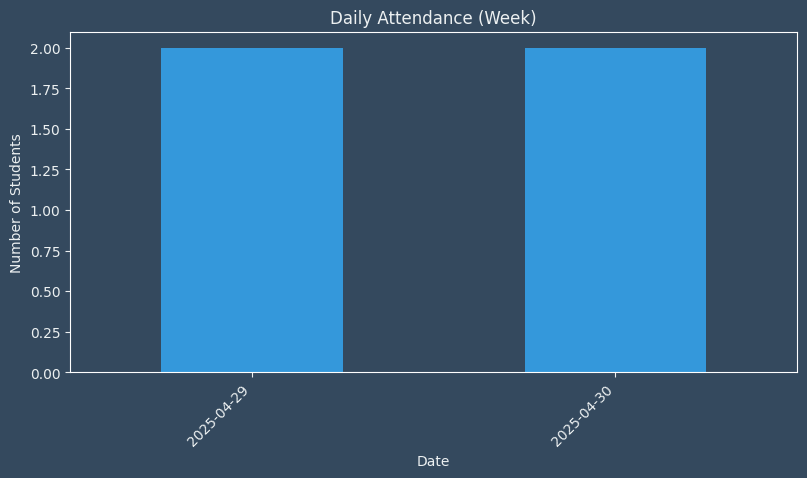

In [ ]:
import cv2
import pickle
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, time
from deepface import DeepFace
from face_recognition import face_encodings, face_distance
import os
import tkinter as tk
from tkinter import ttk, messagebox, filedialog
from PIL import Image, ImageTk
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import threading
import queue
import time as time_module

# Configuration
ENCODINGS_FILE = 'data/encodings.pkl'
ATTENDANCE_FILE = 'data/attendance.csv'
TIMETABLE_FILE = 'data/timetable.csv'
SPOOF_THRESHOLD = 0.7
RECOGNITION_THRESHOLD = 0.5
DETECTOR_BACKEND = "opencv"
ATTENDANCE_INTERVAL = timedelta(hours=1)
CAMERA_WIDTH = 640  # Reduced resolution for better performance
CAMERA_HEIGHT = 480
PROCESS_EVERY_N_FRAMES = 3  # Process every 3rd frame to reduce load

# Color Theme
BG_COLOR = "#2c3e50"
FG_COLOR = "#ecf0f1"
ACCENT_COLOR = "#3498db"
WARNING_COLOR = "#e74c3c"
SUCCESS_COLOR = "#2ecc71"
FRAME_COLOR = "#34495e"

class FaceRecognitionThread(threading.Thread):
    def __init__(self, video_capture, encodings, names):
        threading.Thread.__init__(self)
        self.video_capture = video_capture
        self.known_encodings = encodings
        self.known_names = names
        self.frame_queue = queue.Queue(maxsize=1)  # Only keep the latest frame
        self.result_queue = queue.Queue()
        self.running = True
        self.frame_count = 0
        
    def run(self):
        while self.running:
            try:
                # Get frame from queue
                frame = self.frame_queue.get(timeout=0.1)
                self.frame_count += 1
                
                # Skip processing if not our target frame
                if self.frame_count % PROCESS_EVERY_N_FRAMES != 0:
                    continue
                
                # Detect faces
                try:
                    face_objs = DeepFace.extract_faces(
                        img_path=frame,
                        detector_backend=DETECTOR_BACKEND,
                        anti_spoofing=True,
                        enforce_detection=False
                    )
                except Exception as e:
                    print(f"Face detection error: {e}")
                    face_objs = []
                
                results = []
                for face_obj in face_objs:
                    x, y, w, h = face_obj["facial_area"]["x"], face_obj["facial_area"]["y"], \
                                 face_obj["facial_area"]["w"], face_obj["facial_area"]["h"]
                    
                    # Check if face is real
                    is_real = face_obj["is_real"] and (face_obj["antispoof_score"] >= SPOOF_THRESHOLD)
                    
                    if is_real:
                        # Extract face ROI and get encoding
                        face_roi = frame[y:y+h, x:x+w]
                        face_encoding = self.extract_face_encodings(face_roi)
                        
                        if face_encoding is not None:
                            # Recognize face
                            name, confidence = self.recognize_face(face_encoding)
                            results.append({
                                "coords": (x, y, w, h),
                                "label": f"{name} ({confidence:.2f})" if name else "Unknown",
                                "color": (0, 255, 0) if name else (0, 255, 255),
                                "name": name,
                                "is_real": True
                            })
                    else:
                        results.append({
                            "coords": (x, y, w, h),
                            "label": f"Spoof ({face_obj['antispoof_score']:.2f})",
                            "color": (0, 0, 255),
                            "name": None,
                            "is_real": False
                        })
                
                # Put results in queue
                self.result_queue.put((frame, results))
                
            except queue.Empty:
                continue
                
    def extract_face_encodings(self, face_img):
        rgb_face = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
        encodings = face_encodings(rgb_face)
        return encodings[0] if encodings else None
    
    def recognize_face(self, face_encoding):
        distances = face_distance(self.known_encodings, face_encoding)
        best_match_idx = np.argmin(distances)
        min_distance = distances[best_match_idx]
        
        if min_distance <= RECOGNITION_THRESHOLD:
            return self.known_names[best_match_idx], 1 - min_distance
        return None, None
    
    def stop(self):
        self.running = False

class EnhancedFaceRecognitionApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Interactive Face Recognition System")
        self.root.geometry("1200x800")
        self.root.configure(bg=BG_COLOR)
        
        # Style configuration
        self.style = ttk.Style()
        self.style.theme_use('clam')
        self.configure_styles()
        
        # Load data
        self.known_encodings, self.known_names = self.load_encodings()
        self.attendance_df = self.load_attendance()
        self.timetable_df = self.load_timetable()
        self.recently_recognized = {}
        self.cap = None
        self.current_class = None
        self.running = False
        self.recognition_thread = None
        
        # Setup GUI
        self.setup_gui()
        self.update_current_class()
        
    def configure_styles(self):
        self.style.configure('TFrame', background=BG_COLOR)
        self.style.configure('TLabel', background=BG_COLOR, foreground=FG_COLOR)
        self.style.configure('TButton', background=ACCENT_COLOR, foreground=FG_COLOR, 
                           font=('Helvetica', 10, 'bold'))
        self.style.configure('TNotebook', background=BG_COLOR)
        self.style.configure('TNotebook.Tab', background=FRAME_COLOR, foreground=FG_COLOR,
                           padding=[10, 5], font=('Helvetica', 10, 'bold'))
        self.style.map('TNotebook.Tab', background=[('selected', ACCENT_COLOR)])
        self.style.configure('Treeview', background=FRAME_COLOR, foreground=FG_COLOR,
                           fieldbackground=FRAME_COLOR)
        self.style.configure('Treeview.Heading', background=ACCENT_COLOR, foreground=FG_COLOR)
        self.style.map('Treeview', background=[('selected', '#2980b9')])
        
    def setup_gui(self):
        # Create notebook (tabs)
        self.notebook = ttk.Notebook(self.root)
        self.notebook.pack(fill=tk.BOTH, expand=True, padx=10, pady=10)
        
        # Tab 1: Live Recognition
        self.live_tab = ttk.Frame(self.notebook)
        self.notebook.add(self.live_tab, text="Live Recognition")
        self.setup_live_tab()
        
        # Tab 2: Attendance Log
        self.log_tab = ttk.Frame(self.notebook)
        self.notebook.add(self.log_tab, text="Attendance Log")
        self.setup_log_tab()
        
        # Tab 3: Statistics
        self.stats_tab = ttk.Frame(self.notebook)
        self.notebook.add(self.stats_tab, text="Statistics")
        self.setup_stats_tab()
        
        # Status bar
        self.status_var = tk.StringVar()
        self.status_var.set("System Ready")
        self.status_bar = tk.Label(self.root, textvariable=self.status_var, bd=1, relief=tk.SUNKEN, 
                                 anchor=tk.W, bg=FRAME_COLOR, fg=FG_COLOR, font=('Helvetica', 10))
        self.status_bar.pack(side=tk.BOTTOM, fill=tk.X)
        
    def setup_live_tab(self):
        # Main container
        main_frame = ttk.Frame(self.live_tab)
        main_frame.pack(fill=tk.BOTH, expand=True, padx=10, pady=10)
        
        # Left panel - Video feed
        left_frame = ttk.Frame(main_frame)
        left_frame.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)
        
        video_frame = ttk.LabelFrame(left_frame, text="Camera Feed", padding=10)
        video_frame.pack(fill=tk.BOTH, expand=True)
        
        self.video_label = tk.Label(video_frame, bg='black')
        self.video_label.pack(fill=tk.BOTH, expand=True)
        
        # Control buttons
        control_frame = ttk.Frame(left_frame)
        control_frame.pack(fill=tk.X, pady=10)
        
        self.start_btn = ttk.Button(control_frame, text="▶ Start", command=self.start_camera,
                                  style='Accent.TButton')
        self.start_btn.pack(side=tk.LEFT, padx=5, ipadx=10, ipady=5)
        
        self.stop_btn = ttk.Button(control_frame, text="■ Stop", command=self.stop_camera,
                                 state=tk.DISABLED, style='Accent.TButton')
        self.stop_btn.pack(side=tk.LEFT, padx=5, ipadx=10, ipady=5)
        
        # Right panel - Class info
        right_frame = ttk.Frame(main_frame)
        right_frame.pack(side=tk.RIGHT, fill=tk.BOTH, padx=10)
        
        # Current class info card
        class_card = ttk.LabelFrame(right_frame, text="Current Class", padding=10)
        class_card.pack(fill=tk.X, pady=5)
        
        self.class_var = tk.StringVar()
        self.class_var.set("No class currently scheduled")
        class_label = ttk.Label(class_card, textvariable=self.class_var, 
                              font=('Helvetica', 12, 'bold'), foreground=ACCENT_COLOR)
        class_label.pack(pady=5)
        
        # Info grid
        info_frame = ttk.Frame(class_card)
        info_frame.pack(fill=tk.X)
        
        ttk.Label(info_frame, text="Time:").grid(row=0, column=0, sticky=tk.W, padx=5, pady=2)
        self.time_var = tk.StringVar()
        self.time_var.set("--:-- -- --:-- --")
        ttk.Label(info_frame, textvariable=self.time_var).grid(row=0, column=1, sticky=tk.W, padx=5, pady=2)
        
        ttk.Label(info_frame, text="Expected:").grid(row=1, column=0, sticky=tk.W, padx=5, pady=2)
        self.expected_var = tk.StringVar()
        self.expected_var.set("--")
        ttk.Label(info_frame, textvariable=self.expected_var).grid(row=1, column=1, sticky=tk.W, padx=5, pady=2)
        
        ttk.Label(info_frame, text="Present:").grid(row=2, column=0, sticky=tk.W, padx=5, pady=2)
        self.present_var = tk.StringVar()
        self.present_var.set("--")
        present_label = ttk.Label(info_frame, textvariable=self.present_var, foreground=SUCCESS_COLOR)
        present_label.grid(row=2, column=1, sticky=tk.W, padx=5, pady=2)
        
        ttk.Label(info_frame, text="Absent:").grid(row=3, column=0, sticky=tk.W, padx=5, pady=2)
        self.absent_var = tk.StringVar()
        self.absent_var.set("--")
        absent_label = ttk.Label(info_frame, textvariable=self.absent_var, foreground=WARNING_COLOR)
        absent_label.grid(row=3, column=1, sticky=tk.W, padx=5, pady=2)
        
        # Student list with scrollbar
        list_frame = ttk.LabelFrame(right_frame, text="Student Status", padding=10)
        list_frame.pack(fill=tk.BOTH, expand=True, pady=10)
        
        # Create a canvas and scrollbar
        canvas = tk.Canvas(list_frame, bg=FRAME_COLOR, highlightthickness=0)
        scrollbar = ttk.Scrollbar(list_frame, orient="vertical", command=canvas.yview)
        scrollable_frame = ttk.Frame(canvas)
        
        scrollable_frame.bind(
            "<Configure>",
            lambda e: canvas.configure(
                scrollregion=canvas.bbox("all")
            )
        )
        
        canvas.create_window((0, 0), window=scrollable_frame, anchor="nw")
        canvas.configure(yscrollcommand=scrollbar.set)
        
        canvas.pack(side="left", fill="both", expand=True)
        scrollbar.pack(side="right", fill="y")
        
        # Student list will be populated here
        self.student_frame = scrollable_frame
        
    def setup_log_tab(self):
        # Main frame
        main_frame = ttk.Frame(self.log_tab)
        main_frame.pack(fill=tk.BOTH, expand=True, padx=10, pady=10)
        
        # Filter controls
        filter_frame = ttk.Frame(main_frame)
        filter_frame.pack(fill=tk.X, pady=5)
        
        ttk.Label(filter_frame, text="Filter by:").pack(side=tk.LEFT, padx=5)
        
        self.filter_name_var = tk.StringVar()
        name_entry = ttk.Entry(filter_frame, textvariable=self.filter_name_var, width=20)
        name_entry.pack(side=tk.LEFT, padx=5)
        name_entry.bind("<Return>", lambda e: self.apply_filters())
        
        ttk.Label(filter_frame, text="Date:").pack(side=tk.LEFT, padx=5)
        
        self.filter_date_var = tk.StringVar()
        date_entry = ttk.Entry(filter_frame, textvariable=self.filter_date_var, width=10)
        date_entry.pack(side=tk.LEFT, padx=5)
        date_entry.bind("<Return>", lambda e: self.apply_filters())
        
        filter_btn = ttk.Button(filter_frame, text="Apply Filter", command=self.apply_filters)
        filter_btn.pack(side=tk.LEFT, padx=5)
        
        reset_btn = ttk.Button(filter_frame, text="Reset", command=self.reset_filters)
        reset_btn.pack(side=tk.LEFT, padx=5)
        
        # Attendance log
        log_frame = ttk.LabelFrame(main_frame, text="Attendance Records", padding=10)
        log_frame.pack(fill=tk.BOTH, expand=True)
        
        # Create Treeview with scrollbars
        tree_frame = ttk.Frame(log_frame)
        tree_frame.pack(fill=tk.BOTH, expand=True)
        
        self.tree = ttk.Treeview(tree_frame, columns=('Name', 'Timestamp', 'Status', 'Class'), 
                               show='headings', selectmode='browse')
        
        # Configure columns
        self.tree.heading('Name', text='Name')
        self.tree.heading('Timestamp', text='Timestamp')
        self.tree.heading('Status', text='Status')
        self.tree.heading('Class', text='Class')
        
        self.tree.column('Name', width=150)
        self.tree.column('Timestamp', width=180)
        self.tree.column('Status', width=100)
        self.tree.column('Class', width=200)
        
        # Add scrollbars
        y_scroll = ttk.Scrollbar(tree_frame, orient='vertical', command=self.tree.yview)
        x_scroll = ttk.Scrollbar(tree_frame, orient='horizontal', command=self.tree.xview)
        self.tree.configure(yscrollcommand=y_scroll.set, xscrollcommand=x_scroll.set)
        
        # Grid layout
        self.tree.grid(row=0, column=0, sticky='nsew')
        y_scroll.grid(row=0, column=1, sticky='ns')
        x_scroll.grid(row=1, column=0, sticky='ew')
        
        tree_frame.grid_rowconfigure(0, weight=1)
        tree_frame.grid_columnconfigure(0, weight=1)
        
        # Export buttons
        export_frame = ttk.Frame(main_frame)
        export_frame.pack(fill=tk.X, pady=5)
        
        export_csv_btn = ttk.Button(export_frame, text="Export to CSV", command=self.export_to_csv)
        export_csv_btn.pack(side=tk.LEFT, padx=5)
        
        export_pdf_btn = ttk.Button(export_frame, text="Export to PDF", command=self.export_to_pdf)
        export_pdf_btn.pack(side=tk.LEFT, padx=5)
        
        self.update_attendance_log()
        
    def setup_stats_tab(self):
        # Main frame
        main_frame = ttk.Frame(self.stats_tab)
        main_frame.pack(fill=tk.BOTH, expand=True, padx=10, pady=10)
        
        # Stats frame
        stats_frame = ttk.LabelFrame(main_frame, text="Attendance Statistics", padding=10)
        stats_frame.pack(fill=tk.BOTH, expand=True)
        
        # Create matplotlib figure with dark theme
        plt.style.use('dark_background')
        self.fig, self.ax = plt.subplots(figsize=(8, 4), facecolor=FRAME_COLOR)
        self.ax.set_facecolor(FRAME_COLOR)
        self.fig.tight_layout()
        
        # Embed the figure in Tkinter
        self.canvas = FigureCanvasTkAgg(self.fig, master=stats_frame)
        self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
        
        # Controls frame
        controls_frame = ttk.Frame(stats_frame)
        controls_frame.pack(fill=tk.X, pady=10)
        
        ttk.Label(controls_frame, text="Time Period:").pack(side=tk.LEFT, padx=5)
        
        self.stats_period_var = tk.StringVar(value="week")
        periods = [("Last Week", "week"), ("Last Month", "month"), ("Last Year", "year"), ("All Time", "all")]
        
        for text, value in periods:
            rb = ttk.Radiobutton(controls_frame, text=text, variable=self.stats_period_var, 
                                value=value, command=self.update_stats)
            rb.pack(side=tk.LEFT, padx=5)
        
        # Summary frame
        summary_frame = ttk.LabelFrame(main_frame, text="Summary Statistics", padding=10)
        summary_frame.pack(fill=tk.BOTH, pady=10)
        
        # Summary stats labels
        stats_grid = ttk.Frame(summary_frame)
        stats_grid.pack(fill=tk.BOTH, expand=True)
        
        ttk.Label(stats_grid, text="Total Students:").grid(row=0, column=0, sticky=tk.W, padx=5, pady=2)
        self.total_students_var = tk.StringVar(value="0")
        ttk.Label(stats_grid, textvariable=self.total_students_var).grid(row=0, column=1, sticky=tk.W, padx=5, pady=2)
        
        ttk.Label(stats_grid, text="Avg. Attendance:").grid(row=1, column=0, sticky=tk.W, padx=5, pady=2)
        self.avg_attendance_var = tk.StringVar(value="0%")
        ttk.Label(stats_grid, textvariable=self.avg_attendance_var).grid(row=1, column=1, sticky=tk.W, padx=5, pady=2)
        
        ttk.Label(stats_grid, text="Most Punctual:").grid(row=2, column=0, sticky=tk.W, padx=5, pady=2)
        self.most_punctual_var = tk.StringVar(value="None")
        ttk.Label(stats_grid, textvariable=self.most_punctual_var).grid(row=2, column=1, sticky=tk.W, padx=5, pady=2)
        
        ttk.Label(stats_grid, text="Least Punctual:").grid(row=3, column=0, sticky=tk.W, padx=5, pady=2)
        self.least_punctual_var = tk.StringVar(value="None")
        ttk.Label(stats_grid, textvariable=self.least_punctual_var).grid(row=3, column=1, sticky=tk.W, padx=5, pady=2)
        
        # Initial update
        self.update_stats()
        
    def update_stats(self):
        """Update the statistics display based on selected time period"""
        period = self.stats_period_var.get()
        now = datetime.now()
        
        # Filter data based on time period
        if period == "week":
            start_date = now - timedelta(days=7)
            df = self.attendance_df[self.attendance_df['timestamp'] >= start_date]
        elif period == "month":
            start_date = now - timedelta(days=30)
            df = self.attendance_df[self.attendance_df['timestamp'] >= start_date]
        elif period == "year":
            start_date = now - timedelta(days=365)
            df = self.attendance_df[self.attendance_df['timestamp'] >= start_date]
        else:
            df = self.attendance_df.copy()
        
        if df.empty:
            self.ax.clear()
            self.ax.text(0.5, 0.5, 'No data available', ha='center', va='center')
            self.canvas.draw()
            
            self.total_students_var.set("0")
            self.avg_attendance_var.set("0%")
            self.most_punctual_var.set("None")
            self.least_punctual_var.set("None")
            return
        
        # Plot attendance by day
        self.ax.clear()
        
        # Group by date and count unique students
        daily_attendance = df.groupby(df['timestamp'].dt.date)['name'].nunique()
        daily_attendance.plot(kind='bar', ax=self.ax, color=ACCENT_COLOR)
        
        self.ax.set_title(f"Daily Attendance ({period.capitalize()})", color=FG_COLOR)
        self.ax.set_xlabel("Date", color=FG_COLOR)
        self.ax.set_ylabel("Number of Students", color=FG_COLOR)
        self.ax.tick_params(colors=FG_COLOR)
        
        # Rotate x-axis labels for better readability
        for label in self.ax.get_xticklabels():
            label.set_rotation(45)
            label.set_ha('right')
        
        self.canvas.draw()
        
        # Update summary statistics
        unique_students = df['name'].nunique()
        total_classes = df['class'].nunique()
        
        if total_classes > 0:
            avg_attendance = (len(df) / (unique_students * total_classes)) * 100
        else:
            avg_attendance = 0
        
        # Calculate punctuality (students with most and least attendance)
        student_attendance = df['name'].value_counts()
        
        if not student_attendance.empty:
            most_punctual = student_attendance.idxmax()
            least_punctual = student_attendance.idxmin()
        else:
            most_punctual = "None"
            least_punctual = "None"
        
        self.total_students_var.set(str(unique_students))
        self.avg_attendance_var.set(f"{avg_attendance:.1f}%")
        self.most_punctual_var.set(most_punctual)
        self.least_punctual_var.set(least_punctual)
    
    def load_encodings(self):
        """Load face encodings from file"""
        if os.path.exists(ENCODINGS_FILE):
            with open(ENCODINGS_FILE, 'rb') as f:
                data = pickle.load(f)
                return data['encodings'], data['names']
        return [], []
    
    def load_attendance(self):
        """Load attendance records from CSV"""
        if os.path.exists(ATTENDANCE_FILE):
            df = pd.read_csv(ATTENDANCE_FILE)
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            return df
        return pd.DataFrame(columns=['name', 'timestamp', 'status', 'class'])
    
    def load_timetable(self):
        """Load timetable data"""
        if os.path.exists(TIMETABLE_FILE):
            df = pd.read_csv(TIMETABLE_FILE)
            df['start_time'] = pd.to_datetime(df['start_time']).dt.time
            df['end_time'] = pd.to_datetime(df['end_time']).dt.time
            return df
        return pd.DataFrame(columns=['class_name', 'day', 'start_time', 'end_time', 'students'])
    
    def update_current_class(self):
        """Update the current class based on timetable and current time"""
        now = datetime.now()
        current_time = now.time()
        current_day = now.strftime("%A")
        
        # Find classes happening now
        current_classes = self.timetable_df[
            (self.timetable_df['day'] == current_day) &
            (self.timetable_df['start_time'] <= current_time) &
            (self.timetable_df['end_time'] >= current_time)
        ]
        
        if not current_classes.empty:
            self.current_class = current_classes.iloc[0]
            self.class_var.set(self.current_class['class_name'])
            
            # Format time display
            start_str = self.current_class['start_time'].strftime("%I:%M %p")
            end_str = self.current_class['end_time'].strftime("%I:%M %p")
            self.time_var.set(f"{start_str} to {end_str}")
            
            # Update expected students
            expected_students = eval(self.current_class['students'])  # Convert string list to actual list
            self.expected_var.set(f"{len(expected_students)} students")
            
            # Update present/absent counts
            self.update_attendance_counts()
        else:
            self.current_class = None
            self.class_var.set("No class currently scheduled")
            self.time_var.set("--:-- -- --:-- --")
            self.expected_var.set("--")
            self.present_var.set("--")
            self.absent_var.set("--")
        
        # Update student list
        self.update_student_list()
        
        # Schedule next update
        self.root.after(60000, self.update_current_class)  # Update every minute
    
    def update_attendance_counts(self):
        """Update the present/absent counts for the current class"""
        if self.current_class is None:
            return
            
        now = datetime.now()
        today = now.date()
        class_name = self.current_class['class_name']
        expected_students = eval(self.current_class['students'])
        
        # Get attendance for this class today
        class_attendance = self.attendance_df[
            (self.attendance_df['class'] == class_name) &
            (self.attendance_df['timestamp'].dt.date == today)
        ]
        
        present_students = class_attendance['name'].unique()
        present_count = len(present_students)
        absent_count = len(expected_students) - present_count
        
        self.present_var.set(f"{present_count} students")
        self.absent_var.set(f"{absent_count} students")
    
    def update_student_list(self):
        """Update the list of students in the current class"""
        # Clear existing widgets
        for widget in self.student_frame.winfo_children():
            widget.destroy()
            
        if self.current_class is None:
            ttk.Label(self.student_frame, text="No class currently scheduled").pack(pady=10)
            return
            
        expected_students = eval(self.current_class['students'])
        now = datetime.now()
        today = now.date()
        class_name = self.current_class['class_name']
        
        # Get attendance for this class today
        class_attendance = self.attendance_df[
            (self.attendance_df['class'] == class_name) &
            (self.attendance_df['timestamp'].dt.date == today)
        ]
        
        present_students = class_attendance['name'].unique()
        
        # Create student cards
        for i, student in enumerate(expected_students):
            frame = ttk.Frame(self.student_frame, relief=tk.RIDGE, padding=5)
            frame.pack(fill=tk.X, pady=2)
            
            # Status indicator
            status = "Present" if student in present_students else "Absent"
            color = SUCCESS_COLOR if status == "Present" else WARNING_COLOR
            
            ttk.Label(frame, text=student, width=20).pack(side=tk.LEFT, padx=5)
            ttk.Label(frame, text=status, foreground=color, width=10).pack(side=tk.LEFT, padx=5)
            
            # Last seen time if present
            if status == "Present":
                last_seen = class_attendance[class_attendance['name'] == student]['timestamp'].max()
                last_seen_str = last_seen.strftime("%I:%M %p")
                ttk.Label(frame, text=last_seen_str).pack(side=tk.RIGHT, padx=5)
    
    def update_attendance_log(self):
        """Update the attendance log Treeview"""
        # Clear existing items
        for item in self.tree.get_children():
            self.tree.delete(item)
            
        # Add filtered items
        name_filter = self.filter_name_var.get().lower()
        date_filter = self.filter_date_var.get()
        
        filtered_df = self.attendance_df.copy()
        
        if name_filter:
            filtered_df = filtered_df[filtered_df['name'].str.lower().str.contains(name_filter)]
            
        if date_filter:
            try:
                filter_date = pd.to_datetime(date_filter).date()
                filtered_df = filtered_df[filtered_df['timestamp'].dt.date == filter_date]
            except:
                pass  # Invalid date format, ignore filter
        
        # Add records to treeview
        for _, row in filtered_df.iterrows():
            timestamp_str = row['timestamp'].strftime("%Y-%m-%d %I:%M %p")
            self.tree.insert("", tk.END, values=(
                row['name'],
                timestamp_str,
                row['status'],
                row['class']
            ))
    
    def apply_filters(self):
        """Apply filters to attendance log"""
        self.update_attendance_log()
    
    def reset_filters(self):
        """Reset all filters"""
        self.filter_name_var.set("")
        self.filter_date_var.set("")
        self.update_attendance_log()
    
    def export_to_csv(self):
        """Export attendance data to CSV"""
        filename = filedialog.asksaveasfilename(
            defaultextension=".csv",
            filetypes=[("CSV files", "*.csv")],
            title="Save attendance data as CSV"
        )
        
        if filename:
            try:
                self.attendance_df.to_csv(filename, index=False)
                messagebox.showinfo("Success", f"Attendance data exported to {filename}")
            except Exception as e:
                messagebox.showerror("Error", f"Failed to export data: {str(e)}")
    
    def export_to_pdf(self):
        """Export attendance data to PDF"""
        # This would require additional libraries like reportlab
        messagebox.showinfo("Info", "PDF export functionality would be implemented here")
    
    def start_camera(self):
        """Start the camera and face recognition thread"""
        if self.cap is not None:
            return
            
        self.cap = cv2.VideoCapture(0)
        self.cap.set(cv2.CAP_PROP_FRAME_WIDTH, CAMERA_WIDTH)
        self.cap.set(cv2.CAP_PROP_FRAME_HEIGHT, CAMERA_HEIGHT)
        
        if not self.cap.isOpened():
            messagebox.showerror("Error", "Could not open camera")
            self.cap = None
            return
            
        self.running = True
        self.start_btn.config(state=tk.DISABLED)
        self.stop_btn.config(state=tk.NORMAL)
        
        # Start recognition thread
        self.recognition_thread = FaceRecognitionThread(self.cap, self.known_encodings, self.known_names)
        self.recognition_thread.start()
        
        # Start video update loop
        self.update_video()
        
    def stop_camera(self):
        """Stop the camera and recognition thread"""
        if self.cap is None:
            return
            
        self.running = False
        if self.recognition_thread is not None:
            self.recognition_thread.stop()
            self.recognition_thread.join()
            self.recognition_thread = None
            
        self.cap.release()
        self.cap = None
        
        self.start_btn.config(state=tk.NORMAL)
        self.stop_btn.config(state=tk.DISABLED)
        
        # Clear video display
        self.video_label.config(image='')
    
    def update_video(self):
        """Update the video feed with processed frames"""
        if not self.running or self.cap is None:
            return
            
        # Capture frame from camera
        ret, frame = self.cap.read()
        
        if ret:
            # Resize frame for display
            display_frame = cv2.resize(frame, (CAMERA_WIDTH, CAMERA_HEIGHT))
            
            # Put frame in recognition thread queue
            if self.recognition_thread is not None:
                try:
                    self.recognition_thread.frame_queue.put_nowait(display_frame)
                except queue.Full:
                    pass  # Skip this frame if queue is full
                
                # Check for results
                try:
                    processed_frame, results = self.recognition_thread.result_queue.get_nowait()
                    
                    # Draw face boxes and labels
                    for result in results:
                        x, y, w, h = result['coords']
                        cv2.rectangle(processed_frame, (x, y), (x+w, y+h), result['color'], 2)
                        cv2.putText(processed_frame, result['label'], (x, y-10), 
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, result['color'], 2)
                        
                        # Record attendance if recognized
                        if result['name'] and result['is_real']:
                            self.record_attendance(result['name'])
                    
                    display_frame = processed_frame
                except queue.Empty:
                    pass  # No results yet
            
            # Convert to PhotoImage and display
            img = cv2.cvtColor(display_frame, cv2.COLOR_BGR2RGB)
            img = Image.fromarray(img)
            imgtk = ImageTk.PhotoImage(image=img)
            
            self.video_label.imgtk = imgtk
            self.video_label.configure(image=imgtk)
        
        # Schedule next update
        self.root.after(30, self.update_video)
    
    def record_attendance(self, name):
        """Record attendance for recognized student"""
        now = datetime.now()
        today = now.date()
        
        # Check if we've already recorded attendance for this student recently
        if name in self.recently_recognized:
            last_time = self.recently_recognized[name]
            if now - last_time < ATTENDANCE_INTERVAL:
                return  # Skip if already recorded recently
        
        # Check if student is in current class
        if self.current_class is not None:
            class_name = self.current_class['class_name']
            expected_students = eval(self.current_class['students'])
            
            if name in expected_students:
                status = "Present"
            else:
                status = "Unexpected"
        else:
            class_name = "No Class"
            status = "Unexpected"
        
        # Create new attendance record
        new_record = {
            'name': name,
            'timestamp': now,
            'status': status,
            'class': class_name
        }
        
        # Add to DataFrame
        self.attendance_df = pd.concat([
            self.attendance_df,
            pd.DataFrame([new_record])
        ], ignore_index=True)
        
        # Save to CSV
        self.save_attendance()
        
        # Update UI
        self.update_attendance_counts()
        self.update_student_list()
        self.update_attendance_log()
        self.update_stats()
        
        # Add to recently recognized
        self.recently_recognized[name] = now
        self.status_var.set(f"Recorded attendance for {name} in {class_name}")
    
    def save_attendance(self):
        """Save attendance data to CSV"""
        try:
            os.makedirs(os.path.dirname(ATTENDANCE_FILE), exist_ok=True)
            self.attendance_df.to_csv(ATTENDANCE_FILE, index=False)
        except Exception as e:
            messagebox.showerror("Error", f"Failed to save attendance: {str(e)}")
    
    def on_closing(self):
        """Handle window closing event"""
        self.stop_camera()
        self.save_attendance()
        self.root.destroy()

if __name__ == "__main__":
    root = tk.Tk()
    app = EnhancedFaceRecognitionApp(root)
    root.protocol("WM_DELETE_WINDOW", app.on_closing)
    root.mainloop()

In [2]:
import cv2
import pickle
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, time
from deepface import DeepFace
from face_recognition import face_encodings, face_distance
import os
import tkinter as tk
from tkinter import ttk, messagebox, filedialog
from PIL import Image, ImageTk
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import threading
import queue
import time as time_module

# Configuration
ENCODINGS_FILE = 'data/encodings.pkl'
ATTENDANCE_FILE = 'data/attendance.csv'
TIMETABLE_FILE = 'data/timetable.csv'
SPOOF_THRESHOLD = 0.7
RECOGNITION_THRESHOLD = 0.5
DETECTOR_BACKEND = "opencv"
ATTENDANCE_INTERVAL = timedelta(hours=1)
CAMERA_WIDTH = 640  # Reduced resolution for better performance
CAMERA_HEIGHT = 480
PROCESS_EVERY_N_FRAMES = 3  # Process every 3rd frame to reduce load

# Color Theme
BG_COLOR = "#2c3e50"
FG_COLOR = "#ecf0f1"
ACCENT_COLOR = "#3498db"
WARNING_COLOR = "#e74c3c"
SUCCESS_COLOR = "#2ecc71"
FRAME_COLOR = "#34495e"

class FaceRecognitionThread(threading.Thread):
    def __init__(self, video_capture, encodings, names):
        threading.Thread.__init__(self)
        self.video_capture = video_capture
        self.known_encodings = encodings
        self.known_names = names
        self.frame_queue = queue.Queue(maxsize=1)  # Only keep the latest frame
        self.result_queue = queue.Queue()
        self.running = True
        self.frame_count = 0
        
    def run(self):
        while self.running:
            try:
                # Get frame from queue
                frame = self.frame_queue.get(timeout=0.1)
                self.frame_count += 1
                
                # Skip processing if not our target frame
                if self.frame_count % PROCESS_EVERY_N_FRAMES != 0:
                    continue
                
                # Detect faces
                try:
                    face_objs = DeepFace.extract_faces(
                        img_path=frame,
                        detector_backend=DETECTOR_BACKEND,
                        anti_spoofing=True,
                        enforce_detection=False
                    )
                except Exception as e:
                    print(f"Face detection error: {e}")
                    face_objs = []
                
                results = []
                for face_obj in face_objs:
                    x, y, w, h = face_obj["facial_area"]["x"], face_obj["facial_area"]["y"], \
                                 face_obj["facial_area"]["w"], face_obj["facial_area"]["h"]
                    
                    # Check if face is real
                    is_real = face_obj["is_real"] and (face_obj["antispoof_score"] >= SPOOF_THRESHOLD)
                    
                    if is_real:
                        # Extract face ROI and get encoding
                        face_roi = frame[y:y+h, x:x+w]
                        face_encoding = self.extract_face_encodings(face_roi)
                        
                        if face_encoding is not None:
                            # Recognize face
                            name, confidence = self.recognize_face(face_encoding)
                            results.append({
                                "coords": (x, y, w, h),
                                "label": f"{name} ({confidence:.2f})" if name else "Unknown",
                                "color": (0, 255, 0) if name else (0, 255, 255),
                                "name": name,
                                "is_real": True
                            })
                    else:
                        results.append({
                            "coords": (x, y, w, h),
                            "label": f"Spoof ({face_obj['antispoof_score']:.2f})",
                            "color": (0, 0, 255),
                            "name": None,
                            "is_real": False
                        })
                
                # Put results in queue
                self.result_queue.put((frame, results))
                
            except queue.Empty:
                continue
                
    def extract_face_encodings(self, face_img):
        rgb_face = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
        encodings = face_encodings(rgb_face)
        return encodings[0] if encodings else None
    
    def recognize_face(self, face_encoding):
        distances = face_distance(self.known_encodings, face_encoding)
        best_match_idx = np.argmin(distances)
        min_distance = distances[best_match_idx]
        
        if min_distance <= RECOGNITION_THRESHOLD:
            return self.known_names[best_match_idx], 1 - min_distance
        return None, None
    
    def stop(self):
        self.running = False

class EnhancedFaceRecognitionApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Interactive Face Recognition System")
        self.root.geometry("1200x800")
        self.root.configure(bg=BG_COLOR)
        
        # Style configuration
        self.style = ttk.Style()
        self.style.theme_use('clam')
        self.configure_styles()
        
        # Load data
        self.known_encodings, self.known_names = self.load_encodings()
        self.attendance_df = self.load_attendance()
        self.timetable_df = self.load_timetable()
        self.recently_recognized = {}
        self.cap = None
        self.current_class = None
        self.running = False
        self.recognition_thread = None
        
        # Setup GUI
        self.setup_gui()
        self.update_current_class()
        
    def configure_styles(self):
        self.style.configure('TFrame', background=BG_COLOR)
        self.style.configure('TLabel', background=BG_COLOR, foreground=FG_COLOR)
        self.style.configure('TButton', background=ACCENT_COLOR, foreground=FG_COLOR, 
                           font=('Helvetica', 10, 'bold'))
        self.style.configure('TNotebook', background=BG_COLOR)
        self.style.configure('TNotebook.Tab', background=FRAME_COLOR, foreground=FG_COLOR,
                           padding=[10, 5], font=('Helvetica', 10, 'bold'))
        self.style.map('TNotebook.Tab', background=[('selected', ACCENT_COLOR)])
        self.style.configure('Treeview', background=FRAME_COLOR, foreground=FG_COLOR,
                           fieldbackground=FRAME_COLOR)
        self.style.configure('Treeview.Heading', background=ACCENT_COLOR, foreground=FG_COLOR)
        self.style.map('Treeview', background=[('selected', '#2980b9')])
        
    def setup_gui(self):
        # Create notebook (tabs)
        self.notebook = ttk.Notebook(self.root)
        self.notebook.pack(fill=tk.BOTH, expand=True, padx=10, pady=10)
        
        # Tab 1: Live Recognition
        self.live_tab = ttk.Frame(self.notebook)
        self.notebook.add(self.live_tab, text="Live Recognition")
        self.setup_live_tab()
        
        # Tab 2: Attendance Log
        self.log_tab = ttk.Frame(self.notebook)
        self.notebook.add(self.log_tab, text="Attendance Log")
        self.setup_log_tab()
        
        # Tab 3: Statistics
        self.stats_tab = ttk.Frame(self.notebook)
        self.notebook.add(self.stats_tab, text="Statistics")
        self.setup_stats_tab()
        
        # Status bar
        self.status_var = tk.StringVar()
        self.status_var.set("System Ready")
        self.status_bar = tk.Label(self.root, textvariable=self.status_var, bd=1, relief=tk.SUNKEN, 
                                 anchor=tk.W, bg=FRAME_COLOR, fg=FG_COLOR, font=('Helvetica', 10))
        self.status_bar.pack(side=tk.BOTTOM, fill=tk.X)
        
    def setup_live_tab(self):
        # Main container
        main_frame = ttk.Frame(self.live_tab)
        main_frame.pack(fill=tk.BOTH, expand=True, padx=10, pady=10)
        
        # Left panel - Video feed
        left_frame = ttk.Frame(main_frame)
        left_frame.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)
        
        video_frame = ttk.LabelFrame(left_frame, text="Camera Feed", padding=10)
        video_frame.pack(fill=tk.BOTH, expand=True)
        
        self.video_label = tk.Label(video_frame, bg='black')
        self.video_label.pack(fill=tk.BOTH, expand=True)
        
        # Control buttons
        control_frame = ttk.Frame(left_frame)
        control_frame.pack(fill=tk.X, pady=10)
        
        self.start_btn = ttk.Button(control_frame, text="▶ Start", command=self.start_camera,
                                  style='Accent.TButton')
        self.start_btn.pack(side=tk.LEFT, padx=5, ipadx=10, ipady=5)
        
        self.stop_btn = ttk.Button(control_frame, text="■ Stop", command=self.stop_camera,
                                 state=tk.DISABLED, style='Accent.TButton')
        self.stop_btn.pack(side=tk.LEFT, padx=5, ipadx=10, ipady=5)
        
        # Right panel - Class info
        right_frame = ttk.Frame(main_frame)
        right_frame.pack(side=tk.RIGHT, fill=tk.BOTH, padx=10)
        
        # Current class info card
        class_card = ttk.LabelFrame(right_frame, text="Current Class", padding=10)
        class_card.pack(fill=tk.X, pady=5)
        
        self.class_var = tk.StringVar()
        self.class_var.set("No class currently scheduled")
        class_label = ttk.Label(class_card, textvariable=self.class_var, 
                              font=('Helvetica', 12, 'bold'), foreground=ACCENT_COLOR)
        class_label.pack(pady=5)
        
        # Info grid
        info_frame = ttk.Frame(class_card)
        info_frame.pack(fill=tk.X)
        
        ttk.Label(info_frame, text="Time:").grid(row=0, column=0, sticky=tk.W, padx=5, pady=2)
        self.time_var = tk.StringVar()
        self.time_var.set("--:-- -- --:-- --")
        ttk.Label(info_frame, textvariable=self.time_var).grid(row=0, column=1, sticky=tk.W, padx=5, pady=2)
        
        ttk.Label(info_frame, text="Expected:").grid(row=1, column=0, sticky=tk.W, padx=5, pady=2)
        self.expected_var = tk.StringVar()
        self.expected_var.set("--")
        ttk.Label(info_frame, textvariable=self.expected_var).grid(row=1, column=1, sticky=tk.W, padx=5, pady=2)
        
        ttk.Label(info_frame, text="Present:").grid(row=2, column=0, sticky=tk.W, padx=5, pady=2)
        self.present_var = tk.StringVar()
        self.present_var.set("--")
        present_label = ttk.Label(info_frame, textvariable=self.present_var, foreground=SUCCESS_COLOR)
        present_label.grid(row=2, column=1, sticky=tk.W, padx=5, pady=2)
        
        ttk.Label(info_frame, text="Absent:").grid(row=3, column=0, sticky=tk.W, padx=5, pady=2)
        self.absent_var = tk.StringVar()
        self.absent_var.set("--")
        absent_label = ttk.Label(info_frame, textvariable=self.absent_var, foreground=WARNING_COLOR)
        absent_label.grid(row=3, column=1, sticky=tk.W, padx=5, pady=2)
        
        # Student list with scrollbar
        list_frame = ttk.LabelFrame(right_frame, text="Student Status", padding=10)
        list_frame.pack(fill=tk.BOTH, expand=True, pady=10)
        
        # Create a canvas and scrollbar
        canvas = tk.Canvas(list_frame, bg=FRAME_COLOR, highlightthickness=0)
        scrollbar = ttk.Scrollbar(list_frame, orient="vertical", command=canvas.yview)
        scrollable_frame = ttk.Frame(canvas)
        
        scrollable_frame.bind(
            "<Configure>",
            lambda e: canvas.configure(
                scrollregion=canvas.bbox("all")
            )
        )
        
        canvas.create_window((0, 0), window=scrollable_frame, anchor="nw")
        canvas.configure(yscrollcommand=scrollbar.set)
        
        canvas.pack(side="left", fill="both", expand=True)
        scrollbar.pack(side="right", fill="y")
        
        # Student list will be populated here
        self.student_frame = scrollable_frame
        
    def setup_log_tab(self):
        # Main frame
        main_frame = ttk.Frame(self.log_tab)
        main_frame.pack(fill=tk.BOTH, expand=True, padx=10, pady=10)
        
        # Filter controls
        filter_frame = ttk.Frame(main_frame)
        filter_frame.pack(fill=tk.X, pady=5)
        
        ttk.Label(filter_frame, text="Filter by:").pack(side=tk.LEFT, padx=5)
        
        self.filter_name_var = tk.StringVar()
        name_entry = ttk.Entry(filter_frame, textvariable=self.filter_name_var, width=20)
        name_entry.pack(side=tk.LEFT, padx=5)
        name_entry.bind("<Return>", lambda e: self.apply_filters())
        
        ttk.Label(filter_frame, text="Date:").pack(side=tk.LEFT, padx=5)
        
        self.filter_date_var = tk.StringVar()
        date_entry = ttk.Entry(filter_frame, textvariable=self.filter_date_var, width=10)
        date_entry.pack(side=tk.LEFT, padx=5)
        date_entry.bind("<Return>", lambda e: self.apply_filters())
        
        filter_btn = ttk.Button(filter_frame, text="Apply Filter", command=self.apply_filters)
        filter_btn.pack(side=tk.LEFT, padx=5)
        
        reset_btn = ttk.Button(filter_frame, text="Reset", command=self.reset_filters)
        reset_btn.pack(side=tk.LEFT, padx=5)
        
        # Attendance log
        log_frame = ttk.LabelFrame(main_frame, text="Attendance Records", padding=10)
        log_frame.pack(fill=tk.BOTH, expand=True)
        
        # Create Treeview with scrollbars
        tree_frame = ttk.Frame(log_frame)
        tree_frame.pack(fill=tk.BOTH, expand=True)
        
        self.tree = ttk.Treeview(tree_frame, columns=('Name', 'Timestamp', 'Status', 'Class'), 
                               show='headings', selectmode='browse')
        
        # Configure columns
        self.tree.heading('Name', text='Name')
        self.tree.heading('Timestamp', text='Timestamp')
        self.tree.heading('Status', text='Status')
        self.tree.heading('Class', text='Class')
        
        self.tree.column('Name', width=150)
        self.tree.column('Timestamp', width=180)
        self.tree.column('Status', width=100)
        self.tree.column('Class', width=200)
        
        # Add scrollbars
        y_scroll = ttk.Scrollbar(tree_frame, orient='vertical', command=self.tree.yview)
        x_scroll = ttk.Scrollbar(tree_frame, orient='horizontal', command=self.tree.xview)
        self.tree.configure(yscrollcommand=y_scroll.set, xscrollcommand=x_scroll.set)
        
        # Grid layout
        self.tree.grid(row=0, column=0, sticky='nsew')
        y_scroll.grid(row=0, column=1, sticky='ns')
        x_scroll.grid(row=1, column=0, sticky='ew')
        
        tree_frame.grid_rowconfigure(0, weight=1)
        tree_frame.grid_columnconfigure(0, weight=1)
        
        # Export buttons
        export_frame = ttk.Frame(main_frame)
        export_frame.pack(fill=tk.X, pady=5)
        
        export_csv_btn = ttk.Button(export_frame, text="Export to CSV", command=self.export_to_csv)
        export_csv_btn.pack(side=tk.LEFT, padx=5)
        
        export_pdf_btn = ttk.Button(export_frame, text="Export to PDF", command=self.export_to_pdf)
        export_pdf_btn.pack(side=tk.LEFT, padx=5)
        
        self.update_attendance_log()
        
    def setup_stats_tab(self):
        # Main frame
        main_frame = ttk.Frame(self.stats_tab)
        main_frame.pack(fill=tk.BOTH, expand=True, padx=10, pady=10)
        
        # Stats frame
        stats_frame = ttk.LabelFrame(main_frame, text="Attendance Statistics", padding=10)
        stats_frame.pack(fill=tk.BOTH, expand=True)
        
        # Create matplotlib figure with dark theme
        plt.style.use('dark_background')
        self.fig, self.ax = plt.subplots(figsize=(8, 4), facecolor=FRAME_COLOR)
        self.ax.set_facecolor(FRAME_COLOR)
        self.fig.tight_layout()
        
        # Embed the figure in Tkinter
        self.canvas = FigureCanvasTkAgg(self.fig, master=stats_frame)
        self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
        
        # Controls frame
        controls_frame = ttk.Frame(stats_frame)
        controls_frame.pack(fill=tk.X, pady=10)
        
        ttk.Label(controls_frame, text="Time Period:").pack(side=tk.LEFT, padx=5)
        
        self.stats_period_var = tk.StringVar(value="week")
        periods = [("Last Week", "week"), ("Last Month", "month"), ("Last Year", "year"), ("All Time", "all")]
        
        for text, value in periods:
            rb = ttk.Radiobutton(controls_frame, text=text, variable=self.stats_period_var, 
                                value=value, command=self.update_stats)
            rb.pack(side=tk.LEFT, padx=5)
        
        # Summary frame
        summary_frame = ttk.LabelFrame(main_frame, text="Summary Statistics", padding=10)
        summary_frame.pack(fill=tk.BOTH, pady=10)
        
        # Summary stats labels
        stats_grid = ttk.Frame(summary_frame)
        stats_grid.pack(fill=tk.BOTH, expand=True)
        
        ttk.Label(stats_grid, text="Total Students:").grid(row=0, column=0, sticky=tk.W, padx=5, pady=2)
        self.total_students_var = tk.StringVar(value="0")
        ttk.Label(stats_grid, textvariable=self.total_students_var).grid(row=0, column=1, sticky=tk.W, padx=5, pady=2)
        
        ttk.Label(stats_grid, text="Avg. Attendance:").grid(row=1, column=0, sticky=tk.W, padx=5, pady=2)
        self.avg_attendance_var = tk.StringVar(value="0%")
        ttk.Label(stats_grid, textvariable=self.avg_attendance_var).grid(row=1, column=1, sticky=tk.W, padx=5, pady=2)
        
        ttk.Label(stats_grid, text="Most Punctual:").grid(row=2, column=0, sticky=tk.W, padx=5, pady=2)
        self.most_punctual_var = tk.StringVar(value="None")
        ttk.Label(stats_grid, textvariable=self.most_punctual_var).grid(row=2, column=1, sticky=tk.W, padx=5, pady=2)
        
        ttk.Label(stats_grid, text="Least Punctual:").grid(row=3, column=0, sticky=tk.W, padx=5, pady=2)
        self.least_punctual_var = tk.StringVar(value="None")
        ttk.Label(stats_grid, textvariable=self.least_punctual_var).grid(row=3, column=1, sticky=tk.W, padx=5, pady=2)
        
        # Initial update
        self.update_stats()
        
    def update_stats(self):
        """Update the statistics display based on selected time period"""
        period = self.stats_period_var.get()
        now = datetime.now()
        
        # Filter data based on time period
        if period == "week":
            start_date = now - timedelta(days=7)
            df = self.attendance_df[self.attendance_df['timestamp'] >= start_date]
        elif period == "month":
            start_date = now - timedelta(days=30)
            df = self.attendance_df[self.attendance_df['timestamp'] >= start_date]
        elif period == "year":
            start_date = now - timedelta(days=365)
            df = self.attendance_df[self.attendance_df['timestamp'] >= start_date]
        else:
            df = self.attendance_df.copy()
        
        if df.empty:
            self.ax.clear()
            self.ax.text(0.5, 0.5, 'No data available', ha='center', va='center')
            self.canvas.draw()
            
            self.total_students_var.set("0")
            self.avg_attendance_var.set("0%")
            self.most_punctual_var.set("None")
            self.least_punctual_var.set("None")
            return
        
        # Plot attendance by day
        self.ax.clear()
        
        # Group by date and count unique students
        daily_attendance = df.groupby(df['timestamp'].dt.date)['name'].nunique()
        daily_attendance.plot(kind='bar', ax=self.ax, color=ACCENT_COLOR)
        
        self.ax.set_title(f"Daily Attendance ({period.capitalize()})", color=FG_COLOR)
        self.ax.set_xlabel("Date", color=FG_COLOR)
        self.ax.set_ylabel("Number of Students", color=FG_COLOR)
        self.ax.tick_params(colors=FG_COLOR)
        
        # Rotate x-axis labels for better readability
        for label in self.ax.get_xticklabels():
            label.set_rotation(45)
            label.set_ha('right')
        
        self.canvas.draw()
        
        # Update summary statistics
        unique_students = df['name'].nunique()
        total_classes = df['class'].nunique()
        
        if total_classes > 0:
            avg_attendance = (len(df) / (unique_students * total_classes)) * 100
        else:
            avg_attendance = 0
        
        # Calculate punctuality (students with most and least attendance)
        student_attendance = df['name'].value_counts()
        
        if not student_attendance.empty:
            most_punctual = student_attendance.idxmax()
            least_punctual = student_attendance.idxmin()
        else:
            most_punctual = "None"
            least_punctual = "None"
        
        self.total_students_var.set(str(unique_students))
        self.avg_attendance_var.set(f"{avg_attendance:.1f}%")
        self.most_punctual_var.set(most_punctual)
        self.least_punctual_var.set(least_punctual)
    
    def load_encodings(self):
        """Load face encodings from file"""
        if os.path.exists(ENCODINGS_FILE):
            with open(ENCODINGS_FILE, 'rb') as f:
                data = pickle.load(f)
                return data['encodings'], data['names']
        return [], []
    
    def load_attendance(self):
        """Load attendance records from CSV"""
        if os.path.exists(ATTENDANCE_FILE):
            df = pd.read_csv(ATTENDANCE_FILE)
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            return df
        return pd.DataFrame(columns=['name', 'timestamp', 'status', 'class'])
    
    def load_timetable(self):
        """Load timetable data"""
        if os.path.exists(TIMETABLE_FILE):
            df = pd.read_csv(TIMETABLE_FILE)
            df['start_time'] = pd.to_datetime(df['start_time']).dt.time
            df['end_time'] = pd.to_datetime(df['end_time']).dt.time
            return df
        return pd.DataFrame(columns=['class_name', 'day', 'start_time', 'end_time', 'students'])
    
    def update_current_class(self):
        """Update the current class based on timetable and current time"""
        now = datetime.now()
        current_time = now.time()
        current_day = now.strftime("%A")
        
        # Find classes happening now
        current_classes = self.timetable_df[
            (self.timetable_df['day'] == current_day) &
            (self.timetable_df['start_time'] <= current_time) &
            (self.timetable_df['end_time'] >= current_time)
        ]
        
        if not current_classes.empty:
            self.current_class = current_classes.iloc[0]
            self.class_var.set(self.current_class['class_name'])
            
            # Format time display
            start_str = self.current_class['start_time'].strftime("%I:%M %p")
            end_str = self.current_class['end_time'].strftime("%I:%M %p")
            self.time_var.set(f"{start_str} to {end_str}")
            
            # Update expected students
            expected_students = eval(self.current_class['students'])  # Convert string list to actual list
            self.expected_var.set(f"{len(expected_students)} students")
            
            # Update present/absent counts
            self.update_attendance_counts()
        else:
            self.current_class = None
            self.class_var.set("No class currently scheduled")
            self.time_var.set("--:-- -- --:-- --")
            self.expected_var.set("--")
            self.present_var.set("--")
            self.absent_var.set("--")
        
        # Update student list
        self.update_student_list()
        
        # Schedule next update
        self.root.after(60000, self.update_current_class)  # Update every minute
    
    def update_attendance_counts(self):
        """Update the present/absent counts for the current class"""
        if self.current_class is None:
            return
            
        now = datetime.now()
        today = now.date()
        class_name = self.current_class['class_name']
        expected_students = eval(self.current_class['students'])
        
        # Get attendance for this class today
        class_attendance = self.attendance_df[
            (self.attendance_df['class'] == class_name) &
            (self.attendance_df['timestamp'].dt.date == today)
        ]
        
        present_students = class_attendance['name'].unique()
        present_count = len(present_students)
        absent_count = len(expected_students) - present_count
        
        self.present_var.set(f"{present_count} students")
        self.absent_var.set(f"{absent_count} students")
    
    def update_student_list(self):
        """Update the list of students in the current class"""
        # Clear existing widgets
        for widget in self.student_frame.winfo_children():
            widget.destroy()
            
        if self.current_class is None:
            ttk.Label(self.student_frame, text="No class currently scheduled").pack(pady=10)
            return
            
        expected_students = eval(self.current_class['students'])
        now = datetime.now()
        today = now.date()
        class_name = self.current_class['class_name']
        
        # Get attendance for this class today
        class_attendance = self.attendance_df[
            (self.attendance_df['class'] == class_name) &
            (self.attendance_df['timestamp'].dt.date == today)
        ]
        
        present_students = class_attendance['name'].unique()
        
        # Create student cards
        for i, student in enumerate(expected_students):
            frame = ttk.Frame(self.student_frame, relief=tk.RIDGE, padding=5)
            frame.pack(fill=tk.X, pady=2)
            
            # Status indicator
            status = "Present" if student in present_students else "Absent"
            color = SUCCESS_COLOR if status == "Present" else WARNING_COLOR
            
            ttk.Label(frame, text=student, width=20).pack(side=tk.LEFT, padx=5)
            ttk.Label(frame, text=status, foreground=color, width=10).pack(side=tk.LEFT, padx=5)
            
            # Last seen time if present
            if status == "Present":
                last_seen = class_attendance[class_attendance['name'] == student]['timestamp'].max()
                last_seen_str = last_seen.strftime("%I:%M %p")
                ttk.Label(frame, text=last_seen_str).pack(side=tk.RIGHT, padx=5)
    
    def update_attendance_log(self):
        """Update the attendance log Treeview"""
        # Clear existing items
        for item in self.tree.get_children():
            self.tree.delete(item)
            
        # Add filtered items
        name_filter = self.filter_name_var.get().lower()
        date_filter = self.filter_date_var.get()
        
        filtered_df = self.attendance_df.copy()
        
        if name_filter:
            filtered_df = filtered_df[filtered_df['name'].str.lower().str.contains(name_filter)]
            
        if date_filter:
            try:
                filter_date = pd.to_datetime(date_filter).date()
                filtered_df = filtered_df[filtered_df['timestamp'].dt.date == filter_date]
            except:
                pass  # Invalid date format, ignore filter
        
        # Add records to treeview
        for _, row in filtered_df.iterrows():
            timestamp_str = row['timestamp'].strftime("%Y-%m-%d %I:%M %p")
            self.tree.insert("", tk.END, values=(
                row['name'],
                timestamp_str,
                row['status'],
                row['class']
            ))
    
    def apply_filters(self):
        """Apply filters to attendance log"""
        self.update_attendance_log()
    
    def reset_filters(self):
        """Reset all filters"""
        self.filter_name_var.set("")
        self.filter_date_var.set("")
        self.update_attendance_log()
    
    def export_to_csv(self):
        """Export attendance data to CSV"""
        filename = filedialog.asksaveasfilename(
            defaultextension=".csv",
            filetypes=[("CSV files", "*.csv")],
            title="Save attendance data as CSV"
        )
        
        if filename:
            try:
                self.attendance_df.to_csv(filename, index=False)
                messagebox.showinfo("Success", f"Attendance data exported to {filename}")
            except Exception as e:
                messagebox.showerror("Error", f"Failed to export data: {str(e)}")
    
    def export_to_pdf(self):
        """Export attendance data to PDF"""
        # This would require additional libraries like reportlab
        messagebox.showinfo("Info", "PDF export functionality would be implemented here")
    
    def start_camera(self):
        """Start the camera and face recognition thread"""
        if self.cap is not None:
            return
            
        self.cap = cv2.VideoCapture(0)
        self.cap.set(cv2.CAP_PROP_FRAME_WIDTH, CAMERA_WIDTH)
        self.cap.set(cv2.CAP_PROP_FRAME_HEIGHT, CAMERA_HEIGHT)
        
        if not self.cap.isOpened():
            messagebox.showerror("Error", "Could not open camera")
            self.cap = None
            return
            
        self.running = True
        self.start_btn.config(state=tk.DISABLED)
        self.stop_btn.config(state=tk.NORMAL)
        
        # Start recognition thread
        self.recognition_thread = FaceRecognitionThread(self.cap, self.known_encodings, self.known_names)
        self.recognition_thread.start()
        
        # Start video update loop
        self.update_video()
        
    def stop_camera(self):
        """Stop the camera and recognition thread"""
        if self.cap is None:
            return
            
        self.running = False
        if self.recognition_thread is not None:
            self.recognition_thread.stop()
            self.recognition_thread.join()
            self.recognition_thread = None
            
        self.cap.release()
        self.cap = None
        
        self.start_btn.config(state=tk.NORMAL)
        self.stop_btn.config(state=tk.DISABLED)
        
        # Clear video display
        self.video_label.config(image='')
    
    def update_video(self):
        """Update the video feed with processed frames"""
        if not self.running or self.cap is None:
            return
            
        # Capture frame from camera
        ret, frame = self.cap.read()
        
        if ret:
            # Resize frame for display
            display_frame = cv2.resize(frame, (CAMERA_WIDTH, CAMERA_HEIGHT))
            
            # Put frame in recognition thread queue
            if self.recognition_thread is not None:
                try:
                    self.recognition_thread.frame_queue.put_nowait(display_frame)
                except queue.Full:
                    pass  # Skip this frame if queue is full
                
                # Check for results
                try:
                    processed_frame, results = self.recognition_thread.result_queue.get_nowait()
                    
                    # Draw face boxes and labels
                    for result in results:
                        x, y, w, h = result['coords']
                        cv2.rectangle(processed_frame, (x, y), (x+w, y+h), result['color'], 2)
                        cv2.putText(processed_frame, result['label'], (x, y-10), 
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, result['color'], 2)
                        
                        # Record attendance if recognized
                        if result['name'] and result['is_real']:
                            self.record_attendance(result['name'])
                    
                    display_frame = processed_frame
                except queue.Empty:
                    pass  # No results yet
            
            # Convert to PhotoImage and display
            img = cv2.cvtColor(display_frame, cv2.COLOR_BGR2RGB)
            img = Image.fromarray(img)
            imgtk = ImageTk.PhotoImage(image=img)
            
            self.video_label.imgtk = imgtk
            self.video_label.configure(image=imgtk)
        
        # Schedule next update
        self.root.after(30, self.update_video)
    
    def record_attendance(self, name):
        """Record attendance for recognized student"""
        now = datetime.now()
        today = now.date()
        
        # Check if we've already recorded attendance for this student recently
        if name in self.recently_recognized:
            last_time = self.recently_recognized[name]
            if now - last_time < ATTENDANCE_INTERVAL:
                return  # Skip if already recorded recently
        
        # Check if student is in current class
        if self.current_class is not None:
            class_name = self.current_class['class_name']
            expected_students = eval(self.current_class['students'])
            
            if name in expected_students:
                status = "Present"
            else:
                status = "Unexpected"
        else:
            class_name = "No Class"
            status = "Unexpected"
        
        # Create new attendance record
        new_record = {
            'name': name,
            'timestamp': now,
            'status': status,
            'class': class_name
        }
        
        # Add to DataFrame
        self.attendance_df = pd.concat([
            self.attendance_df,
            pd.DataFrame([new_record])
        ], ignore_index=True)
        
        # Save to CSV
        self.save_attendance()
        
        # Update UI
        self.update_attendance_counts()
        self.update_student_list()
        self.update_attendance_log()
        self.update_stats()
        
        # Add to recently recognized
        self.recently_recognized[name] = now
        self.status_var.set(f"Recorded attendance for {name} in {class_name}")
    
    def save_attendance(self):
        """Save attendance data to CSV"""
        try:
            os.makedirs(os.path.dirname(ATTENDANCE_FILE), exist_ok=True)
            self.attendance_df.to_csv(ATTENDANCE_FILE, index=False)
        except Exception as e:
            messagebox.showerror("Error", f"Failed to save attendance: {str(e)}")
    
    def on_closing(self):
        """Handle window closing event"""
        self.stop_camera()
        self.save_attendance()
        self.root.destroy()

if __name__ == "__main__":
    root = tk.Tk()
    app = EnhancedFaceRecognitionApp(root)
    root.protocol("WM_DELETE_WINDOW", app.on_closing)
    root.mainloop()

KeyError: 'class'

In [3]:
import cv2
import pickle
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, time
from deepface import DeepFace
from face_recognition import face_encodings, face_distance
import os
import tkinter as tk
from tkinter import ttk, messagebox, filedialog
from PIL import Image, ImageTk
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import threading
import queue
import time as time_module

# Configuration
ENCODINGS_FILE = 'data/encodings.pkl'
ATTENDANCE_FILE = 'data/attendance.csv'
TIMETABLE_FILE = 'data/timetable1.csv'
SPOOF_THRESHOLD = 0.7
RECOGNITION_THRESHOLD = 0.5
DETECTOR_BACKEND = "opencv"
ATTENDANCE_INTERVAL = timedelta(hours=1)
CAMERA_WIDTH = 640  # Reduced resolution for better performance
CAMERA_HEIGHT = 480
PROCESS_EVERY_N_FRAMES = 3  # Process every 3rd frame to reduce load

# Color Theme
BG_COLOR = "#2c3e50"
FG_COLOR = "#ecf0f1"
ACCENT_COLOR = "#3498db"
WARNING_COLOR = "#e74c3c"
SUCCESS_COLOR = "#2ecc71"
FRAME_COLOR = "#34495e"

class FaceRecognitionThread(threading.Thread):
    def __init__(self, video_capture, encodings, names):
        threading.Thread.__init__(self)
        self.video_capture = video_capture
        self.known_encodings = encodings
        self.known_names = names
        self.frame_queue = queue.Queue(maxsize=1)  # Only keep the latest frame
        self.result_queue = queue.Queue()
        self.running = True
        self.frame_count = 0
        
    def run(self):
        while self.running:
            try:
                # Get frame from queue
                frame = self.frame_queue.get(timeout=0.1)
                self.frame_count += 1
                
                # Skip processing if not our target frame
                if self.frame_count % PROCESS_EVERY_N_FRAMES != 0:
                    continue
                
                # Detect faces
                try:
                    face_objs = DeepFace.extract_faces(
                        img_path=frame,
                        detector_backend=DETECTOR_BACKEND,
                        anti_spoofing=True,
                        enforce_detection=False
                    )
                except Exception as e:
                    print(f"Face detection error: {e}")
                    face_objs = []
                
                results = []
                for face_obj in face_objs:
                    x, y, w, h = face_obj["facial_area"]["x"], face_obj["facial_area"]["y"], \
                                 face_obj["facial_area"]["w"], face_obj["facial_area"]["h"]
                    
                    # Check if face is real
                    is_real = face_obj["is_real"] and (face_obj["antispoof_score"] >= SPOOF_THRESHOLD)
                    
                    if is_real:
                        # Extract face ROI and get encoding
                        face_roi = frame[y:y+h, x:x+w]
                        face_encoding = self.extract_face_encodings(face_roi)
                        
                        if face_encoding is not None:
                            # Recognize face
                            name, confidence = self.recognize_face(face_encoding)
                            results.append({
                                "coords": (x, y, w, h),
                                "label": f"{name} ({confidence:.2f})" if name else "Unknown",
                                "color": (0, 255, 0) if name else (0, 255, 255),
                                "name": name,
                                "is_real": True
                            })
                    else:
                        results.append({
                            "coords": (x, y, w, h),
                            "label": f"Spoof ({face_obj['antispoof_score']:.2f})",
                            "color": (0, 0, 255),
                            "name": None,
                            "is_real": False
                        })
                
                # Put results in queue
                self.result_queue.put((frame, results))
                
            except queue.Empty:
                continue
                
    def extract_face_encodings(self, face_img):
        rgb_face = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
        encodings = face_encodings(rgb_face)
        return encodings[0] if encodings else None
    
    def recognize_face(self, face_encoding):
        distances = face_distance(self.known_encodings, face_encoding)
        best_match_idx = np.argmin(distances)
        min_distance = distances[best_match_idx]
        
        if min_distance <= RECOGNITION_THRESHOLD:
            return self.known_names[best_match_idx], 1 - min_distance
        return None, None
    
    def stop(self):
        self.running = False

class EnhancedFaceRecognitionApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Interactive Face Recognition System")
        self.root.geometry("1200x800")
        self.root.configure(bg=BG_COLOR)
        
        # Style configuration
        self.style = ttk.Style()
        self.style.theme_use('clam')
        self.configure_styles()
        
        # Load data
        self.known_encodings, self.known_names = self.load_encodings()
        self.attendance_df = self.load_attendance()
        self.timetable_df = self.load_timetable()
        self.recently_recognized = {}
        self.cap = None
        self.current_class = None
        self.running = False
        self.recognition_thread = None
        
        # Setup GUI
        self.setup_gui()
        self.update_current_class()
        
    def configure_styles(self):
        self.style.configure('TFrame', background=BG_COLOR)
        self.style.configure('TLabel', background=BG_COLOR, foreground=FG_COLOR)
        self.style.configure('TButton', background=ACCENT_COLOR, foreground=FG_COLOR, 
                           font=('Helvetica', 10, 'bold'))
        self.style.configure('TNotebook', background=BG_COLOR)
        self.style.configure('TNotebook.Tab', background=FRAME_COLOR, foreground=FG_COLOR,
                           padding=[10, 5], font=('Helvetica', 10, 'bold'))
        self.style.map('TNotebook.Tab', background=[('selected', ACCENT_COLOR)])
        self.style.configure('Treeview', background=FRAME_COLOR, foreground=FG_COLOR,
                           fieldbackground=FRAME_COLOR)
        self.style.configure('Treeview.Heading', background=ACCENT_COLOR, foreground=FG_COLOR)
        self.style.map('Treeview', background=[('selected', '#2980b9')])
        
    def setup_gui(self):
        # Create notebook (tabs)
        self.notebook = ttk.Notebook(self.root)
        self.notebook.pack(fill=tk.BOTH, expand=True, padx=10, pady=10)
        
        # Tab 1: Live Recognition
        self.live_tab = ttk.Frame(self.notebook)
        self.notebook.add(self.live_tab, text="Live Recognition")
        self.setup_live_tab()
        
        # Tab 2: Attendance Log
        self.log_tab = ttk.Frame(self.notebook)
        self.notebook.add(self.log_tab, text="Attendance Log")
        self.setup_log_tab()
        
        # Tab 3: Statistics
        self.stats_tab = ttk.Frame(self.notebook)
        self.notebook.add(self.stats_tab, text="Statistics")
        self.setup_stats_tab()
        
        # Status bar
        self.status_var = tk.StringVar()
        self.status_var.set("System Ready")
        self.status_bar = tk.Label(self.root, textvariable=self.status_var, bd=1, relief=tk.SUNKEN, 
                                 anchor=tk.W, bg=FRAME_COLOR, fg=FG_COLOR, font=('Helvetica', 10))
        self.status_bar.pack(side=tk.BOTTOM, fill=tk.X)
        
    def setup_live_tab(self):
        # Main container
        main_frame = ttk.Frame(self.live_tab)
        main_frame.pack(fill=tk.BOTH, expand=True, padx=10, pady=10)
        
        # Left panel - Video feed
        left_frame = ttk.Frame(main_frame)
        left_frame.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)
        
        video_frame = ttk.LabelFrame(left_frame, text="Camera Feed", padding=10)
        video_frame.pack(fill=tk.BOTH, expand=True)
        
        self.video_label = tk.Label(video_frame, bg='black')
        self.video_label.pack(fill=tk.BOTH, expand=True)
        
        # Control buttons
        control_frame = ttk.Frame(left_frame)
        control_frame.pack(fill=tk.X, pady=10)
        
        self.start_btn = ttk.Button(control_frame, text="▶ Start", command=self.start_camera,
                                  style='Accent.TButton')
        self.start_btn.pack(side=tk.LEFT, padx=5, ipadx=10, ipady=5)
        
        self.stop_btn = ttk.Button(control_frame, text="■ Stop", command=self.stop_camera,
                                 state=tk.DISABLED, style='Accent.TButton')
        self.stop_btn.pack(side=tk.LEFT, padx=5, ipadx=10, ipady=5)
        
        # Right panel - Class info
        right_frame = ttk.Frame(main_frame)
        right_frame.pack(side=tk.RIGHT, fill=tk.BOTH, padx=10)
        
        # Current class info card
        class_card = ttk.LabelFrame(right_frame, text="Current Class", padding=10)
        class_card.pack(fill=tk.X, pady=5)
        
        self.class_var = tk.StringVar()
        self.class_var.set("No class currently scheduled")
        class_label = ttk.Label(class_card, textvariable=self.class_var, 
                              font=('Helvetica', 12, 'bold'), foreground=ACCENT_COLOR)
        class_label.pack(pady=5)
        
        # Info grid
        info_frame = ttk.Frame(class_card)
        info_frame.pack(fill=tk.X)
        
        ttk.Label(info_frame, text="Time:").grid(row=0, column=0, sticky=tk.W, padx=5, pady=2)
        self.time_var = tk.StringVar()
        self.time_var.set("--:-- -- --:-- --")
        ttk.Label(info_frame, textvariable=self.time_var).grid(row=0, column=1, sticky=tk.W, padx=5, pady=2)
        
        ttk.Label(info_frame, text="Expected:").grid(row=1, column=0, sticky=tk.W, padx=5, pady=2)
        self.expected_var = tk.StringVar()
        self.expected_var.set("--")
        ttk.Label(info_frame, textvariable=self.expected_var).grid(row=1, column=1, sticky=tk.W, padx=5, pady=2)
        
        ttk.Label(info_frame, text="Present:").grid(row=2, column=0, sticky=tk.W, padx=5, pady=2)
        self.present_var = tk.StringVar()
        self.present_var.set("--")
        present_label = ttk.Label(info_frame, textvariable=self.present_var, foreground=SUCCESS_COLOR)
        present_label.grid(row=2, column=1, sticky=tk.W, padx=5, pady=2)
        
        ttk.Label(info_frame, text="Absent:").grid(row=3, column=0, sticky=tk.W, padx=5, pady=2)
        self.absent_var = tk.StringVar()
        self.absent_var.set("--")
        absent_label = ttk.Label(info_frame, textvariable=self.absent_var, foreground=WARNING_COLOR)
        absent_label.grid(row=3, column=1, sticky=tk.W, padx=5, pady=2)
        
        # Student list with scrollbar
        list_frame = ttk.LabelFrame(right_frame, text="Student Status", padding=10)
        list_frame.pack(fill=tk.BOTH, expand=True, pady=10)
        
        # Create a canvas and scrollbar
        canvas = tk.Canvas(list_frame, bg=FRAME_COLOR, highlightthickness=0)
        scrollbar = ttk.Scrollbar(list_frame, orient="vertical", command=canvas.yview)
        scrollable_frame = ttk.Frame(canvas)
        
        scrollable_frame.bind(
            "<Configure>",
            lambda e: canvas.configure(
                scrollregion=canvas.bbox("all")
            )
        )
        
        canvas.create_window((0, 0), window=scrollable_frame, anchor="nw")
        canvas.configure(yscrollcommand=scrollbar.set)
        
        canvas.pack(side="left", fill="both", expand=True)
        scrollbar.pack(side="right", fill="y")
        
        # Student list will be populated here
        self.student_frame = scrollable_frame
        
    def setup_log_tab(self):
        # Main frame
        main_frame = ttk.Frame(self.log_tab)
        main_frame.pack(fill=tk.BOTH, expand=True, padx=10, pady=10)
        
        # Filter controls
        filter_frame = ttk.Frame(main_frame)
        filter_frame.pack(fill=tk.X, pady=5)
        
        ttk.Label(filter_frame, text="Filter by:").pack(side=tk.LEFT, padx=5)
        
        self.filter_name_var = tk.StringVar()
        name_entry = ttk.Entry(filter_frame, textvariable=self.filter_name_var, width=20)
        name_entry.pack(side=tk.LEFT, padx=5)
        name_entry.bind("<Return>", lambda e: self.apply_filters())
        
        ttk.Label(filter_frame, text="Date:").pack(side=tk.LEFT, padx=5)
        
        self.filter_date_var = tk.StringVar()
        date_entry = ttk.Entry(filter_frame, textvariable=self.filter_date_var, width=10)
        date_entry.pack(side=tk.LEFT, padx=5)
        date_entry.bind("<Return>", lambda e: self.apply_filters())
        
        filter_btn = ttk.Button(filter_frame, text="Apply Filter", command=self.apply_filters)
        filter_btn.pack(side=tk.LEFT, padx=5)
        
        reset_btn = ttk.Button(filter_frame, text="Reset", command=self.reset_filters)
        reset_btn.pack(side=tk.LEFT, padx=5)
        
        # Attendance log
        log_frame = ttk.LabelFrame(main_frame, text="Attendance Records", padding=10)
        log_frame.pack(fill=tk.BOTH, expand=True)
        
        # Create Treeview with scrollbars
        tree_frame = ttk.Frame(log_frame)
        tree_frame.pack(fill=tk.BOTH, expand=True)
        
        self.tree = ttk.Treeview(tree_frame, columns=('Name', 'Timestamp', 'Status', 'Class'), 
                               show='headings', selectmode='browse')
        
        # Configure columns
        self.tree.heading('Name', text='Name')
        self.tree.heading('Timestamp', text='Timestamp')
        self.tree.heading('Status', text='Status')
        self.tree.heading('Class', text='Class')
        
        self.tree.column('Name', width=150)
        self.tree.column('Timestamp', width=180)
        self.tree.column('Status', width=100)
        self.tree.column('Class', width=200)
        
        # Add scrollbars
        y_scroll = ttk.Scrollbar(tree_frame, orient='vertical', command=self.tree.yview)
        x_scroll = ttk.Scrollbar(tree_frame, orient='horizontal', command=self.tree.xview)
        self.tree.configure(yscrollcommand=y_scroll.set, xscrollcommand=x_scroll.set)
        
        # Grid layout
        self.tree.grid(row=0, column=0, sticky='nsew')
        y_scroll.grid(row=0, column=1, sticky='ns')
        x_scroll.grid(row=1, column=0, sticky='ew')
        
        tree_frame.grid_rowconfigure(0, weight=1)
        tree_frame.grid_columnconfigure(0, weight=1)
        
        # Export buttons
        export_frame = ttk.Frame(main_frame)
        export_frame.pack(fill=tk.X, pady=5)
        
        export_csv_btn = ttk.Button(export_frame, text="Export to CSV", command=self.export_to_csv)
        export_csv_btn.pack(side=tk.LEFT, padx=5)
        
        export_pdf_btn = ttk.Button(export_frame, text="Export to PDF", command=self.export_to_pdf)
        export_pdf_btn.pack(side=tk.LEFT, padx=5)
        
        self.update_attendance_log()
        
    def setup_stats_tab(self):
        # Main frame
        main_frame = ttk.Frame(self.stats_tab)
        main_frame.pack(fill=tk.BOTH, expand=True, padx=10, pady=10)
        
        # Stats frame
        stats_frame = ttk.LabelFrame(main_frame, text="Attendance Statistics", padding=10)
        stats_frame.pack(fill=tk.BOTH, expand=True)
        
        # Create matplotlib figure with dark theme
        plt.style.use('dark_background')
        self.fig, self.ax = plt.subplots(figsize=(8, 4), facecolor=FRAME_COLOR)
        self.ax.set_facecolor(FRAME_COLOR)
        self.fig.tight_layout()
        
        # Embed the figure in Tkinter
        self.canvas = FigureCanvasTkAgg(self.fig, master=stats_frame)
        self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
        
        # Controls frame
        controls_frame = ttk.Frame(stats_frame)
        controls_frame.pack(fill=tk.X, pady=10)
        
        ttk.Label(controls_frame, text="Time Period:").pack(side=tk.LEFT, padx=5)
        
        self.stats_period_var = tk.StringVar(value="week")
        periods = [("Last Week", "week"), ("Last Month", "month"), ("Last Year", "year"), ("All Time", "all")]
        
        for text, value in periods:
            rb = ttk.Radiobutton(controls_frame, text=text, variable=self.stats_period_var, 
                                value=value, command=self.update_stats)
            rb.pack(side=tk.LEFT, padx=5)
        
        # Summary frame
        summary_frame = ttk.LabelFrame(main_frame, text="Summary Statistics", padding=10)
        summary_frame.pack(fill=tk.BOTH, pady=10)
        
        # Summary stats labels
        stats_grid = ttk.Frame(summary_frame)
        stats_grid.pack(fill=tk.BOTH, expand=True)
        
        ttk.Label(stats_grid, text="Total Students:").grid(row=0, column=0, sticky=tk.W, padx=5, pady=2)
        self.total_students_var = tk.StringVar(value="0")
        ttk.Label(stats_grid, textvariable=self.total_students_var).grid(row=0, column=1, sticky=tk.W, padx=5, pady=2)
        
        ttk.Label(stats_grid, text="Avg. Attendance:").grid(row=1, column=0, sticky=tk.W, padx=5, pady=2)
        self.avg_attendance_var = tk.StringVar(value="0%")
        ttk.Label(stats_grid, textvariable=self.avg_attendance_var).grid(row=1, column=1, sticky=tk.W, padx=5, pady=2)
        
        ttk.Label(stats_grid, text="Most Punctual:").grid(row=2, column=0, sticky=tk.W, padx=5, pady=2)
        self.most_punctual_var = tk.StringVar(value="None")
        ttk.Label(stats_grid, textvariable=self.most_punctual_var).grid(row=2, column=1, sticky=tk.W, padx=5, pady=2)
        
        ttk.Label(stats_grid, text="Least Punctual:").grid(row=3, column=0, sticky=tk.W, padx=5, pady=2)
        self.least_punctual_var = tk.StringVar(value="None")
        ttk.Label(stats_grid, textvariable=self.least_punctual_var).grid(row=3, column=1, sticky=tk.W, padx=5, pady=2)
        
        # Initial update
        self.update_stats()
        
    def update_stats(self):
        """Update the statistics display based on selected time period"""
        period = self.stats_period_var.get()
        now = datetime.now()
        
        # Filter data based on time period
        if period == "week":
            start_date = now - timedelta(days=7)
            df = self.attendance_df[self.attendance_df['timestamp'] >= start_date]
        elif period == "month":
            start_date = now - timedelta(days=30)
            df = self.attendance_df[self.attendance_df['timestamp'] >= start_date]
        elif period == "year":
            start_date = now - timedelta(days=365)
            df = self.attendance_df[self.attendance_df['timestamp'] >= start_date]
        else:
            df = self.attendance_df.copy()
        
        if df.empty:
            self.ax.clear()
            self.ax.text(0.5, 0.5, 'No data available', ha='center', va='center')
            self.canvas.draw()
            
            self.total_students_var.set("0")
            self.avg_attendance_var.set("0%")
            self.most_punctual_var.set("None")
            self.least_punctual_var.set("None")
            return
        
        # Plot attendance by day
        self.ax.clear()
        
        # Group by date and count unique students
        daily_attendance = df.groupby(df['timestamp'].dt.date)['name'].nunique()
        daily_attendance.plot(kind='bar', ax=self.ax, color=ACCENT_COLOR)
        
        self.ax.set_title(f"Daily Attendance ({period.capitalize()})", color=FG_COLOR)
        self.ax.set_xlabel("Date", color=FG_COLOR)
        self.ax.set_ylabel("Number of Students", color=FG_COLOR)
        self.ax.tick_params(colors=FG_COLOR)
        
        # Rotate x-axis labels for better readability
        for label in self.ax.get_xticklabels():
            label.set_rotation(45)
            label.set_ha('right')
        
        self.canvas.draw()
        
        # Update summary statistics
        unique_students = df['name'].nunique()
        total_classes = df['class'].nunique()
        
        if total_classes > 0:
            avg_attendance = (len(df) / (unique_students * total_classes)) * 100
        else:
            avg_attendance = 0
        
        # Calculate punctuality (students with most and least attendance)
        student_attendance = df['name'].value_counts()
        
        if not student_attendance.empty:
            most_punctual = student_attendance.idxmax()
            least_punctual = student_attendance.idxmin()
        else:
            most_punctual = "None"
            least_punctual = "None"
        
        self.total_students_var.set(str(unique_students))
        self.avg_attendance_var.set(f"{avg_attendance:.1f}%")
        self.most_punctual_var.set(most_punctual)
        self.least_punctual_var.set(least_punctual)
    
    def load_encodings(self):
        """Load face encodings from file"""
        if os.path.exists(ENCODINGS_FILE):
            with open(ENCODINGS_FILE, 'rb') as f:
                data = pickle.load(f)
                return data['encodings'], data['names']
        return [], []
    
    def load_attendance(self):
        """Load attendance records from CSV"""
        if os.path.exists(ATTENDANCE_FILE):
            df = pd.read_csv(ATTENDANCE_FILE)
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            return df
        return pd.DataFrame(columns=['name', 'timestamp', 'status', 'class'])
    
    def load_timetable(self):
        """Load timetable data"""
        if os.path.exists(TIMETABLE_FILE):
            df = pd.read_csv(TIMETABLE_FILE)
            df['start_time'] = pd.to_datetime(df['start_time']).dt.time
            df['end_time'] = pd.to_datetime(df['end_time']).dt.time
            return df
        return pd.DataFrame(columns=['class_name', 'day', 'start_time', 'end_time', 'students'])
    
    def update_current_class(self):
        """Update the current class based on timetable and current time"""
        now = datetime.now()
        current_time = now.time()
        current_day = now.strftime("%A")
        
        # Find classes happening now
        current_classes = self.timetable_df[
            (self.timetable_df['day'] == current_day) &
            (self.timetable_df['start_time'] <= current_time) &
            (self.timetable_df['end_time'] >= current_time)
        ]
        
        if not current_classes.empty:
            self.current_class = current_classes.iloc[0]
            self.class_var.set(self.current_class['class_name'])
            
            # Format time display
            start_str = self.current_class['start_time'].strftime("%I:%M %p")
            end_str = self.current_class['end_time'].strftime("%I:%M %p")
            self.time_var.set(f"{start_str} to {end_str}")
            
            # Update expected students
            expected_students = eval(self.current_class['students'])  # Convert string list to actual list
            self.expected_var.set(f"{len(expected_students)} students")
            
            # Update present/absent counts
            self.update_attendance_counts()
        else:
            self.current_class = None
            self.class_var.set("No class currently scheduled")
            self.time_var.set("--:-- -- --:-- --")
            self.expected_var.set("--")
            self.present_var.set("--")
            self.absent_var.set("--")
        
        # Update student list
        self.update_student_list()
        
        # Schedule next update
        self.root.after(60000, self.update_current_class)  # Update every minute
    
    def update_attendance_counts(self):
        """Update the present/absent counts for the current class"""
        if self.current_class is None:
            return
            
        now = datetime.now()
        today = now.date()
        class_name = self.current_class['class_name']
        expected_students = eval(self.current_class['students'])
        
        # Get attendance for this class today
        class_attendance = self.attendance_df[
            (self.attendance_df['class'] == class_name) &
            (self.attendance_df['timestamp'].dt.date == today)
        ]
        
        present_students = class_attendance['name'].unique()
        present_count = len(present_students)
        absent_count = len(expected_students) - present_count
        
        self.present_var.set(f"{present_count} students")
        self.absent_var.set(f"{absent_count} students")
    
    def update_student_list(self):
        """Update the list of students in the current class"""
        # Clear existing widgets
        for widget in self.student_frame.winfo_children():
            widget.destroy()
            
        if self.current_class is None:
            ttk.Label(self.student_frame, text="No class currently scheduled").pack(pady=10)
            return
            
        expected_students = eval(self.current_class['students'])
        now = datetime.now()
        today = now.date()
        class_name = self.current_class['class_name']
        
        # Get attendance for this class today
        class_attendance = self.attendance_df[
            (self.attendance_df['class'] == class_name) &
            (self.attendance_df['timestamp'].dt.date == today)
        ]
        
        present_students = class_attendance['name'].unique()
        
        # Create student cards
        for i, student in enumerate(expected_students):
            frame = ttk.Frame(self.student_frame, relief=tk.RIDGE, padding=5)
            frame.pack(fill=tk.X, pady=2)
            
            # Status indicator
            status = "Present" if student in present_students else "Absent"
            color = SUCCESS_COLOR if status == "Present" else WARNING_COLOR
            
            ttk.Label(frame, text=student, width=20).pack(side=tk.LEFT, padx=5)
            ttk.Label(frame, text=status, foreground=color, width=10).pack(side=tk.LEFT, padx=5)
            
            # Last seen time if present
            if status == "Present":
                last_seen = class_attendance[class_attendance['name'] == student]['timestamp'].max()
                last_seen_str = last_seen.strftime("%I:%M %p")
                ttk.Label(frame, text=last_seen_str).pack(side=tk.RIGHT, padx=5)
    
    def update_attendance_log(self):
        """Update the attendance log Treeview"""
        # Clear existing items
        for item in self.tree.get_children():
            self.tree.delete(item)
            
        # Add filtered items
        name_filter = self.filter_name_var.get().lower()
        date_filter = self.filter_date_var.get()
        
        filtered_df = self.attendance_df.copy()
        
        if name_filter:
            filtered_df = filtered_df[filtered_df['name'].str.lower().str.contains(name_filter)]
            
        if date_filter:
            try:
                filter_date = pd.to_datetime(date_filter).date()
                filtered_df = filtered_df[filtered_df['timestamp'].dt.date == filter_date]
            except:
                pass  # Invalid date format, ignore filter
        
        # Add records to treeview
        for _, row in filtered_df.iterrows():
            timestamp_str = row['timestamp'].strftime("%Y-%m-%d %I:%M %p")
            self.tree.insert("", tk.END, values=(
                row['name'],
                timestamp_str,
                row['status'],
                row['class']
            ))
    
    def apply_filters(self):
        """Apply filters to attendance log"""
        self.update_attendance_log()
    
    def reset_filters(self):
        """Reset all filters"""
        self.filter_name_var.set("")
        self.filter_date_var.set("")
        self.update_attendance_log()
    
    def export_to_csv(self):
        """Export attendance data to CSV"""
        filename = filedialog.asksaveasfilename(
            defaultextension=".csv",
            filetypes=[("CSV files", "*.csv")],
            title="Save attendance data as CSV"
        )
        
        if filename:
            try:
                self.attendance_df.to_csv(filename, index=False)
                messagebox.showinfo("Success", f"Attendance data exported to {filename}")
            except Exception as e:
                messagebox.showerror("Error", f"Failed to export data: {str(e)}")
    
    def export_to_pdf(self):
        """Export attendance data to PDF"""
        # This would require additional libraries like reportlab
        messagebox.showinfo("Info", "PDF export functionality would be implemented here")
    
    def start_camera(self):
        """Start the camera and face recognition thread"""
        if self.cap is not None:
            return
            
        self.cap = cv2.VideoCapture(0)
        self.cap.set(cv2.CAP_PROP_FRAME_WIDTH, CAMERA_WIDTH)
        self.cap.set(cv2.CAP_PROP_FRAME_HEIGHT, CAMERA_HEIGHT)
        
        if not self.cap.isOpened():
            messagebox.showerror("Error", "Could not open camera")
            self.cap = None
            return
            
        self.running = True
        self.start_btn.config(state=tk.DISABLED)
        self.stop_btn.config(state=tk.NORMAL)
        
        # Start recognition thread
        self.recognition_thread = FaceRecognitionThread(self.cap, self.known_encodings, self.known_names)
        self.recognition_thread.start()
        
        # Start video update loop
        self.update_video()
        
    def stop_camera(self):
        """Stop the camera and recognition thread"""
        if self.cap is None:
            return
            
        self.running = False
        if self.recognition_thread is not None:
            self.recognition_thread.stop()
            self.recognition_thread.join()
            self.recognition_thread = None
            
        self.cap.release()
        self.cap = None
        
        self.start_btn.config(state=tk.NORMAL)
        self.stop_btn.config(state=tk.DISABLED)
        
        # Clear video display
        self.video_label.config(image='')
    
    def update_video(self):
        """Update the video feed with processed frames"""
        if not self.running or self.cap is None:
            return
            
        # Capture frame from camera
        ret, frame = self.cap.read()
        
        if ret:
            # Resize frame for display
            display_frame = cv2.resize(frame, (CAMERA_WIDTH, CAMERA_HEIGHT))
            
            # Put frame in recognition thread queue
            if self.recognition_thread is not None:
                try:
                    self.recognition_thread.frame_queue.put_nowait(display_frame)
                except queue.Full:
                    pass  # Skip this frame if queue is full
                
                # Check for results
                try:
                    processed_frame, results = self.recognition_thread.result_queue.get_nowait()
                    
                    # Draw face boxes and labels
                    for result in results:
                        x, y, w, h = result['coords']
                        cv2.rectangle(processed_frame, (x, y), (x+w, y+h), result['color'], 2)
                        cv2.putText(processed_frame, result['label'], (x, y-10), 
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, result['color'], 2)
                        
                        # Record attendance if recognized
                        if result['name'] and result['is_real']:
                            self.record_attendance(result['name'])
                    
                    display_frame = processed_frame
                except queue.Empty:
                    pass  # No results yet
            
            # Convert to PhotoImage and display
            img = cv2.cvtColor(display_frame, cv2.COLOR_BGR2RGB)
            img = Image.fromarray(img)
            imgtk = ImageTk.PhotoImage(image=img)
            
            self.video_label.imgtk = imgtk
            self.video_label.configure(image=imgtk)
        
        # Schedule next update
        self.root.after(30, self.update_video)
    
    def record_attendance(self, name):
        """Record attendance for recognized student"""
        now = datetime.now()
        today = now.date()
        
        # Check if we've already recorded attendance for this student recently
        if name in self.recently_recognized:
            last_time = self.recently_recognized[name]
            if now - last_time < ATTENDANCE_INTERVAL:
                return  # Skip if already recorded recently
        
        # Check if student is in current class
        if self.current_class is not None:
            class_name = self.current_class['class_name']
            expected_students = eval(self.current_class['students'])
            
            if name in expected_students:
                status = "Present"
            else:
                status = "Unexpected"
        else:
            class_name = "No Class"
            status = "Unexpected"
        
        # Create new attendance record
        new_record = {
            'name': name,
            'timestamp': now,
            'status': status,
            'class': class_name
        }
        
        # Add to DataFrame
        self.attendance_df = pd.concat([
            self.attendance_df,
            pd.DataFrame([new_record])
        ], ignore_index=True)
        
        # Save to CSV
        self.save_attendance()
        
        # Update UI
        self.update_attendance_counts()
        self.update_student_list()
        self.update_attendance_log()
        self.update_stats()
        
        # Add to recently recognized
        self.recently_recognized[name] = now
        self.status_var.set(f"Recorded attendance for {name} in {class_name}")
    
    def save_attendance(self):
        """Save attendance data to CSV"""
        try:
            os.makedirs(os.path.dirname(ATTENDANCE_FILE), exist_ok=True)
            self.attendance_df.to_csv(ATTENDANCE_FILE, index=False)
        except Exception as e:
            messagebox.showerror("Error", f"Failed to save attendance: {str(e)}")
    
    def on_closing(self):
        """Handle window closing event"""
        self.stop_camera()
        self.save_attendance()
        self.root.destroy()

if __name__ == "__main__":
    root = tk.Tk()
    app = EnhancedFaceRecognitionApp(root)
    root.protocol("WM_DELETE_WINDOW", app.on_closing)
    root.mainloop()

KeyError: 'class'

Final code 

AttributeError: Can only use .dt accessor with datetimelike values

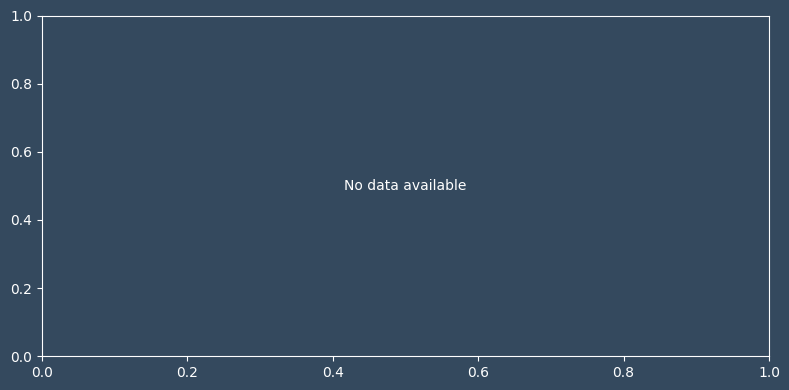

In [2]:
import cv2
import pickle
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, time
from deepface import DeepFace
from face_recognition import face_encodings, face_distance
import os
import tkinter as tk
from tkinter import ttk, messagebox, filedialog
from PIL import Image, ImageTk
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import threading
import queue
import time as time_module
import ast  # For safely evaluating string literals

# Configuration
ENCODINGS_FILE = 'data/encodings.pkl'
ATTENDANCE_FILE = 'data/attendance.csv'
TIMETABLE_FILE = 'data/timetable.csv'
SPOOF_THRESHOLD = 0.7
RECOGNITION_THRESHOLD = 0.5
DETECTOR_BACKEND = "opencv"
ATTENDANCE_INTERVAL = timedelta(hours=1)
CAMERA_WIDTH = 640
CAMERA_HEIGHT = 480
PROCESS_EVERY_N_FRAMES = 3

# Color Theme
BG_COLOR = "#2c3e50"
FG_COLOR = "#ecf0f1"
ACCENT_COLOR = "#3498db"
WARNING_COLOR = "#e74c3c"
SUCCESS_COLOR = "#2ecc71"
FRAME_COLOR = "#34495e"

class FaceRecognitionThread(threading.Thread):
    def __init__(self, video_capture, encodings, names):
        threading.Thread.__init__(self)
        self.video_capture = video_capture
        self.known_encodings = encodings
        self.known_names = names
        self.frame_queue = queue.Queue(maxsize=1)
        self.result_queue = queue.Queue()
        self.running = True
        self.frame_count = 0
        
    def run(self):
        while self.running:
            try:
                frame = self.frame_queue.get(timeout=0.1)
                self.frame_count += 1
                
                if self.frame_count % PROCESS_EVERY_N_FRAMES != 0:
                    continue
                
                try:
                    face_objs = DeepFace.extract_faces(
                        img_path=frame,
                        detector_backend=DETECTOR_BACKEND,
                        anti_spoofing=True,
                        enforce_detection=False
                    )
                except Exception as e:
                    print(f"Face detection error: {e}")
                    face_objs = []
                
                results = []
                for face_obj in face_objs:
                    x, y, w, h = face_obj["facial_area"]["x"], face_obj["facial_area"]["y"], \
                                 face_obj["facial_area"]["w"], face_obj["facial_area"]["h"]
                    
                    is_real = face_obj["is_real"] and (face_obj["antispoof_score"] >= SPOOF_THRESHOLD)
                    
                    if is_real:
                        face_roi = frame[y:y+h, x:x+w]
                        face_encoding = self.extract_face_encodings(face_roi)
                        
                        if face_encoding is not None:
                            name, confidence = self.recognize_face(face_encoding)
                            results.append({
                                "coords": (x, y, w, h),
                                "label": f"{name} ({confidence:.2f})" if name else "Unknown",
                                "color": (0, 255, 0) if name else (0, 255, 255),
                                "name": name,
                                "is_real": True
                            })
                    else:
                        results.append({
                            "coords": (x, y, w, h),
                            "label": f"Spoof ({face_obj['antispoof_score']:.2f})",
                            "color": (0, 0, 255),
                            "name": None,
                            "is_real": False
                        })
                
                self.result_queue.put((frame, results))
                
            except queue.Empty:
                continue
                
    def extract_face_encodings(self, face_img):
        rgb_face = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
        encodings = face_encodings(rgb_face)
        return encodings[0] if encodings else None
    
    def recognize_face(self, face_encoding):
        distances = face_distance(self.known_encodings, face_encoding)
        best_match_idx = np.argmin(distances)
        min_distance = distances[best_match_idx]
        
        if min_distance <= RECOGNITION_THRESHOLD:
            return self.known_names[best_match_idx], 1 - min_distance
        return None, None
    
    def stop(self):
        self.running = False

class EnhancedFaceRecognitionApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Interactive Face Recognition System")
        self.root.geometry("1200x800")
        self.root.configure(bg=BG_COLOR)
        
        self.style = ttk.Style()
        self.style.theme_use('clam')
        self.configure_styles()
        
        self.known_encodings, self.known_names = self.load_encodings()
        self.attendance_df = self.load_attendance()
        self.timetable_df = self.load_timetable()
        self.recently_recognized = {}
        self.cap = None
        self.current_class = None
        self.running = False
        self.recognition_thread = None
        
        self.setup_gui()
        self.update_current_class()
        
    def configure_styles(self):
        self.style.configure('TFrame', background=BG_COLOR)
        self.style.configure('TLabel', background=BG_COLOR, foreground=FG_COLOR)
        self.style.configure('TButton', background=ACCENT_COLOR, foreground=FG_COLOR, 
                           font=('Helvetica', 10, 'bold'))
        self.style.configure('TNotebook', background=BG_COLOR)
        self.style.configure('TNotebook.Tab', background=FRAME_COLOR, foreground=FG_COLOR,
                           padding=[10, 5], font=('Helvetica', 10, 'bold'))
        self.style.map('TNotebook.Tab', background=[('selected', ACCENT_COLOR)])
        self.style.configure('Treeview', background=FRAME_COLOR, foreground=FG_COLOR,
                           fieldbackground=FRAME_COLOR)
        self.style.configure('Treeview.Heading', background=ACCENT_COLOR, foreground=FG_COLOR)
        self.style.map('Treeview', background=[('selected', '#2980b9')])
        
    def setup_gui(self):
        self.notebook = ttk.Notebook(self.root)
        self.notebook.pack(fill=tk.BOTH, expand=True, padx=10, pady=10)
        
        self.live_tab = ttk.Frame(self.notebook)
        self.notebook.add(self.live_tab, text="Live Recognition")
        self.setup_live_tab()
        
        self.log_tab = ttk.Frame(self.notebook)
        self.notebook.add(self.log_tab, text="Attendance Log")
        self.setup_log_tab()
        
        self.stats_tab = ttk.Frame(self.notebook)
        self.notebook.add(self.stats_tab, text="Statistics")
        self.setup_stats_tab()
        
        self.status_var = tk.StringVar()
        self.status_var.set("System Ready")
        self.status_bar = tk.Label(self.root, textvariable=self.status_var, bd=1, relief=tk.SUNKEN, 
                                 anchor=tk.W, bg=FRAME_COLOR, fg=FG_COLOR, font=('Helvetica', 10))
        self.status_bar.pack(side=tk.BOTTOM, fill=tk.X)
        
    def setup_live_tab(self):
        main_frame = ttk.Frame(self.live_tab)
        main_frame.pack(fill=tk.BOTH, expand=True, padx=10, pady=10)
        
        left_frame = ttk.Frame(main_frame)
        left_frame.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)
        
        video_frame = ttk.LabelFrame(left_frame, text="Camera Feed", padding=10)
        video_frame.pack(fill=tk.BOTH, expand=True)
        
        self.video_label = tk.Label(video_frame, bg='black')
        self.video_label.pack(fill=tk.BOTH, expand=True)
        
        control_frame = ttk.Frame(left_frame)
        control_frame.pack(fill=tk.X, pady=10)
        
        self.start_btn = ttk.Button(control_frame, text="▶ Start", command=self.start_camera,
                                  style='Accent.TButton')
        self.start_btn.pack(side=tk.LEFT, padx=5, ipadx=10, ipady=5)
        
        self.stop_btn = ttk.Button(control_frame, text="■ Stop", command=self.stop_camera,
                                 state=tk.DISABLED, style='Accent.TButton')
        self.stop_btn.pack(side=tk.LEFT, padx=5, ipadx=10, ipady=5)
        
        right_frame = ttk.Frame(main_frame)
        right_frame.pack(side=tk.RIGHT, fill=tk.BOTH, padx=10)
        
        class_card = ttk.LabelFrame(right_frame, text="Current Class", padding=10)
        class_card.pack(fill=tk.X, pady=5)
        
        self.class_var = tk.StringVar()
        self.class_var.set("No class currently scheduled")
        class_label = ttk.Label(class_card, textvariable=self.class_var, 
                              font=('Helvetica', 12, 'bold'), foreground=ACCENT_COLOR)
        class_label.pack(pady=5)
        
        info_frame = ttk.Frame(class_card)
        info_frame.pack(fill=tk.X)
        
        ttk.Label(info_frame, text="Time:").grid(row=0, column=0, sticky=tk.W, padx=5, pady=2)
        self.time_var = tk.StringVar()
        self.time_var.set("--:-- -- --:-- --")
        ttk.Label(info_frame, textvariable=self.time_var).grid(row=0, column=1, sticky=tk.W, padx=5, pady=2)
        
        ttk.Label(info_frame, text="Expected:").grid(row=1, column=0, sticky=tk.W, padx=5, pady=2)
        self.expected_var = tk.StringVar()
        self.expected_var.set("--")
        ttk.Label(info_frame, textvariable=self.expected_var).grid(row=1, column=1, sticky=tk.W, padx=5, pady=2)
        
        ttk.Label(info_frame, text="Present:").grid(row=2, column=0, sticky=tk.W, padx=5, pady=2)
        self.present_var = tk.StringVar()
        self.present_var.set("--")
        present_label = ttk.Label(info_frame, textvariable=self.present_var, foreground=SUCCESS_COLOR)
        present_label.grid(row=2, column=1, sticky=tk.W, padx=5, pady=2)
        
        ttk.Label(info_frame, text="Absent:").grid(row=3, column=0, sticky=tk.W, padx=5, pady=2)
        self.absent_var = tk.StringVar()
        self.absent_var.set("--")
        absent_label = ttk.Label(info_frame, textvariable=self.absent_var, foreground=WARNING_COLOR)
        absent_label.grid(row=3, column=1, sticky=tk.W, padx=5, pady=2)
        
        list_frame = ttk.LabelFrame(right_frame, text="Student Status", padding=10)
        list_frame.pack(fill=tk.BOTH, expand=True, pady=10)
        
        canvas = tk.Canvas(list_frame, bg=FRAME_COLOR, highlightthickness=0)
        scrollbar = ttk.Scrollbar(list_frame, orient="vertical", command=canvas.yview)
        scrollable_frame = ttk.Frame(canvas)
        
        scrollable_frame.bind(
            "<Configure>",
            lambda e: canvas.configure(
                scrollregion=canvas.bbox("all")
            )
        )
        
        canvas.create_window((0, 0), window=scrollable_frame, anchor="nw")
        canvas.configure(yscrollcommand=scrollbar.set)
        
        canvas.pack(side="left", fill="both", expand=True)
        scrollbar.pack(side="right", fill="y")
        
        self.student_frame = scrollable_frame
        
    def setup_log_tab(self):
        main_frame = ttk.Frame(self.log_tab)
        main_frame.pack(fill=tk.BOTH, expand=True, padx=10, pady=10)
        
        filter_frame = ttk.Frame(main_frame)
        filter_frame.pack(fill=tk.X, pady=5)
        
        ttk.Label(filter_frame, text="Filter by:").pack(side=tk.LEFT, padx=5)
        
        self.filter_name_var = tk.StringVar()
        name_entry = ttk.Entry(filter_frame, textvariable=self.filter_name_var, width=20)
        name_entry.pack(side=tk.LEFT, padx=5)
        name_entry.bind("<Return>", lambda e: self.apply_filters())
        
        ttk.Label(filter_frame, text="Date:").pack(side=tk.LEFT, padx=5)
        
        self.filter_date_var = tk.StringVar()
        date_entry = ttk.Entry(filter_frame, textvariable=self.filter_date_var, width=10)
        date_entry.pack(side=tk.LEFT, padx=5)
        date_entry.bind("<Return>", lambda e: self.apply_filters())
        
        filter_btn = ttk.Button(filter_frame, text="Apply Filter", command=self.apply_filters)
        filter_btn.pack(side=tk.LEFT, padx=5)
        
        reset_btn = ttk.Button(filter_frame, text="Reset", command=self.reset_filters)
        reset_btn.pack(side=tk.LEFT, padx=5)
        
        log_frame = ttk.LabelFrame(main_frame, text="Attendance Records", padding=10)
        log_frame.pack(fill=tk.BOTH, expand=True)
        
        tree_frame = ttk.Frame(log_frame)
        tree_frame.pack(fill=tk.BOTH, expand=True)
        
        self.tree = ttk.Treeview(tree_frame, columns=('Name', 'Timestamp', 'Status'), 
                               show='headings', selectmode='browse')
        
        self.tree.heading('Name', text='Name')
        self.tree.heading('Timestamp', text='Timestamp')
        self.tree.heading('Status', text='Status')
        
        self.tree.column('Name', width=150)
        self.tree.column('Timestamp', width=180)
        self.tree.column('Status', width=100)
        
        y_scroll = ttk.Scrollbar(tree_frame, orient='vertical', command=self.tree.yview)
        x_scroll = ttk.Scrollbar(tree_frame, orient='horizontal', command=self.tree.xview)
        self.tree.configure(yscrollcommand=y_scroll.set, xscrollcommand=x_scroll.set)
        
        self.tree.grid(row=0, column=0, sticky='nsew')
        y_scroll.grid(row=0, column=1, sticky='ns')
        x_scroll.grid(row=1, column=0, sticky='ew')
        
        tree_frame.grid_rowconfigure(0, weight=1)
        tree_frame.grid_columnconfigure(0, weight=1)
        
        export_frame = ttk.Frame(main_frame)
        export_frame.pack(fill=tk.X, pady=5)
        
        export_csv_btn = ttk.Button(export_frame, text="Export to CSV", command=self.export_to_csv)
        export_csv_btn.pack(side=tk.LEFT, padx=5)
        
        export_pdf_btn = ttk.Button(export_frame, text="Export to PDF", command=self.export_to_pdf)
        export_pdf_btn.pack(side=tk.LEFT, padx=5)
        
        self.update_attendance_log()
        
    def setup_stats_tab(self):
        main_frame = ttk.Frame(self.stats_tab)
        main_frame.pack(fill=tk.BOTH, expand=True, padx=10, pady=10)
        
        stats_frame = ttk.LabelFrame(main_frame, text="Attendance Statistics", padding=10)
        stats_frame.pack(fill=tk.BOTH, expand=True)
        
        plt.style.use('dark_background')
        self.fig, self.ax = plt.subplots(figsize=(8, 4), facecolor=FRAME_COLOR)
        self.ax.set_facecolor(FRAME_COLOR)
        self.fig.tight_layout()
        
        self.canvas = FigureCanvasTkAgg(self.fig, master=stats_frame)
        self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
        
        controls_frame = ttk.Frame(stats_frame)
        controls_frame.pack(fill=tk.X, pady=10)
        
        ttk.Label(controls_frame, text="Time Period:").pack(side=tk.LEFT, padx=5)
        
        self.stats_period_var = tk.StringVar(value="week")
        periods = [("Last Week", "week"), ("Last Month", "month"), ("Last Year", "year"), ("All Time", "all")]
        
        for text, value in periods:
            rb = ttk.Radiobutton(controls_frame, text=text, variable=self.stats_period_var, 
                                value=value, command=self.update_stats)
            rb.pack(side=tk.LEFT, padx=5)
        
        summary_frame = ttk.LabelFrame(main_frame, text="Summary Statistics", padding=10)
        summary_frame.pack(fill=tk.BOTH, pady=10)
        
        stats_grid = ttk.Frame(summary_frame)
        stats_grid.pack(fill=tk.BOTH, expand=True)
        
        ttk.Label(stats_grid, text="Total Students:").grid(row=0, column=0, sticky=tk.W, padx=5, pady=2)
        self.total_students_var = tk.StringVar(value="0")
        ttk.Label(stats_grid, textvariable=self.total_students_var).grid(row=0, column=1, sticky=tk.W, padx=5, pady=2)
        
        ttk.Label(stats_grid, text="Avg. Attendance:").grid(row=1, column=0, sticky=tk.W, padx=5, pady=2)
        self.avg_attendance_var = tk.StringVar(value="0%")
        ttk.Label(stats_grid, textvariable=self.avg_attendance_var).grid(row=1, column=1, sticky=tk.W, padx=5, pady=2)
        
        ttk.Label(stats_grid, text="Most Punctual:").grid(row=2, column=0, sticky=tk.W, padx=5, pady=2)
        self.most_punctual_var = tk.StringVar(value="None")
        ttk.Label(stats_grid, textvariable=self.most_punctual_var).grid(row=2, column=1, sticky=tk.W, padx=5, pady=2)
        
        ttk.Label(stats_grid, text="Least Punctual:").grid(row=3, column=0, sticky=tk.W, padx=5, pady=2)
        self.least_punctual_var = tk.StringVar(value="None")
        ttk.Label(stats_grid, textvariable=self.least_punctual_var).grid(row=3, column=1, sticky=tk.W, padx=5, pady=2)
        
        # Initial update
        self.update_stats()
        
    def update_stats(self):
        """Update the statistics display based on selected time period"""
        period = self.stats_period_var.get()
        now = datetime.now()
        
        # Filter data based on time period
        if period == "week":
            start_date = now - timedelta(days=7)
            df = self.attendance_df[self.attendance_df['timestamp'] >= start_date]
        elif period == "month":
            start_date = now - timedelta(days=30)
            df = self.attendance_df[self.attendance_df['timestamp'] >= start_date]
        elif period == "year":
            start_date = now - timedelta(days=365)
            df = self.attendance_df[self.attendance_df['timestamp'] >= start_date]
        else:
            df = self.attendance_df.copy()
        
        if df.empty:
            self.ax.clear()
            self.ax.text(0.5, 0.5, 'No data available', ha='center', va='center')
            self.canvas.draw()
            
            self.total_students_var.set("0")
            self.avg_attendance_var.set("0%")
            self.most_punctual_var.set("None")
            self.least_punctual_var.set("None")
            return
        
        # Plot attendance by day
        self.ax.clear()
        
        # Group by date and count unique students
        daily_attendance = df.groupby(df['timestamp'].dt.date)['name'].nunique()
        daily_attendance.plot(kind='bar', ax=self.ax, color=ACCENT_COLOR)
        
        self.ax.set_title(f"Daily Attendance ({period.capitalize()})", color=FG_COLOR)
        self.ax.set_xlabel("Date", color=FG_COLOR)
        self.ax.set_ylabel("Number of Students", color=FG_COLOR)
        self.ax.tick_params(colors=FG_COLOR)
        
        # Rotate x-axis labels for better readability
        for label in self.ax.get_xticklabels():
            label.set_rotation(45)
            label.set_ha('right')
        
        self.canvas.draw()
        
        # Update summary statistics
        unique_students = df['name'].nunique()
        total_classes = df['class'].nunique()
        
        if total_classes > 0:
            avg_attendance = (len(df) / (unique_students * total_classes)) * 100
        else:
            avg_attendance = 0
        
        # Calculate punctuality (students with most and least attendance)
        student_attendance = df['name'].value_counts()
        
        if not student_attendance.empty:
            most_punctual = student_attendance.idxmax()
            least_punctual = student_attendance.idxmin()
        else:
            most_punctual = "None"
            least_punctual = "None"
        
        self.total_students_var.set(str(unique_students))
        self.avg_attendance_var.set(f"{avg_attendance:.1f}%")
        self.most_punctual_var.set(most_punctual)
        self.least_punctual_var.set(least_punctual)
    
    def load_encodings(self):
        """Load face encodings from file"""
        if os.path.exists(ENCODINGS_FILE):
            with open(ENCODINGS_FILE, 'rb') as f:
                data = pickle.load(f)
                return data['encodings'], data['names']
        return [], []
    
    def load_attendance(self):
        """Load attendance records from CSV"""
        if os.path.exists(ATTENDANCE_FILE):
            df = pd.read_csv(ATTENDANCE_FILE)
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            # Add class column if not present (for backward compatibility)
            if 'class' not in df.columns:
                df['class'] = 'No Class'
            return df
        return pd.DataFrame(columns=['name', 'timestamp', 'status', 'class'])
    
    def load_timetable(self):
        """Load timetable data"""
        if os.path.exists(TIMETABLE_FILE):
            df = pd.read_csv(TIMETABLE_FILE)
            df['start_time'] = pd.to_datetime(df['start_time']).dt.time
            df['end_time'] = pd.to_datetime(df['end_time']).dt.time
            return df
        return pd.DataFrame(columns=['class_name', 'day', 'start_time', 'end_time', 'students'])
    
    def update_current_class(self):
        """Update the current class based on timetable and current time"""
        now = datetime.now()
        current_time = now.time()
        current_day = now.strftime("%A")
        
        # Find classes happening now
        current_classes = self.timetable_df[
            (self.timetable_df['day'] == current_day) &
            (self.timetable_df['start_time'] <= current_time) &
            (self.timetable_df['end_time'] >= current_time)
        ]
        
        if not current_classes.empty:
            self.current_class = current_classes.iloc[0]
            self.class_var.set(self.current_class['class_name'])
            
            # Format time display
            start_str = self.current_class['start_time'].strftime("%I:%M %p")
            end_str = self.current_class['end_time'].strftime("%I:%M %p")
            self.time_var.set(f"{start_str} to {end_str}")
            
            # Update expected students
            try:
                expected_students = ast.literal_eval(self.current_class['students'])
                self.expected_var.set(f"{len(expected_students)} students")
            except:
                expected_students = []
                self.expected_var.set("Error reading student list")
            
            # Update present/absent counts
            self.update_attendance_counts()
        else:
            self.current_class = None
            self.class_var.set("No class currently scheduled")
            self.time_var.set("--:-- -- --:-- --")
            self.expected_var.set("--")
            self.present_var.set("--")
            self.absent_var.set("--")
        
        # Update student list
        self.update_student_list()
        
        # Schedule next update
        self.root.after(60000, self.update_current_class)
    
    def update_attendance_counts(self):
        """Update the present/absent counts for the current class"""
        if self.current_class is None:
            return
            
        now = datetime.now()
        today = now.date()
        class_name = self.current_class['class_name']
        
        try:
            expected_students = ast.literal_eval(self.current_class['students'])
        except:
            expected_students = []
        
        # Get attendance for this class today
        class_attendance = self.attendance_df[
            (self.attendance_df['class'] == class_name) &
            (self.attendance_df['timestamp'].dt.date == today)
        ]
        
        present_students = class_attendance['name'].unique()
        present_count = len(present_students)
        absent_count = len(expected_students) - present_count
        
        self.present_var.set(f"{present_count} students")
        self.absent_var.set(f"{absent_count} students")
    
    def update_student_list(self):
        """Update the list of students in the current class"""
        for widget in self.student_frame.winfo_children():
            widget.destroy()
            
        if self.current_class is None:
            ttk.Label(self.student_frame, text="No class currently scheduled").pack(pady=10)
            return
            
        try:
            expected_students = ast.literal_eval(self.current_class['students'])
        except:
            expected_students = []
            ttk.Label(self.student_frame, text="Error reading student list").pack(pady=10)
            return
            
        now = datetime.now()
        today = now.date()
        class_name = self.current_class['class_name']
        
        # Get attendance for this class today
        class_attendance = self.attendance_df[
            (self.attendance_df['class'] == class_name) &
            (self.attendance_df['timestamp'].dt.date == today)
        ]
        
        present_students = class_attendance['name'].unique()
        
        # Create student cards
        for i, student in enumerate(expected_students):
            frame = ttk.Frame(self.student_frame, relief=tk.RIDGE, padding=5)
            frame.pack(fill=tk.X, pady=2)
            
            # Status indicator
            status = "Present" if student in present_students else "Absent"
            color = SUCCESS_COLOR if status == "Present" else WARNING_COLOR
            
            ttk.Label(frame, text=student, width=20).pack(side=tk.LEFT, padx=5)
            ttk.Label(frame, text=status, foreground=color, width=10).pack(side=tk.LEFT, padx=5)
            
            # Last seen time if present
            if status == "Present":
                last_seen = class_attendance[class_attendance['name'] == student]['timestamp'].max()
                last_seen_str = last_seen.strftime("%I:%M %p")
                ttk.Label(frame, text=last_seen_str).pack(side=tk.RIGHT, padx=5)
    
    def update_attendance_log(self):
        """Update the attendance log Treeview"""
        for item in self.tree.get_children():
            self.tree.delete(item)
            
        name_filter = self.filter_name_var.get().lower()
        date_filter = self.filter_date_var.get()
        
        filtered_df = self.attendance_df.copy()
        
        if name_filter:
            filtered_df = filtered_df[filtered_df['name'].str.lower().str.contains(name_filter)]
            
        if date_filter:
            try:
                filter_date = pd.to_datetime(date_filter).date()
                filtered_df = filtered_df[filtered_df['timestamp'].dt.date == filter_date]
            except:
                pass
        
        # Add records to treeview
        for _, row in filtered_df.iterrows():
            timestamp_str = row['timestamp'].strftime("%Y-%m-%d %I:%M %p")
            self.tree.insert("", tk.END, values=(
                row['name'],
                timestamp_str,
                row['status']
            ))
    
    def apply_filters(self):
        """Apply filters to attendance log"""
        self.update_attendance_log()
    
    def reset_filters(self):
        """Reset all filters"""
        self.filter_name_var.set("")
        self.filter_date_var.set("")
        self.update_attendance_log()
    
    def export_to_csv(self):
        """Export attendance data to CSV"""
        filename = filedialog.asksaveasfilename(
            defaultextension=".csv",
            filetypes=[("CSV files", "*.csv")],
            title="Save attendance data as CSV"
        )
        
        if filename:
            try:
                self.attendance_df.to_csv(filename, index=False)
                messagebox.showinfo("Success", f"Attendance data exported to {filename}")
            except Exception as e:
                messagebox.showerror("Error", f"Failed to export data: {str(e)}")
    
    def export_to_pdf(self):
        """Export attendance data to PDF"""
        messagebox.showinfo("Info", "PDF export functionality would be implemented here")
    
    def start_camera(self):
        """Start the camera and face recognition thread"""
        if self.cap is not None:
            return
            
        self.cap = cv2.VideoCapture(0)
        self.cap.set(cv2.CAP_PROP_FRAME_WIDTH, CAMERA_WIDTH)
        self.cap.set(cv2.CAP_PROP_FRAME_HEIGHT, CAMERA_HEIGHT)
        
        if not self.cap.isOpened():
            messagebox.showerror("Error", "Could not open camera")
            self.cap = None
            return
            
        self.running = True
        self.start_btn.config(state=tk.DISABLED)
        self.stop_btn.config(state=tk.NORMAL)
        
        # Start recognition thread
        self.recognition_thread = FaceRecognitionThread(self.cap, self.known_encodings, self.known_names)
        self.recognition_thread.start()
        
        # Start video update loop
        self.update_video()
        
    def stop_camera(self):
        """Stop the camera and recognition thread"""
        if self.cap is None:
            return
            
        self.running = False
        if self.recognition_thread is not None:
            self.recognition_thread.stop()
            self.recognition_thread.join()
            self.recognition_thread = None
            
        self.cap.release()
        self.cap = None
        
        self.start_btn.config(state=tk.NORMAL)
        self.stop_btn.config(state=tk.DISABLED)
        
        # Clear video display
        self.video_label.config(image='')
    
    def update_video(self):
        """Update the video feed with processed frames"""
        if not self.running or self.cap is None:
            return
            
        ret, frame = self.cap.read()
        
        if ret:
            display_frame = cv2.resize(frame, (CAMERA_WIDTH, CAMERA_HEIGHT))
            
            if self.recognition_thread is not None:
                try:
                    self.recognition_thread.frame_queue.put_nowait(display_frame)
                except queue.Full:
                    pass
                
                try:
                    processed_frame, results = self.recognition_thread.result_queue.get_nowait()
                    
                    for result in results:
                        x, y, w, h = result['coords']
                        cv2.rectangle(processed_frame, (x, y), (x+w, y+h), result['color'], 2)
                        cv2.putText(processed_frame, result['label'], (x, y-10), 
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, result['color'], 2)
                        
                        if result['name'] and result['is_real']:
                            self.record_attendance(result['name'])
                    
                    display_frame = processed_frame
                except queue.Empty:
                    pass
            
            img = cv2.cvtColor(display_frame, cv2.COLOR_BGR2RGB)
            img = Image.fromarray(img)
            imgtk = ImageTk.PhotoImage(image=img)
            
            self.video_label.imgtk = imgtk
            self.video_label.configure(image=imgtk)
        
        self.root.after(30, self.update_video)
    
    def record_attendance(self, name):
        """Record attendance for recognized student"""
        now = datetime.now()
        today = now.date()
        
        if name in self.recently_recognized:
            last_time = self.recently_recognized[name]
            if now - last_time < ATTENDANCE_INTERVAL:
                return
        
        if self.current_class is not None:
            class_name = self.current_class['class_name']
            try:
                expected_students = ast.literal_eval(self.current_class['students'])
            except:
                expected_students = []
            
            if name in expected_students:
                status = "Present"
            else:
                status = "Unexpected"
        else:
            class_name = "No Class"
            status = "Unexpected"
        
        new_record = {
            'name': name,
            'timestamp': now,
            'status': status,
            'class': class_name
        }
        
        self.attendance_df = pd.concat([
            self.attendance_df,
            pd.DataFrame([new_record])
        ], ignore_index=True)
        
        self.save_attendance()
        
        self.update_attendance_counts()
        self.update_student_list()
        self.update_attendance_log()
        self.update_stats()
        
        self.recently_recognized[name] = now
        self.status_var.set(f"Recorded attendance for {name} in {class_name}")
    
    def save_attendance(self):
        """Save attendance data to CSV"""
        try:
            os.makedirs(os.path.dirname(ATTENDANCE_FILE), exist_ok=True)
            self.attendance_df.to_csv(ATTENDANCE_FILE, index=False)
        except Exception as e:
            messagebox.showerror("Error", f"Failed to save attendance: {str(e)}")
    
    def on_closing(self):
        """Handle window closing event"""
        self.stop_camera()
        self.save_attendance()
        self.root.destroy()

if __name__ == "__main__":
    root = tk.Tk()
    app = EnhancedFaceRecognitionApp(root)
    root.protocol("WM_DELETE_WINDOW", app.on_closing)
    root.mainloop()